In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from timeit import default_timer as timer

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set storLimitInfo 'Indicate the number of columns of information from storage units'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set v2gLimitInfo 'Indicate the number of columns of information from electric vehicles'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set csLimitInfo 'Indicate the number of columns of information from charging stations'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

#genLimitInfo = np.arange(1, genLimit.shape[2]+1)
#loadLimitInfo = np.arange(1, loadLimit.shape[2]+1)
#storLimitInfo = np.arange(1, storLimit.shape[2]+1)
#v2gLimitInfo = np.arange(1, v2gLimit.shape[2]+1)
#csLimitInfo = np.arange(1, csLimit.shape[0]+1)

In [12]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)
_v2g = np.arange(1, v2g+1)
_cs = np.arange(1, cs+1)

In [13]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

NameError: name 'result_genActPower' is not defined

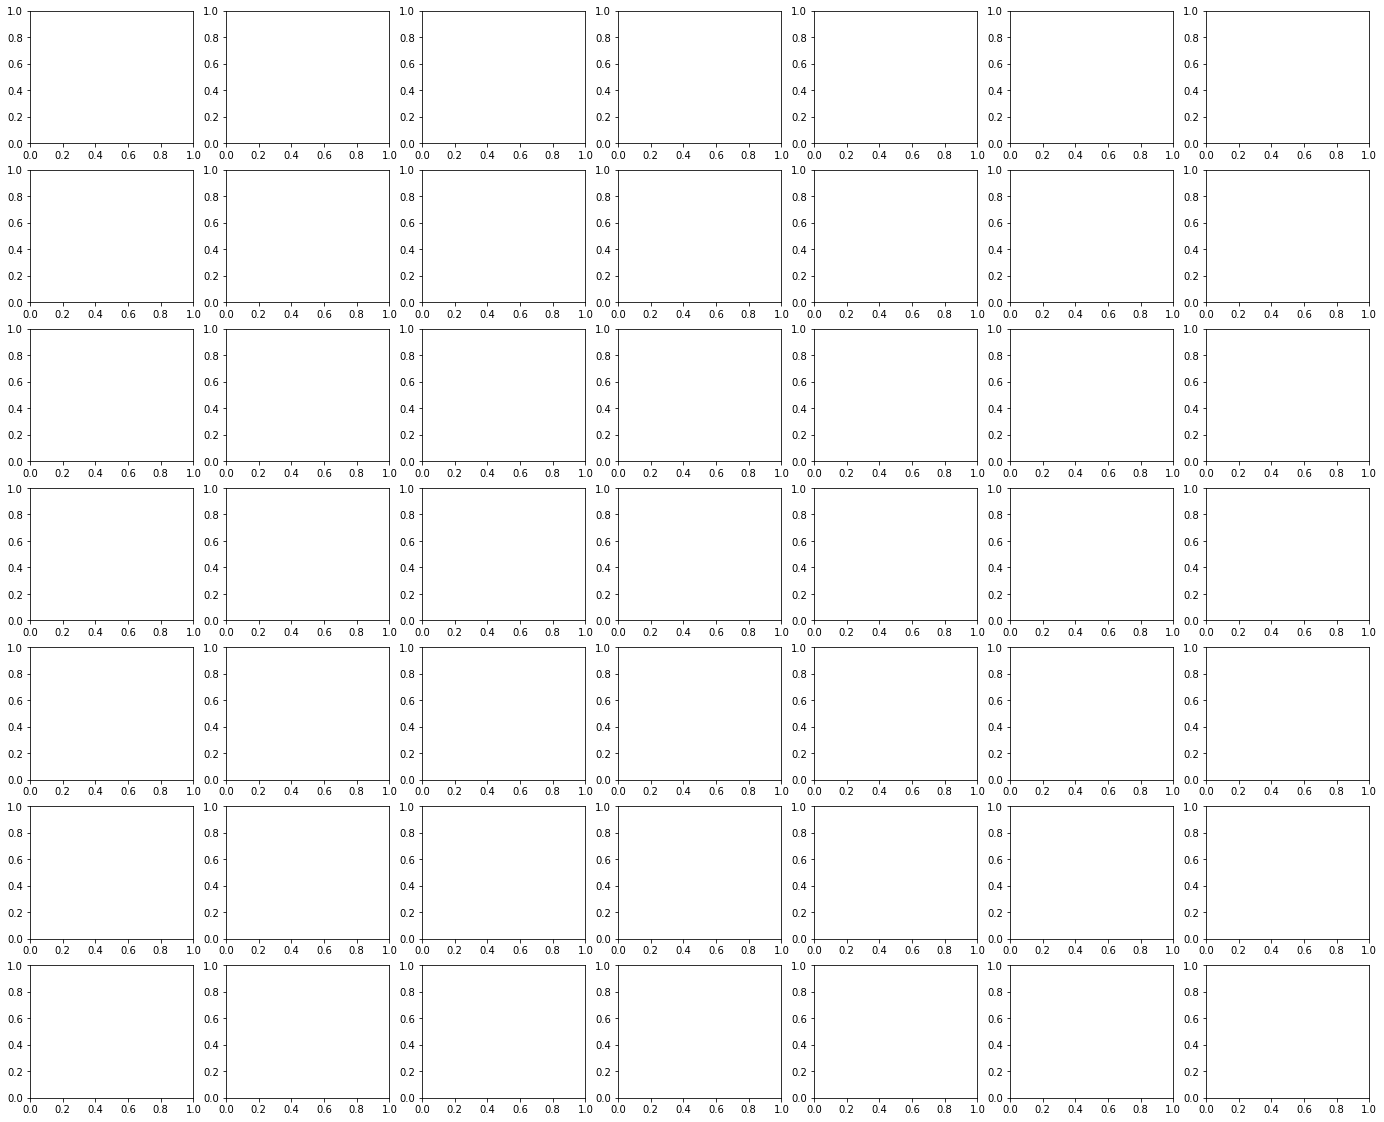

In [14]:
# Plot results

fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(result_storEnerState.values[i])
    axs[i, 3].legend(['storEnerState'])
    
for i in range(3):
    axs[i, 4].plot(result_storDchActPower.values[i])
    axs[i, 4].legend(['storDchActPower'])
    
for i in range(3):
    axs[i, 5].plot(result_storChActPower.values[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(result_v2gEnerState.values[i])
    axs[i, 6].legend(['v2gEnerState'])


plt.show()

In [14]:
# Pymoo import

import pymoo
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultSingleObjectiveTermination
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization

import multiprocessing
import tqdm

In [15]:
# Class to speed up code execution

class HeuristicData(object):
    def __init__(self):
        return
    
    
    def objectiveFunction(self):
        return
    
    
    def doIteration(self):
        return
    
    
    def newIteration(self):
        return
    

class EnergyCommunity(HeuristicData):
    
    def __init__(self, parameters, variables):
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        return
    
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def newIteration(self, encoded_vals):
        self.variableAssign(self.decode(encoded_vals))
        self.doIteration()
        return

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    

In [16]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [17]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [18]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [19]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            #'v2gDchActPower': v2gDchActPower,
            #'v2gChActPower': v2gChActPower,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs,
            #'storPieceSegments': np.array([1, 2, 3]),
            'storCapCost': storInfo[:, 5] * 0.00105,
            #'storCyclesMult': np.array([1000, 1200, 700]),
            'v2gCapCost': v2gInfo[:, 4] * 0.00105}
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [20]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [21]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': 30*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 30*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 100*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [22]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [23]:
# Properly shaped initial Solution

sol_shaped = {'genActPower': genLimit[:, :, 0],
              'genExcActPower': np.zeros(genExcActPower.shape),
              'pImp': pMaxImp,
              'pExp': np.zeros(pExp.shape),
              'loadRedActPower': np.zeros(loadRedActPower.shape),
              'loadENS': np.zeros(loadENS.shape),
              'storDchActPower': np.zeros(storDchActPower.shape),
              'storChActPower': np.zeros(storChActPower.shape),
              'EminRelaxStor': np.zeros(storEminRelaxStor.shape),
              #'v2gDchActPower': np.zeros(v2gDchActPower.shape),
              #'v2gChActPower': np.zeros(v2gChActPower.shape),
              'genXo': np.zeros(genXo.shape),
              'loadXo': np.zeros(loadXo.shape),
              'storDchXo': np.ones(storDchXo.shape),
              'storChXo': np.zeros(storChXo.shape),
              'v2gDchXo': np.zeros(v2gDchXo.shape),
              'v2gChXo': np.zeros(v2gChXo.shape)}

encoded_shaped = encode(sol_shaped)
decoded_shaped = decode(encoded_shaped, dict_var)

In [24]:
# Define a custom problem

class ProblemEC(Problem):
    
    def __init__(self, parameters, variables, xl, xu, n_var, **kwargs):
        super().__init__(n_var=n_var, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu, vtype=float, **kwargs)
        
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        obj = []
        #print(x)
        for temp in np.arange(x.shape[0]):
            #print(x[temp].shape)
            self.variableAssign(self.decode(x[temp]))
            self.doIteration()
            obj.append(self.objFn)
        out['F'] = obj

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        #print(new_variables.shape)
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded

In [ ]:
# Instantiate the problem

name = 'run03'

customProblem = ProblemEC(parameters=decoded_pars,
                          variables=decoded_shaped,
                          xl=encoded_minvals,
                          xu=encoded_maxvals,
                          n_var=1584)
                          #elementwise_runner=runner)

algorithm = GA(pop_size=10)

termination = get_termination('n_gen', 5e4)

temp_res = minimize(customProblem,
                    algorithm,
                    termination=termination,
                    #seed=1,
                    save_history=True,
                    verbose=True)

minimized_solution = pd.DataFrame(temp_res.X)
minimized_solution.to_csv('results/paper_ga/'+name+'/solution.csv')
print(temp_res.exec_time)

minimized_stats = pd.DataFrame({'objFun': temp_res.F,
                                'runtime': temp_res.exec_time})
minimized_stats.to_csv('results/paper_ga/'+name+'/stats.csv')

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.108332E+06 |  1.818063E+06
     2 |       20 |  1.937801E+06 |  1.716537E+06
     3 |       30 |  1.787375E+06 |  1.616900E+06
     4 |       40 |  1.666780E+06 |  1.515642E+06
     5 |       50 |  1.586237E+06 |  1.514838E+06
     6 |       60 |  1.535145E+06 |  1.414082E+06
     7 |       70 |  1.454632E+06 |  1.213519E+06
     8 |       80 |  1.364114E+06 |  1.213519E+06
     9 |       90 |  1.273731E+06 |  1.213496E+06
    10 |      100 |  1.213537E+06 |  1.213496E+06
    11 |      110 |  1.203502E+06 |  1.113501E+06
    12 |      120 |  1.183494E+06 |  1.113484E+06
    13 |      130 |  1.123494E+06 |  1.113484E+06
    14 |      140 |  1.113487E+06 |  1.113484E+06
    15 |      150 |  1.113483E+06 |  1.113479E+06
    16 |      160 |  1.113475E+06 |  1.113430E+06
    17 |      170 |  1.113461E+06 |  1.113420E+06
    18 |      180 |  1.113432E+06 |  1.113415E+06
    19 |      190 |  1.113419E+06 |  1.113415E+06


   167 |     1670 |  1.013069E+06 |  1.013067E+06
   168 |     1680 |  1.013068E+06 |  1.013065E+06
   169 |     1690 |  1.013067E+06 |  1.013065E+06
   170 |     1700 |  1.013063E+06 |  1.013045E+06
   171 |     1710 |  1.013058E+06 |  1.013045E+06
   172 |     1720 |  1.013048E+06 |  1.013040E+06
   173 |     1730 |  1.013043E+06 |  1.013040E+06
   174 |     1740 |  1.013039E+06 |  1.013030E+06
   175 |     1750 |  1.013034E+06 |  1.013030E+06
   176 |     1760 |  1.013027E+06 |  1.013015E+06
   177 |     1770 |  1.013021E+06 |  1.013002E+06
   178 |     1780 |  1.013014E+06 |  1.013001E+06
   179 |     1790 |  1.013008E+06 |  1.013001E+06
   180 |     1800 |  1.013001E+06 |  1.013001E+06
   181 |     1810 |  1.013001E+06 |  1.013001E+06
   182 |     1820 |  1.013001E+06 |  1.013001E+06
   183 |     1830 |  1.013001E+06 |  1.013000E+06
   184 |     1840 |  1.012999E+06 |  1.012990E+06
   185 |     1850 |  1.012997E+06 |  1.012989E+06
   186 |     1860 |  1.012990E+06 |  1.012986E+06


   331 |     3310 |  9.127177E+05 |  9.127158E+05
   332 |     3320 |  9.127163E+05 |  9.127132E+05
   333 |     3330 |  9.127139E+05 |  9.127111E+05
   334 |     3340 |  9.127112E+05 |  9.127097E+05
   335 |     3350 |  9.127107E+05 |  9.127097E+05
   336 |     3360 |  9.127092E+05 |  9.127047E+05
   337 |     3370 |  9.127080E+05 |  9.127038E+05
   338 |     3380 |  9.127054E+05 |  9.127029E+05
   339 |     3390 |  9.127032E+05 |  9.127016E+05
   340 |     3400 |  9.127008E+05 |  9.126955E+05
   341 |     3410 |  9.126972E+05 |  9.126890E+05
   342 |     3420 |  9.126903E+05 |  9.126842E+05
   343 |     3430 |  9.126860E+05 |  9.126842E+05
   344 |     3440 |  9.126831E+05 |  9.126732E+05
   345 |     3450 |  9.126818E+05 |  9.126729E+05
   346 |     3460 |  9.126771E+05 |  9.126712E+05
   347 |     3470 |  9.126717E+05 |  9.126671E+05
   348 |     3480 |  9.126696E+05 |  9.126646E+05
   349 |     3490 |  9.126669E+05 |  9.126626E+05
   350 |     3500 |  9.126639E+05 |  9.126624E+05


   497 |     4970 |  9.123157E+05 |  9.123150E+05
   498 |     4980 |  9.123146E+05 |  9.123084E+05
   499 |     4990 |  9.123119E+05 |  9.123040E+05
   500 |     5000 |  9.123072E+05 |  9.123040E+05
   501 |     5010 |  9.123038E+05 |  9.122972E+05
   502 |     5020 |  9.123003E+05 |  9.122972E+05
   503 |     5030 |  9.122975E+05 |  9.122970E+05
   504 |     5040 |  9.122972E+05 |  9.122970E+05
   505 |     5050 |  9.122961E+05 |  9.122880E+05
   506 |     5060 |  9.122942E+05 |  9.122879E+05
   507 |     5070 |  9.122894E+05 |  9.122870E+05
   508 |     5080 |  9.122875E+05 |  9.122867E+05
   509 |     5090 |  9.122849E+05 |  9.122760E+05
   510 |     5100 |  9.122790E+05 |  9.122717E+05
   511 |     5110 |  9.122718E+05 |  9.122588E+05
   512 |     5120 |  9.122676E+05 |  9.122588E+05
   513 |     5130 |  9.122607E+05 |  9.122576E+05
   514 |     5140 |  9.122587E+05 |  9.122576E+05
   515 |     5150 |  9.022568E+05 |  8.122464E+05
   516 |     5160 |  8.822539E+05 |  8.122456E+05


   665 |     6650 |  8.119347E+05 |  8.119343E+05
   666 |     6660 |  8.119341E+05 |  8.119326E+05
   667 |     6670 |  8.119333E+05 |  8.119300E+05
   668 |     6680 |  8.119323E+05 |  8.119300E+05
   669 |     6690 |  8.119297E+05 |  8.119196E+05
   670 |     6700 |  8.119247E+05 |  8.119196E+05
   671 |     6710 |  8.119178E+05 |  8.119107E+05
   672 |     6720 |  8.119138E+05 |  8.119104E+05
   673 |     6730 |  8.119090E+05 |  8.119046E+05
   674 |     6740 |  8.119048E+05 |  8.118937E+05
   675 |     6750 |  8.119010E+05 |  8.118936E+05
   676 |     6760 |  8.118948E+05 |  8.118923E+05
   677 |     6770 |  8.118915E+05 |  8.118846E+05
   678 |     6780 |  8.118889E+05 |  8.118838E+05
   679 |     6790 |  8.118848E+05 |  8.118838E+05
   680 |     6800 |  8.118841E+05 |  8.118836E+05
   681 |     6810 |  8.118835E+05 |  8.118828E+05
   682 |     6820 |  8.118832E+05 |  8.118819E+05
   683 |     6830 |  8.118826E+05 |  8.118817E+05
   684 |     6840 |  8.118810E+05 |  8.118739E+05


   833 |     8330 |  7.114299E+05 |  7.114287E+05
   834 |     8340 |  7.114291E+05 |  7.114287E+05
   835 |     8350 |  7.114287E+05 |  7.114287E+05
   836 |     8360 |  7.114286E+05 |  7.114286E+05
   837 |     8370 |  7.114286E+05 |  7.114284E+05
   838 |     8380 |  7.114285E+05 |  7.114284E+05
   839 |     8390 |  7.114285E+05 |  7.114284E+05
   840 |     8400 |  7.114284E+05 |  7.114280E+05
   841 |     8410 |  7.114283E+05 |  7.114280E+05
   842 |     8420 |  7.114282E+05 |  7.114280E+05
   843 |     8430 |  7.114280E+05 |  7.114278E+05
   844 |     8440 |  7.114276E+05 |  7.114250E+05
   845 |     8450 |  7.114270E+05 |  7.114250E+05
   846 |     8460 |  7.114254E+05 |  7.114249E+05
   847 |     8470 |  7.114250E+05 |  7.114249E+05
   848 |     8480 |  7.114249E+05 |  7.114248E+05
   849 |     8490 |  7.114248E+05 |  7.114247E+05
   850 |     8500 |  7.114247E+05 |  7.114243E+05
   851 |     8510 |  7.114240E+05 |  7.114194E+05
   852 |     8520 |  7.114223E+05 |  7.114192E+05


   998 |     9980 |  7.111370E+05 |  7.111369E+05
   999 |     9990 |  7.111370E+05 |  7.111369E+05
  1000 |    10000 |  7.111369E+05 |  7.111368E+05
  1001 |    10010 |  7.111368E+05 |  7.111368E+05
  1002 |    10020 |  7.111368E+05 |  7.111368E+05
  1003 |    10030 |  7.111367E+05 |  7.111365E+05
  1004 |    10040 |  7.111365E+05 |  7.111349E+05
  1005 |    10050 |  7.111363E+05 |  7.111349E+05
  1006 |    10060 |  7.111349E+05 |  7.111286E+05
  1007 |    10070 |  7.111328E+05 |  7.111276E+05
  1008 |    10080 |  7.111288E+05 |  7.111174E+05
  1009 |    10090 |  7.111245E+05 |  7.111174E+05
  1010 |    10100 |  7.111194E+05 |  7.111174E+05
  1011 |    10110 |  7.111174E+05 |  7.111173E+05
  1012 |    10120 |  7.111174E+05 |  7.111173E+05
  1013 |    10130 |  7.111173E+05 |  7.111173E+05
  1014 |    10140 |  7.111173E+05 |  7.111173E+05
  1015 |    10150 |  7.111173E+05 |  7.111173E+05
  1016 |    10160 |  7.111173E+05 |  7.111172E+05
  1017 |    10170 |  7.111172E+05 |  7.111172E+05


  1164 |    11640 |  6.107352E+05 |  6.107340E+05
  1165 |    11650 |  6.107338E+05 |  6.107268E+05
  1166 |    11660 |  6.107322E+05 |  6.107261E+05
  1167 |    11670 |  6.107293E+05 |  6.107247E+05
  1168 |    11680 |  6.107258E+05 |  6.107247E+05
  1169 |    11690 |  6.107252E+05 |  6.107247E+05
  1170 |    11700 |  6.107227E+05 |  6.107061E+05
  1171 |    11710 |  6.107194E+05 |  6.107058E+05
  1172 |    11720 |  6.107089E+05 |  6.107053E+05
  1173 |    11730 |  6.107054E+05 |  6.107053E+05
  1174 |    11740 |  6.107053E+05 |  6.107050E+05
  1175 |    11750 |  6.107036E+05 |  6.106900E+05
  1176 |    11760 |  6.107003E+05 |  6.106900E+05
  1177 |    11770 |  6.106906E+05 |  6.106894E+05
  1178 |    11780 |  6.106897E+05 |  6.106894E+05
  1179 |    11790 |  6.106893E+05 |  6.106884E+05
  1180 |    11800 |  6.106888E+05 |  6.106873E+05
  1181 |    11810 |  6.106866E+05 |  6.106720E+05
  1182 |    11820 |  6.106829E+05 |  6.106720E+05
  1183 |    11830 |  6.106759E+05 |  6.106720E+05


  1331 |    13310 |  6.101865E+05 |  6.101857E+05
  1332 |    13320 |  6.101858E+05 |  6.101857E+05
  1333 |    13330 |  6.101857E+05 |  6.101857E+05
  1334 |    13340 |  6.001847E+05 |  5.101758E+05
  1335 |    13350 |  5.801826E+05 |  5.101750E+05
  1336 |    13360 |  5.301768E+05 |  5.101750E+05
  1337 |    13370 |  5.101752E+05 |  5.101750E+05
  1338 |    13380 |  5.101741E+05 |  5.101670E+05
  1339 |    13390 |  5.101718E+05 |  5.101670E+05
  1340 |    13400 |  5.101669E+05 |  5.101614E+05
  1341 |    13410 |  5.101646E+05 |  5.101558E+05
  1342 |    13420 |  5.101606E+05 |  5.101558E+05
  1343 |    13430 |  5.101577E+05 |  5.101554E+05
  1344 |    13440 |  5.101556E+05 |  5.101552E+05
  1345 |    13450 |  5.101553E+05 |  5.101548E+05
  1346 |    13460 |  5.101551E+05 |  5.101548E+05
  1347 |    13470 |  5.101548E+05 |  5.101542E+05
  1348 |    13480 |  5.101526E+05 |  5.101336E+05
  1349 |    13490 |  5.101481E+05 |  5.101336E+05
  1350 |    13500 |  5.101400E+05 |  5.101290E+05


  1502 |    15020 |  4.097784E+05 |  4.097671E+05
  1503 |    15030 |  4.097695E+05 |  4.097582E+05
  1504 |    15040 |  4.097621E+05 |  4.097582E+05
  1505 |    15050 |  4.097582E+05 |  4.097582E+05
  1506 |    15060 |  4.097582E+05 |  4.097582E+05
  1507 |    15070 |  4.097582E+05 |  4.097582E+05
  1508 |    15080 |  4.097582E+05 |  4.097582E+05
  1509 |    15090 |  4.097582E+05 |  4.097582E+05
  1510 |    15100 |  4.097580E+05 |  4.097565E+05
  1511 |    15110 |  4.097576E+05 |  4.097565E+05
  1512 |    15120 |  4.097561E+05 |  4.097514E+05
  1513 |    15130 |  4.097550E+05 |  4.097514E+05
  1514 |    15140 |  4.097511E+05 |  4.097466E+05
  1515 |    15150 |  4.097489E+05 |  4.097446E+05
  1516 |    15160 |  4.097467E+05 |  4.097446E+05
  1517 |    15170 |  4.097441E+05 |  4.097382E+05
  1518 |    15180 |  4.097418E+05 |  4.097380E+05
  1519 |    15190 |  4.097387E+05 |  4.097379E+05
  1520 |    15200 |  4.097374E+05 |  4.097321E+05
  1521 |    15210 |  4.097362E+05 |  4.097319E+05


  1669 |    16690 |  3.094289E+05 |  3.094288E+05
  1670 |    16700 |  3.094288E+05 |  3.094287E+05
  1671 |    16710 |  3.094288E+05 |  3.094287E+05
  1672 |    16720 |  3.094287E+05 |  3.094287E+05
  1673 |    16730 |  3.094287E+05 |  3.094287E+05
  1674 |    16740 |  3.094287E+05 |  3.094287E+05
  1675 |    16750 |  3.094287E+05 |  3.094287E+05
  1676 |    16760 |  3.094287E+05 |  3.094287E+05
  1677 |    16770 |  3.094287E+05 |  3.094282E+05
  1678 |    16780 |  3.094286E+05 |  3.094282E+05
  1679 |    16790 |  3.094279E+05 |  3.094239E+05
  1680 |    16800 |  3.094260E+05 |  3.094170E+05
  1681 |    16810 |  3.094218E+05 |  3.094169E+05
  1682 |    16820 |  3.094175E+05 |  3.094138E+05
  1683 |    16830 |  3.094157E+05 |  3.094138E+05
  1684 |    16840 |  3.094143E+05 |  3.094136E+05
  1685 |    16850 |  3.094137E+05 |  3.094136E+05
  1686 |    16860 |  3.094136E+05 |  3.094133E+05
  1687 |    16870 |  3.094134E+05 |  3.094133E+05
  1688 |    16880 |  3.094133E+05 |  3.094133E+05


  1836 |    18360 |  3.091560E+05 |  3.091559E+05
  1837 |    18370 |  3.091559E+05 |  3.091559E+05
  1838 |    18380 |  3.091559E+05 |  3.091558E+05
  1839 |    18390 |  3.091559E+05 |  3.091558E+05
  1840 |    18400 |  3.091558E+05 |  3.091558E+05
  1841 |    18410 |  3.091556E+05 |  3.091540E+05
  1842 |    18420 |  3.091553E+05 |  3.091540E+05
  1843 |    18430 |  3.091542E+05 |  3.091540E+05
  1844 |    18440 |  3.091540E+05 |  3.091540E+05
  1845 |    18450 |  3.091540E+05 |  3.091539E+05
  1846 |    18460 |  3.091540E+05 |  3.091539E+05
  1847 |    18470 |  3.091539E+05 |  3.091539E+05
  1848 |    18480 |  3.091539E+05 |  3.091539E+05
  1849 |    18490 |  3.091539E+05 |  3.091538E+05
  1850 |    18500 |  3.091538E+05 |  3.091535E+05
  1851 |    18510 |  3.091524E+05 |  3.091406E+05
  1852 |    18520 |  3.091480E+05 |  3.091406E+05
  1853 |    18530 |  3.091394E+05 |  3.091286E+05
  1854 |    18540 |  3.091370E+05 |  3.091286E+05
  1855 |    18550 |  3.091300E+05 |  3.091281E+05


  2003 |    20030 |  3.088351E+05 |  3.088034E+05
  2004 |    20040 |  3.088060E+05 |  3.088034E+05
  2005 |    20050 |  3.088042E+05 |  3.088034E+05
  2006 |    20060 |  3.088034E+05 |  3.088034E+05
  2007 |    20070 |  3.088033E+05 |  3.088024E+05
  2008 |    20080 |  3.088031E+05 |  3.088024E+05
  2009 |    20090 |  3.088025E+05 |  3.088023E+05
  2010 |    20100 |  3.088023E+05 |  3.088023E+05
  2011 |    20110 |  3.088023E+05 |  3.088022E+05
  2012 |    20120 |  3.088022E+05 |  3.088013E+05
  2013 |    20130 |  3.088018E+05 |  3.088010E+05
  2014 |    20140 |  3.088012E+05 |  3.088001E+05
  2015 |    20150 |  3.088007E+05 |  3.088000E+05
  2016 |    20160 |  3.088002E+05 |  3.088000E+05
  2017 |    20170 |  3.087995E+05 |  3.087965E+05
  2018 |    20180 |  3.087981E+05 |  3.087915E+05
  2019 |    20190 |  3.087944E+05 |  3.087913E+05
  2020 |    20200 |  3.087915E+05 |  3.087912E+05
  2021 |    20210 |  3.087899E+05 |  3.087805E+05
  2022 |    20220 |  3.087869E+05 |  3.087789E+05


  2168 |    21680 |  3.085328E+05 |  3.085290E+05
  2169 |    21690 |  3.085318E+05 |  3.085290E+05
  2170 |    21700 |  3.085300E+05 |  3.085288E+05
  2171 |    21710 |  3.085288E+05 |  3.085279E+05
  2172 |    21720 |  3.085279E+05 |  3.085229E+05
  2173 |    21730 |  3.085264E+05 |  3.085229E+05
  2174 |    21740 |  3.085236E+05 |  3.085217E+05
  2175 |    21750 |  3.085216E+05 |  3.085145E+05
  2176 |    21760 |  3.085195E+05 |  3.085130E+05
  2177 |    21770 |  3.085160E+05 |  3.085129E+05
  2178 |    21780 |  3.085129E+05 |  3.085121E+05
  2179 |    21790 |  3.085124E+05 |  3.085112E+05
  2180 |    21800 |  3.085117E+05 |  3.085105E+05
  2181 |    21810 |  3.085098E+05 |  3.085012E+05
  2182 |    21820 |  3.085066E+05 |  3.084946E+05
  2183 |    21830 |  3.084994E+05 |  3.084925E+05
  2184 |    21840 |  3.084940E+05 |  3.084925E+05
  2185 |    21850 |  3.084931E+05 |  3.084925E+05
  2186 |    21860 |  3.084926E+05 |  3.084924E+05
  2187 |    21870 |  3.084924E+05 |  3.084924E+05


  2335 |    23350 |  3.081535E+05 |  3.081528E+05
  2336 |    23360 |  3.081529E+05 |  3.081528E+05
  2337 |    23370 |  3.081528E+05 |  3.081528E+05
  2338 |    23380 |  3.081528E+05 |  3.081527E+05
  2339 |    23390 |  3.081527E+05 |  3.081527E+05
  2340 |    23400 |  3.081527E+05 |  3.081523E+05
  2341 |    23410 |  3.081526E+05 |  3.081523E+05
  2342 |    23420 |  3.081524E+05 |  3.081522E+05
  2343 |    23430 |  3.081518E+05 |  3.081474E+05
  2344 |    23440 |  3.081508E+05 |  3.081474E+05
  2345 |    23450 |  3.081484E+05 |  3.081473E+05
  2346 |    23460 |  3.081474E+05 |  3.081473E+05
  2347 |    23470 |  3.081473E+05 |  3.081472E+05
  2348 |    23480 |  3.081473E+05 |  3.081472E+05
  2349 |    23490 |  3.081465E+05 |  3.081432E+05
  2350 |    23500 |  3.081450E+05 |  3.081432E+05
  2351 |    23510 |  3.081423E+05 |  3.081381E+05
  2352 |    23520 |  3.081400E+05 |  3.081380E+05
  2353 |    23530 |  3.081389E+05 |  3.081379E+05
  2354 |    23540 |  3.081376E+05 |  3.081342E+05


  2502 |    25020 |  3.079146E+05 |  3.079145E+05
  2503 |    25030 |  3.079146E+05 |  3.079145E+05
  2504 |    25040 |  3.079145E+05 |  3.079145E+05
  2505 |    25050 |  3.079142E+05 |  3.079114E+05
  2506 |    25060 |  3.079139E+05 |  3.079114E+05
  2507 |    25070 |  3.079129E+05 |  3.079112E+05
  2508 |    25080 |  3.079113E+05 |  3.079107E+05
  2509 |    25090 |  3.079110E+05 |  3.079105E+05
  2510 |    25100 |  3.079099E+05 |  3.079042E+05
  2511 |    25110 |  3.079085E+05 |  3.079034E+05
  2512 |    25120 |  3.079056E+05 |  3.079034E+05
  2513 |    25130 |  3.079027E+05 |  3.078916E+05
  2514 |    25140 |  3.078999E+05 |  3.078916E+05
  2515 |    25150 |  3.078951E+05 |  3.078916E+05
  2516 |    25160 |  3.078916E+05 |  3.078916E+05
  2517 |    25170 |  3.078916E+05 |  3.078916E+05
  2518 |    25180 |  3.078916E+05 |  3.078916E+05
  2519 |    25190 |  3.078915E+05 |  3.078904E+05
  2520 |    25200 |  3.078912E+05 |  3.078904E+05
  2521 |    25210 |  3.078905E+05 |  3.078903E+05


  2669 |    26690 |  3.076863E+05 |  3.076845E+05
  2670 |    26700 |  3.076859E+05 |  3.076844E+05
  2671 |    26710 |  3.076848E+05 |  3.076844E+05
  2672 |    26720 |  3.076831E+05 |  3.076709E+05
  2673 |    26730 |  3.076803E+05 |  3.076705E+05
  2674 |    26740 |  3.076719E+05 |  3.076705E+05
  2675 |    26750 |  3.076706E+05 |  3.076705E+05
  2676 |    26760 |  3.076705E+05 |  3.076704E+05
  2677 |    26770 |  3.076705E+05 |  3.076704E+05
  2678 |    26780 |  3.076704E+05 |  3.076703E+05
  2679 |    26790 |  3.076704E+05 |  3.076703E+05
  2680 |    26800 |  3.076703E+05 |  3.076703E+05
  2681 |    26810 |  3.076703E+05 |  3.076702E+05
  2682 |    26820 |  3.076693E+05 |  3.076608E+05
  2683 |    26830 |  3.076674E+05 |  3.076608E+05
  2684 |    26840 |  3.076630E+05 |  3.076607E+05
  2685 |    26850 |  3.076607E+05 |  3.076607E+05
  2686 |    26860 |  3.076607E+05 |  3.076604E+05
  2687 |    26870 |  3.076606E+05 |  3.076603E+05
  2688 |    26880 |  3.076591E+05 |  3.076474E+05


  2839 |    28390 |  3.073906E+05 |  3.073905E+05
  2840 |    28400 |  3.073905E+05 |  3.073905E+05
  2841 |    28410 |  3.073905E+05 |  3.073904E+05
  2842 |    28420 |  3.073901E+05 |  3.073871E+05
  2843 |    28430 |  3.073893E+05 |  3.073869E+05
  2844 |    28440 |  3.073873E+05 |  3.073866E+05
  2845 |    28450 |  3.073869E+05 |  3.073866E+05
  2846 |    28460 |  3.073868E+05 |  3.073865E+05
  2847 |    28470 |  3.073866E+05 |  3.073865E+05
  2848 |    28480 |  3.073865E+05 |  3.073864E+05
  2849 |    28490 |  3.073865E+05 |  3.073864E+05
  2850 |    28500 |  3.073865E+05 |  3.073864E+05
  2851 |    28510 |  3.073864E+05 |  3.073863E+05
  2852 |    28520 |  3.073864E+05 |  3.073863E+05
  2853 |    28530 |  3.073863E+05 |  3.073863E+05
  2854 |    28540 |  3.073863E+05 |  3.073863E+05
  2855 |    28550 |  3.073861E+05 |  3.073845E+05
  2856 |    28560 |  3.073857E+05 |  3.073845E+05
  2857 |    28570 |  3.073849E+05 |  3.073845E+05
  2858 |    28580 |  3.073845E+05 |  3.073845E+05


  3007 |    30070 |  3.071951E+05 |  3.071943E+05
  3008 |    30080 |  3.071947E+05 |  3.071938E+05
  3009 |    30090 |  3.071940E+05 |  3.071937E+05
  3010 |    30100 |  3.071918E+05 |  3.071749E+05
  3011 |    30110 |  3.071879E+05 |  3.071745E+05
  3012 |    30120 |  3.071803E+05 |  3.071745E+05
  3013 |    30130 |  3.071747E+05 |  3.071745E+05
  3014 |    30140 |  3.071745E+05 |  3.071744E+05
  3015 |    30150 |  3.071716E+05 |  3.071550E+05
  3016 |    30160 |  3.071656E+05 |  3.071518E+05
  3017 |    30170 |  3.071544E+05 |  3.071425E+05
  3018 |    30180 |  3.071469E+05 |  3.071423E+05
  3019 |    30190 |  3.071426E+05 |  3.071423E+05
  3020 |    30200 |  3.071417E+05 |  3.071364E+05
  3021 |    30210 |  3.071405E+05 |  3.071364E+05
  3022 |    30220 |  3.071370E+05 |  3.071362E+05
  3023 |    30230 |  3.071362E+05 |  3.071360E+05
  3024 |    30240 |  3.071348E+05 |  3.071226E+05
  3025 |    30250 |  3.071324E+05 |  3.071220E+05
  3026 |    30260 |  3.071251E+05 |  3.071202E+05


  3172 |    31720 |  2.069718E+05 |  2.069717E+05
  3173 |    31730 |  2.069717E+05 |  2.069716E+05
  3174 |    31740 |  2.069717E+05 |  2.069716E+05
  3175 |    31750 |  2.069717E+05 |  2.069716E+05
  3176 |    31760 |  2.069716E+05 |  2.069716E+05
  3177 |    31770 |  2.069716E+05 |  2.069715E+05
  3178 |    31780 |  2.069714E+05 |  2.069697E+05
  3179 |    31790 |  2.069711E+05 |  2.069697E+05
  3180 |    31800 |  2.069703E+05 |  2.069696E+05
  3181 |    31810 |  2.069696E+05 |  2.069691E+05
  3182 |    31820 |  2.069695E+05 |  2.069691E+05
  3183 |    31830 |  2.069691E+05 |  2.069671E+05
  3184 |    31840 |  2.069685E+05 |  2.069666E+05
  3185 |    31850 |  2.069672E+05 |  2.069666E+05
  3186 |    31860 |  2.069667E+05 |  2.069659E+05
  3187 |    31870 |  2.069664E+05 |  2.069659E+05
  3188 |    31880 |  2.069660E+05 |  2.069659E+05
  3189 |    31890 |  2.069657E+05 |  2.069646E+05
  3190 |    31900 |  2.069654E+05 |  2.069645E+05
  3191 |    31910 |  2.069648E+05 |  2.069645E+05


  3337 |    33370 |  2.067315E+05 |  2.067315E+05
  3338 |    33380 |  2.067311E+05 |  2.067275E+05
  3339 |    33390 |  2.067301E+05 |  2.067261E+05
  3340 |    33400 |  2.067277E+05 |  2.067256E+05
  3341 |    33410 |  2.067264E+05 |  2.067256E+05
  3342 |    33420 |  2.067255E+05 |  2.067241E+05
  3343 |    33430 |  2.067252E+05 |  2.067240E+05
  3344 |    33440 |  2.067245E+05 |  2.067240E+05
  3345 |    33450 |  2.067240E+05 |  2.067239E+05
  3346 |    33460 |  2.067240E+05 |  2.067239E+05
  3347 |    33470 |  2.067239E+05 |  2.067239E+05
  3348 |    33480 |  2.067238E+05 |  2.067237E+05
  3349 |    33490 |  2.067238E+05 |  2.067237E+05
  3350 |    33500 |  2.067227E+05 |  2.067139E+05
  3351 |    33510 |  1.967196E+05 |  1.067063E+05
  3352 |    33520 |  1.767127E+05 |  1.067062E+05
  3353 |    33530 |  1.167064E+05 |  1.067034E+05
  3354 |    33540 |  1.067056E+05 |  1.067034E+05
  3355 |    33550 |  1.067043E+05 |  1.067013E+05
  3356 |    33560 |  1.067024E+05 |  1.067010E+05


  3507 |    35070 |  1.064569E+05 |  1.064399E+05
  3508 |    35080 |  1.064531E+05 |  1.064399E+05
  3509 |    35090 |  1.064437E+05 |  1.064397E+05
  3510 |    35100 |  1.064399E+05 |  1.064396E+05
  3511 |    35110 |  1.064397E+05 |  1.064396E+05
  3512 |    35120 |  1.064397E+05 |  1.064396E+05
  3513 |    35130 |  1.064396E+05 |  1.064396E+05
  3514 |    35140 |  1.064396E+05 |  1.064395E+05
  3515 |    35150 |  1.064396E+05 |  1.064395E+05
  3516 |    35160 |  1.064396E+05 |  1.064395E+05
  3517 |    35170 |  1.064395E+05 |  1.064395E+05
  3518 |    35180 |  1.064395E+05 |  1.064392E+05
  3519 |    35190 |  1.064393E+05 |  1.064386E+05
  3520 |    35200 |  1.064391E+05 |  1.064386E+05
  3521 |    35210 |  1.064388E+05 |  1.064383E+05
  3522 |    35220 |  1.064385E+05 |  1.064383E+05
  3523 |    35230 |  1.064383E+05 |  1.064382E+05
  3524 |    35240 |  1.064382E+05 |  1.064382E+05
  3525 |    35250 |  1.064371E+05 |  1.064274E+05
  3526 |    35260 |  1.064350E+05 |  1.064274E+05


  3672 |    36720 |  1.062536E+05 |  1.062487E+05
  3673 |    36730 |  1.062510E+05 |  1.062480E+05
  3674 |    36740 |  1.062483E+05 |  1.062480E+05
  3675 |    36750 |  1.062480E+05 |  1.062478E+05
  3676 |    36760 |  1.062478E+05 |  1.062473E+05
  3677 |    36770 |  1.062476E+05 |  1.062472E+05
  3678 |    36780 |  1.062474E+05 |  1.062472E+05
  3679 |    36790 |  1.062470E+05 |  1.062456E+05
  3680 |    36800 |  1.062465E+05 |  1.062454E+05
  3681 |    36810 |  1.062455E+05 |  1.062441E+05
  3682 |    36820 |  1.062451E+05 |  1.062441E+05
  3683 |    36830 |  1.062445E+05 |  1.062441E+05
  3684 |    36840 |  1.062441E+05 |  1.062441E+05
  3685 |    36850 |  1.062441E+05 |  1.062437E+05
  3686 |    36860 |  1.062440E+05 |  1.062436E+05
  3687 |    36870 |  1.062428E+05 |  1.062376E+05
  3688 |    36880 |  1.062404E+05 |  1.062372E+05
  3689 |    36890 |  1.062371E+05 |  1.062334E+05
  3690 |    36900 |  1.062343E+05 |  1.062333E+05
  3691 |    36910 |  1.062334E+05 |  1.062332E+05


  3836 |    38360 |  1.060822E+05 |  1.060821E+05
  3837 |    38370 |  1.060822E+05 |  1.060821E+05
  3838 |    38380 |  1.060821E+05 |  1.060820E+05
  3839 |    38390 |  1.060820E+05 |  1.060820E+05
  3840 |    38400 |  1.060819E+05 |  1.060814E+05
  3841 |    38410 |  1.060818E+05 |  1.060813E+05
  3842 |    38420 |  1.060815E+05 |  1.060813E+05
  3843 |    38430 |  1.060814E+05 |  1.060813E+05
  3844 |    38440 |  1.060813E+05 |  1.060813E+05
  3845 |    38450 |  1.060813E+05 |  1.060813E+05
  3846 |    38460 |  1.060813E+05 |  1.060813E+05
  3847 |    38470 |  1.060813E+05 |  1.060813E+05
  3848 |    38480 |  1.060813E+05 |  1.060812E+05
  3849 |    38490 |  1.060813E+05 |  1.060812E+05
  3850 |    38500 |  1.060803E+05 |  1.060745E+05
  3851 |    38510 |  1.060779E+05 |  1.060705E+05
  3852 |    38520 |  1.060743E+05 |  1.060686E+05
  3853 |    38530 |  1.060695E+05 |  1.060686E+05
  3854 |    38540 |  1.060686E+05 |  1.060685E+05
  3855 |    38550 |  1.060685E+05 |  1.060685E+05


  4000 |    40000 |  1.059119E+05 |  1.059027E+05
  4001 |    40010 |  1.059064E+05 |  1.059023E+05
  4002 |    40020 |  1.059026E+05 |  1.059023E+05
  4003 |    40030 |  1.059025E+05 |  1.059023E+05
  4004 |    40040 |  1.059023E+05 |  1.059023E+05
  4005 |    40050 |  1.059023E+05 |  1.059023E+05
  4006 |    40060 |  1.059023E+05 |  1.059023E+05
  4007 |    40070 |  1.059022E+05 |  1.059021E+05
  4008 |    40080 |  1.059022E+05 |  1.059021E+05
  4009 |    40090 |  1.059022E+05 |  1.059021E+05
  4010 |    40100 |  1.059021E+05 |  1.059019E+05
  4011 |    40110 |  1.059020E+05 |  1.059018E+05
  4012 |    40120 |  1.059019E+05 |  1.059018E+05
  4013 |    40130 |  1.059018E+05 |  1.059018E+05
  4014 |    40140 |  1.059018E+05 |  1.059016E+05
  4015 |    40150 |  1.059017E+05 |  1.059014E+05
  4016 |    40160 |  1.059015E+05 |  1.059014E+05
  4017 |    40170 |  1.059013E+05 |  1.059011E+05
  4018 |    40180 |  1.059012E+05 |  1.059010E+05
  4019 |    40190 |  1.059011E+05 |  1.059010E+05


  4167 |    41670 |  1.058290E+05 |  1.058274E+05
  4168 |    41680 |  1.058263E+05 |  1.058196E+05
  4169 |    41690 |  1.058231E+05 |  1.058185E+05
  4170 |    41700 |  1.058193E+05 |  1.058185E+05
  4171 |    41710 |  1.058187E+05 |  1.058182E+05
  4172 |    41720 |  1.058184E+05 |  1.058182E+05
  4173 |    41730 |  1.058183E+05 |  1.058182E+05
  4174 |    41740 |  1.058182E+05 |  1.058182E+05
  4175 |    41750 |  1.058182E+05 |  1.058182E+05
  4176 |    41760 |  1.058182E+05 |  1.058182E+05
  4177 |    41770 |  1.058182E+05 |  1.058181E+05
  4178 |    41780 |  1.058182E+05 |  1.058181E+05
  4179 |    41790 |  1.058181E+05 |  1.058181E+05
  4180 |    41800 |  1.058181E+05 |  1.058181E+05
  4181 |    41810 |  1.058181E+05 |  1.058181E+05
  4182 |    41820 |  1.058181E+05 |  1.058180E+05
  4183 |    41830 |  1.058181E+05 |  1.058180E+05
  4184 |    41840 |  1.058170E+05 |  1.058099E+05
  4185 |    41850 |  1.058147E+05 |  1.058076E+05
  4186 |    41860 |  1.058104E+05 |  1.058076E+05


  4334 |    43340 |  1.057030E+05 |  1.057026E+05
  4335 |    43350 |  1.057029E+05 |  1.057026E+05
  4336 |    43360 |  1.057026E+05 |  1.057026E+05
  4337 |    43370 |  1.057026E+05 |  1.057026E+05
  4338 |    43380 |  1.057026E+05 |  1.057026E+05
  4339 |    43390 |  1.057026E+05 |  1.057026E+05
  4340 |    43400 |  1.057026E+05 |  1.057026E+05
  4341 |    43410 |  1.057026E+05 |  1.057025E+05
  4342 |    43420 |  1.057025E+05 |  1.057025E+05
  4343 |    43430 |  1.057025E+05 |  1.057025E+05
  4344 |    43440 |  1.057016E+05 |  1.056939E+05
  4345 |    43450 |  1.056999E+05 |  1.056937E+05
  4346 |    43460 |  1.056955E+05 |  1.056937E+05
  4347 |    43470 |  1.056937E+05 |  1.056937E+05
  4348 |    43480 |  1.056935E+05 |  1.056914E+05
  4349 |    43490 |  1.056928E+05 |  1.056914E+05
  4350 |    43500 |  1.056915E+05 |  1.056914E+05
  4351 |    43510 |  1.056914E+05 |  1.056908E+05
  4352 |    43520 |  1.056912E+05 |  1.056908E+05
  4353 |    43530 |  1.056909E+05 |  1.056908E+05


  4505 |    45050 |  1.055684E+05 |  1.055678E+05
  4506 |    45060 |  1.055670E+05 |  1.055599E+05
  4507 |    45070 |  1.055654E+05 |  1.055596E+05
  4508 |    45080 |  1.055605E+05 |  1.055588E+05
  4509 |    45090 |  1.055595E+05 |  1.055588E+05
  4510 |    45100 |  1.055591E+05 |  1.055588E+05
  4511 |    45110 |  1.055583E+05 |  1.055546E+05
  4512 |    45120 |  1.055574E+05 |  1.055545E+05
  4513 |    45130 |  1.055552E+05 |  1.055542E+05
  4514 |    45140 |  1.055543E+05 |  1.055538E+05
  4515 |    45150 |  1.055541E+05 |  1.055538E+05
  4516 |    45160 |  1.055539E+05 |  1.055537E+05
  4517 |    45170 |  1.055538E+05 |  1.055537E+05
  4518 |    45180 |  1.055528E+05 |  1.055443E+05
  4519 |    45190 |  1.055509E+05 |  1.055441E+05
  4520 |    45200 |  1.055462E+05 |  1.055438E+05
  4521 |    45210 |  1.055440E+05 |  1.055438E+05
  4522 |    45220 |  1.055438E+05 |  1.055436E+05
  4523 |    45230 |  1.055424E+05 |  1.055306E+05
  4524 |    45240 |  1.055397E+05 |  1.055306E+05


  4673 |    46730 |  1.054255E+05 |  1.054117E+05
  4674 |    46740 |  1.054188E+05 |  1.054115E+05
  4675 |    46750 |  1.054117E+05 |  1.054114E+05
  4676 |    46760 |  1.054115E+05 |  1.054113E+05
  4677 |    46770 |  1.054113E+05 |  1.054111E+05
  4678 |    46780 |  1.054112E+05 |  1.054111E+05
  4679 |    46790 |  1.054111E+05 |  1.054111E+05
  4680 |    46800 |  1.054110E+05 |  1.054103E+05
  4681 |    46810 |  1.054108E+05 |  1.054103E+05
  4682 |    46820 |  1.054103E+05 |  1.054102E+05
  4683 |    46830 |  1.054102E+05 |  1.054101E+05
  4684 |    46840 |  1.054101E+05 |  1.054100E+05
  4685 |    46850 |  1.054101E+05 |  1.054100E+05
  4686 |    46860 |  1.054100E+05 |  1.054098E+05
  4687 |    46870 |  1.054099E+05 |  1.054098E+05
  4688 |    46880 |  1.054094E+05 |  1.054057E+05
  4689 |    46890 |  1.054089E+05 |  1.054056E+05
  4690 |    46900 |  1.054072E+05 |  1.054053E+05
  4691 |    46910 |  1.054054E+05 |  1.054051E+05
  4692 |    46920 |  1.054053E+05 |  1.054051E+05


  4838 |    48380 |  5.398517E+03 |  5.397922E+03
  4839 |    48390 |  5.398305E+03 |  5.397919E+03
  4840 |    48400 |  5.397583E+03 |  5.396073E+03
  4841 |    48410 |  5.396375E+03 |  5.392733E+03
  4842 |    48420 |  5.395055E+03 |  5.392700E+03
  4843 |    48430 |  5.392881E+03 |  5.390785E+03
  4844 |    48440 |  5.386718E+03 |  5.338780E+03
  4845 |    48450 |  5.374717E+03 |  5.334078E+03
  4846 |    48460 |  5.351337E+03 |  5.326277E+03
  4847 |    48470 |  5.331058E+03 |  5.324327E+03
  4848 |    48480 |  5.326592E+03 |  5.324230E+03
  4849 |    48490 |  5.324326E+03 |  5.324230E+03
  4850 |    48500 |  5.324228E+03 |  5.324208E+03
  4851 |    48510 |  5.324220E+03 |  5.324195E+03
  4852 |    48520 |  5.324093E+03 |  5.323222E+03
  4853 |    48530 |  5.323838E+03 |  5.321915E+03
  4854 |    48540 |  5.323162E+03 |  5.321880E+03
  4855 |    48550 |  5.322065E+03 |  5.321852E+03
  4856 |    48560 |  5.321890E+03 |  5.321852E+03
  4857 |    48570 |  5.321861E+03 |  5.321852E+03


  5009 |    50090 |  5.174047E+03 |  5.173748E+03
  5010 |    50100 |  5.174043E+03 |  5.173748E+03
  5011 |    50110 |  5.173974E+03 |  5.173748E+03
  5012 |    50120 |  5.173778E+03 |  5.173731E+03
  5013 |    50130 |  5.173697E+03 |  5.173281E+03
  5014 |    50140 |  5.169648E+03 |  5.134228E+03
  5015 |    50150 |  5.161590E+03 |  5.134228E+03
  5016 |    50160 |  5.138114E+03 |  5.132879E+03
  5017 |    50170 |  5.133545E+03 |  5.131460E+03
  5018 |    50180 |  5.132480E+03 |  5.131267E+03
  5019 |    50190 |  5.131093E+03 |  5.128439E+03
  5020 |    50200 |  5.130088E+03 |  5.128439E+03
  5021 |    50210 |  5.129057E+03 |  5.127874E+03
  5022 |    50220 |  5.128233E+03 |  5.127776E+03
  5023 |    50230 |  5.127953E+03 |  5.127567E+03
  5024 |    50240 |  5.127568E+03 |  5.126553E+03
  5025 |    50250 |  5.127083E+03 |  5.126553E+03
  5026 |    50260 |  5.126679E+03 |  5.126421E+03
  5027 |    50270 |  5.126490E+03 |  5.126361E+03
  5028 |    50280 |  5.126390E+03 |  5.126361E+03


  5173 |    51730 |  5.007940E+03 |  5.007693E+03
  5174 |    51740 |  5.007807E+03 |  5.007544E+03
  5175 |    51750 |  5.007655E+03 |  5.007354E+03
  5176 |    51760 |  5.007516E+03 |  5.007354E+03
  5177 |    51770 |  5.007410E+03 |  5.007350E+03
  5178 |    51780 |  5.007352E+03 |  5.007348E+03
  5179 |    51790 |  5.007350E+03 |  5.007348E+03
  5180 |    51800 |  5.007323E+03 |  5.007137E+03
  5181 |    51810 |  5.007259E+03 |  5.006959E+03
  5182 |    51820 |  5.007123E+03 |  5.006959E+03
  5183 |    51830 |  5.006458E+03 |  5.001258E+03
  5184 |    51840 |  5.005267E+03 |  5.001256E+03
  5185 |    51850 |  5.002357E+03 |  5.001159E+03
  5186 |    51860 |  5.001223E+03 |  5.001159E+03
  5187 |    51870 |  5.000943E+03 |  4.998626E+03
  5188 |    51880 |  5.000387E+03 |  4.998470E+03
  5189 |    51890 |  4.999336E+03 |  4.998470E+03
  5190 |    51900 |  4.998503E+03 |  4.998461E+03
  5191 |    51910 |  4.998453E+03 |  4.998340E+03
  5192 |    51920 |  4.998421E+03 |  4.998340E+03


  5343 |    53430 |  4.873973E+03 |  4.873957E+03
  5344 |    53440 |  4.873964E+03 |  4.873954E+03
  5345 |    53450 |  4.873941E+03 |  4.873812E+03
  5346 |    53460 |  4.873910E+03 |  4.873811E+03
  5347 |    53470 |  4.873620E+03 |  4.871805E+03
  5348 |    53480 |  4.873388E+03 |  4.871805E+03
  5349 |    53490 |  4.872693E+03 |  4.871214E+03
  5350 |    53500 |  4.871615E+03 |  4.871210E+03
  5351 |    53510 |  4.871302E+03 |  4.871060E+03
  5352 |    53520 |  4.871140E+03 |  4.870769E+03
  5353 |    53530 |  4.870935E+03 |  4.870551E+03
  5354 |    53540 |  4.870679E+03 |  4.870539E+03
  5355 |    53550 |  4.870601E+03 |  4.870539E+03
  5356 |    53560 |  4.870551E+03 |  4.870539E+03
  5357 |    53570 |  4.870523E+03 |  4.870381E+03
  5358 |    53580 |  4.870490E+03 |  4.870375E+03
  5359 |    53590 |  4.870332E+03 |  4.869652E+03
  5360 |    53600 |  4.870086E+03 |  4.869643E+03
  5361 |    53610 |  4.869653E+03 |  4.869642E+03
  5362 |    53620 |  4.869570E+03 |  4.868911E+03


  5513 |    55130 |  4.803807E+03 |  4.803628E+03
  5514 |    55140 |  4.803759E+03 |  4.803628E+03
  5515 |    55150 |  4.803671E+03 |  4.803573E+03
  5516 |    55160 |  4.803378E+03 |  4.801349E+03
  5517 |    55170 |  4.802899E+03 |  4.801349E+03
  5518 |    55180 |  4.801734E+03 |  4.800803E+03
  5519 |    55190 |  4.801230E+03 |  4.800803E+03
  5520 |    55200 |  4.800995E+03 |  4.800703E+03
  5521 |    55210 |  4.800773E+03 |  4.800703E+03
  5522 |    55220 |  4.800739E+03 |  4.800701E+03
  5523 |    55230 |  4.800677E+03 |  4.800347E+03
  5524 |    55240 |  4.800550E+03 |  4.800295E+03
  5525 |    55250 |  4.800318E+03 |  4.800295E+03
  5526 |    55260 |  4.800224E+03 |  4.799892E+03
  5527 |    55270 |  4.799882E+03 |  4.798337E+03
  5528 |    55280 |  4.796391E+03 |  4.770510E+03
  5529 |    55290 |  4.789932E+03 |  4.769193E+03
  5530 |    55300 |  4.778408E+03 |  4.768139E+03
  5531 |    55310 |  4.769435E+03 |  4.768125E+03
  5532 |    55320 |  4.768333E+03 |  4.768071E+03


  5683 |    56830 |  4.711660E+03 |  4.711613E+03
  5684 |    56840 |  4.711652E+03 |  4.711611E+03
  5685 |    56850 |  4.711629E+03 |  4.711611E+03
  5686 |    56860 |  4.711610E+03 |  4.711601E+03
  5687 |    56870 |  4.711425E+03 |  4.709914E+03
  5688 |    56880 |  4.711063E+03 |  4.709914E+03
  5689 |    56890 |  4.710052E+03 |  4.709692E+03
  5690 |    56900 |  4.709833E+03 |  4.709690E+03
  5691 |    56910 |  4.709713E+03 |  4.709658E+03
  5692 |    56920 |  4.709680E+03 |  4.709658E+03
  5693 |    56930 |  4.709663E+03 |  4.709658E+03
  5694 |    56940 |  4.709131E+03 |  4.705260E+03
  5695 |    56950 |  4.708161E+03 |  4.705260E+03
  5696 |    56960 |  4.705899E+03 |  4.705202E+03
  5697 |    56970 |  4.705114E+03 |  4.704059E+03
  5698 |    56980 |  4.704828E+03 |  4.703773E+03
  5699 |    56990 |  4.704154E+03 |  4.703706E+03
  5700 |    57000 |  4.703757E+03 |  4.703705E+03
  5701 |    57010 |  4.703710E+03 |  4.703704E+03
  5702 |    57020 |  4.703699E+03 |  4.703668E+03


  5852 |    58520 |  4.590755E+03 |  4.590747E+03
  5853 |    58530 |  4.590151E+03 |  4.585023E+03
  5854 |    58540 |  4.588351E+03 |  4.578745E+03
  5855 |    58550 |  4.584733E+03 |  4.578492E+03
  5856 |    58560 |  4.579275E+03 |  4.578395E+03
  5857 |    58570 |  4.578476E+03 |  4.578393E+03
  5858 |    58580 |  4.578405E+03 |  4.578393E+03
  5859 |    58590 |  4.578393E+03 |  4.578391E+03
  5860 |    58600 |  4.578392E+03 |  4.578391E+03
  5861 |    58610 |  4.578392E+03 |  4.578391E+03
  5862 |    58620 |  4.578391E+03 |  4.578391E+03
  5863 |    58630 |  4.578391E+03 |  4.578391E+03
  5864 |    58640 |  4.577863E+03 |  4.575182E+03
  5865 |    58650 |  4.577017E+03 |  4.575170E+03
  5866 |    58660 |  4.575064E+03 |  4.572866E+03
  5867 |    58670 |  4.573699E+03 |  4.569024E+03
  5868 |    58680 |  4.572591E+03 |  4.569024E+03
  5869 |    58690 |  4.571037E+03 |  4.569024E+03
  5870 |    58700 |  4.569068E+03 |  4.569017E+03
  5871 |    58710 |  4.569022E+03 |  4.569016E+03


  6017 |    60170 |  4.502648E+03 |  4.500893E+03
  6018 |    60180 |  4.501923E+03 |  4.500826E+03
  6019 |    60190 |  4.499477E+03 |  4.493369E+03
  6020 |    60200 |  4.497344E+03 |  4.493369E+03
  6021 |    60210 |  4.493617E+03 |  4.493355E+03
  6022 |    60220 |  4.493365E+03 |  4.493355E+03
  6023 |    60230 |  4.493338E+03 |  4.493178E+03
  6024 |    60240 |  4.493298E+03 |  4.493157E+03
  6025 |    60250 |  4.493184E+03 |  4.493125E+03
  6026 |    60260 |  4.493157E+03 |  4.493125E+03
  6027 |    60270 |  4.493136E+03 |  4.493111E+03
  6028 |    60280 |  4.493087E+03 |  4.492790E+03
  6029 |    60290 |  4.493042E+03 |  4.492744E+03
  6030 |    60300 |  4.492935E+03 |  4.492744E+03
  6031 |    60310 |  4.492769E+03 |  4.492744E+03
  6032 |    60320 |  4.492745E+03 |  4.492743E+03
  6033 |    60330 |  4.492740E+03 |  4.492724E+03
  6034 |    60340 |  4.492733E+03 |  4.492723E+03
  6035 |    60350 |  4.492718E+03 |  4.492671E+03
  6036 |    60360 |  4.492703E+03 |  4.492662E+03


  6188 |    61880 |  4.261912E+03 |  4.261541E+03
  6189 |    61890 |  4.261773E+03 |  4.261082E+03
  6190 |    61900 |  4.261479E+03 |  4.261059E+03
  6191 |    61910 |  4.261214E+03 |  4.261059E+03
  6192 |    61920 |  4.261068E+03 |  4.261059E+03
  6193 |    61930 |  4.261057E+03 |  4.261039E+03
  6194 |    61940 |  4.261053E+03 |  4.261039E+03
  6195 |    61950 |  4.261043E+03 |  4.261038E+03
  6196 |    61960 |  4.261038E+03 |  4.261038E+03
  6197 |    61970 |  4.261037E+03 |  4.261030E+03
  6198 |    61980 |  4.260996E+03 |  4.260800E+03
  6199 |    61990 |  4.260884E+03 |  4.260625E+03
  6200 |    62000 |  4.260741E+03 |  4.260600E+03
  6201 |    62010 |  4.260595E+03 |  4.260387E+03
  6202 |    62020 |  4.260441E+03 |  4.260370E+03
  6203 |    62030 |  4.260339E+03 |  4.260177E+03
  6204 |    62040 |  4.260258E+03 |  4.260176E+03
  6205 |    62050 |  4.260189E+03 |  4.260176E+03
  6206 |    62060 |  4.260176E+03 |  4.260157E+03
  6207 |    62070 |  4.260164E+03 |  4.260135E+03


  6353 |    63530 |  4.195754E+03 |  4.195687E+03
  6354 |    63540 |  4.195682E+03 |  4.195566E+03
  6355 |    63550 |  4.195645E+03 |  4.195535E+03
  6356 |    63560 |  4.195574E+03 |  4.195535E+03
  6357 |    63570 |  4.195539E+03 |  4.195535E+03
  6358 |    63580 |  4.195535E+03 |  4.195534E+03
  6359 |    63590 |  4.195535E+03 |  4.195534E+03
  6360 |    63600 |  4.195534E+03 |  4.195534E+03
  6361 |    63610 |  4.195534E+03 |  4.195534E+03
  6362 |    63620 |  4.195531E+03 |  4.195505E+03
  6363 |    63630 |  4.195525E+03 |  4.195505E+03
  6364 |    63640 |  4.195503E+03 |  4.195470E+03
  6365 |    63650 |  4.195498E+03 |  4.195470E+03
  6366 |    63660 |  4.195487E+03 |  4.195469E+03
  6367 |    63670 |  4.195473E+03 |  4.195469E+03
  6368 |    63680 |  4.195469E+03 |  4.195464E+03
  6369 |    63690 |  4.195468E+03 |  4.195463E+03
  6370 |    63700 |  4.195464E+03 |  4.195449E+03
  6371 |    63710 |  4.195298E+03 |  4.193836E+03
  6372 |    63720 |  4.194961E+03 |  4.193822E+03


  6522 |    65220 |  4.132600E+03 |  4.132413E+03
  6523 |    65230 |  4.132506E+03 |  4.132410E+03
  6524 |    65240 |  4.132421E+03 |  4.132336E+03
  6525 |    65250 |  4.132382E+03 |  4.132333E+03
  6526 |    65260 |  4.132340E+03 |  4.132275E+03
  6527 |    65270 |  4.132314E+03 |  4.132275E+03
  6528 |    65280 |  4.132278E+03 |  4.132256E+03
  6529 |    65290 |  4.132267E+03 |  4.132253E+03
  6530 |    65300 |  4.132193E+03 |  4.131619E+03
  6531 |    65310 |  4.132062E+03 |  4.131615E+03
  6532 |    65320 |  4.131681E+03 |  4.131615E+03
  6533 |    65330 |  4.131617E+03 |  4.131614E+03
  6534 |    65340 |  4.131615E+03 |  4.131612E+03
  6535 |    65350 |  4.131614E+03 |  4.131611E+03
  6536 |    65360 |  4.131608E+03 |  4.131567E+03
  6537 |    65370 |  4.131564E+03 |  4.131331E+03
  6538 |    65380 |  4.131470E+03 |  4.131327E+03
  6539 |    65390 |  4.131313E+03 |  4.131245E+03
  6540 |    65400 |  4.131285E+03 |  4.131245E+03
  6541 |    65410 |  4.131257E+03 |  4.131197E+03


  6690 |    66900 |  4.058878E+03 |  4.058790E+03
  6691 |    66910 |  4.058819E+03 |  4.058787E+03
  6692 |    66920 |  4.058723E+03 |  4.058220E+03
  6693 |    66930 |  4.058683E+03 |  4.058220E+03
  6694 |    66940 |  4.058517E+03 |  4.058092E+03
  6695 |    66950 |  4.058280E+03 |  4.058039E+03
  6696 |    66960 |  4.058069E+03 |  4.058024E+03
  6697 |    66970 |  4.058023E+03 |  4.057967E+03
  6698 |    66980 |  4.057995E+03 |  4.057958E+03
  6699 |    66990 |  4.057971E+03 |  4.057957E+03
  6700 |    67000 |  4.057958E+03 |  4.057946E+03
  6701 |    67010 |  4.057954E+03 |  4.057946E+03
  6702 |    67020 |  4.057952E+03 |  4.057946E+03
  6703 |    67030 |  4.057945E+03 |  4.057941E+03
  6704 |    67040 |  4.057933E+03 |  4.057840E+03
  6705 |    67050 |  4.057910E+03 |  4.057838E+03
  6706 |    67060 |  4.057878E+03 |  4.057838E+03
  6707 |    67070 |  4.057834E+03 |  4.057806E+03
  6708 |    67080 |  4.057827E+03 |  4.057800E+03
  6709 |    67090 |  4.057817E+03 |  4.057799E+03


  6861 |    68610 |  4.033745E+03 |  4.033358E+03
  6862 |    68620 |  4.033639E+03 |  4.033239E+03
  6863 |    68630 |  4.033536E+03 |  4.033239E+03
  6864 |    68640 |  4.033298E+03 |  4.033234E+03
  6865 |    68650 |  4.033236E+03 |  4.033218E+03
  6866 |    68660 |  4.033232E+03 |  4.033218E+03
  6867 |    68670 |  4.033224E+03 |  4.033214E+03
  6868 |    68680 |  4.032544E+03 |  4.026497E+03
  6869 |    68690 |  4.031175E+03 |  4.026283E+03
  6870 |    68700 |  4.028557E+03 |  4.025980E+03
  6871 |    68710 |  4.026191E+03 |  4.025972E+03
  6872 |    68720 |  4.025989E+03 |  4.025972E+03
  6873 |    68730 |  4.025973E+03 |  4.025972E+03
  6874 |    68740 |  4.025961E+03 |  4.025860E+03
  6875 |    68750 |  4.025922E+03 |  4.025818E+03
  6876 |    68760 |  4.025877E+03 |  4.025818E+03
  6877 |    68770 |  4.025832E+03 |  4.025706E+03
  6878 |    68780 |  4.025774E+03 |  4.025674E+03
  6879 |    68790 |  4.025693E+03 |  4.025654E+03
  6880 |    68800 |  4.025672E+03 |  4.025653E+03


  7029 |    70290 |  3.994848E+03 |  3.994797E+03
  7030 |    70300 |  3.994806E+03 |  3.994603E+03
  7031 |    70310 |  3.994676E+03 |  3.994159E+03
  7032 |    70320 |  3.994441E+03 |  3.994159E+03
  7033 |    70330 |  3.994154E+03 |  3.993886E+03
  7034 |    70340 |  3.993841E+03 |  3.992614E+03
  7035 |    70350 |  3.991855E+03 |  3.977567E+03
  7036 |    70360 |  3.988007E+03 |  3.976286E+03
  7037 |    70370 |  3.980039E+03 |  3.975808E+03
  7038 |    70380 |  3.976155E+03 |  3.975506E+03
  7039 |    70390 |  3.975800E+03 |  3.975473E+03
  7040 |    70400 |  3.975582E+03 |  3.975473E+03
  7041 |    70410 |  3.975481E+03 |  3.975473E+03
  7042 |    70420 |  3.975470E+03 |  3.975451E+03
  7043 |    70430 |  3.975461E+03 |  3.975451E+03
  7044 |    70440 |  3.975453E+03 |  3.975451E+03
  7045 |    70450 |  3.975452E+03 |  3.975451E+03
  7046 |    70460 |  3.975451E+03 |  3.975451E+03
  7047 |    70470 |  3.975451E+03 |  3.975450E+03
  7048 |    70480 |  3.975451E+03 |  3.975450E+03


  7193 |    71930 |  3.950740E+03 |  3.950739E+03
  7194 |    71940 |  3.950739E+03 |  3.950734E+03
  7195 |    71950 |  3.950738E+03 |  3.950734E+03
  7196 |    71960 |  3.950736E+03 |  3.950734E+03
  7197 |    71970 |  3.950734E+03 |  3.950731E+03
  7198 |    71980 |  3.950733E+03 |  3.950731E+03
  7199 |    71990 |  3.950731E+03 |  3.950731E+03
  7200 |    72000 |  3.950731E+03 |  3.950730E+03
  7201 |    72010 |  3.950730E+03 |  3.950730E+03
  7202 |    72020 |  3.950730E+03 |  3.950730E+03
  7203 |    72030 |  3.950730E+03 |  3.950730E+03
  7204 |    72040 |  3.950730E+03 |  3.950728E+03
  7205 |    72050 |  3.950724E+03 |  3.950679E+03
  7206 |    72060 |  3.950718E+03 |  3.950678E+03
  7207 |    72070 |  3.950698E+03 |  3.950678E+03
  7208 |    72080 |  3.950678E+03 |  3.950677E+03
  7209 |    72090 |  3.950677E+03 |  3.950677E+03
  7210 |    72100 |  3.950673E+03 |  3.950639E+03
  7211 |    72110 |  3.950665E+03 |  3.950639E+03
  7212 |    72120 |  3.950650E+03 |  3.950639E+03


  7358 |    73580 |  3.881811E+03 |  3.881800E+03
  7359 |    73590 |  3.877007E+03 |  3.834043E+03
  7360 |    73600 |  3.867419E+03 |  3.834043E+03
  7361 |    73610 |  3.840666E+03 |  3.833778E+03
  7362 |    73620 |  3.833989E+03 |  3.833778E+03
  7363 |    73630 |  3.833881E+03 |  3.833768E+03
  7364 |    73640 |  3.833775E+03 |  3.833768E+03
  7365 |    73650 |  3.833770E+03 |  3.833768E+03
  7366 |    73660 |  3.833768E+03 |  3.833768E+03
  7367 |    73670 |  3.833709E+03 |  3.833225E+03
  7368 |    73680 |  3.833586E+03 |  3.833184E+03
  7369 |    73690 |  3.833306E+03 |  3.833172E+03
  7370 |    73700 |  3.833182E+03 |  3.833169E+03
  7371 |    73710 |  3.833173E+03 |  3.833157E+03
  7372 |    73720 |  3.833153E+03 |  3.833107E+03
  7373 |    73730 |  3.833127E+03 |  3.833098E+03
  7374 |    73740 |  3.833092E+03 |  3.833061E+03
  7375 |    73750 |  3.833068E+03 |  3.833056E+03
  7376 |    73760 |  3.833043E+03 |  3.833001E+03
  7377 |    73770 |  3.832998E+03 |  3.832829E+03


  7523 |    75230 |  3.822568E+03 |  3.822567E+03
  7524 |    75240 |  3.822539E+03 |  3.822304E+03
  7525 |    75250 |  3.822490E+03 |  3.822304E+03
  7526 |    75260 |  3.822388E+03 |  3.822284E+03
  7527 |    75270 |  3.822297E+03 |  3.822283E+03
  7528 |    75280 |  3.822287E+03 |  3.822278E+03
  7529 |    75290 |  3.822281E+03 |  3.822269E+03
  7530 |    75300 |  3.822277E+03 |  3.822269E+03
  7531 |    75310 |  3.822268E+03 |  3.822251E+03
  7532 |    75320 |  3.822260E+03 |  3.822247E+03
  7533 |    75330 |  3.822251E+03 |  3.822238E+03
  7534 |    75340 |  3.822245E+03 |  3.822233E+03
  7535 |    75350 |  3.822239E+03 |  3.822232E+03
  7536 |    75360 |  3.822216E+03 |  3.822058E+03
  7537 |    75370 |  3.822180E+03 |  3.822057E+03
  7538 |    75380 |  3.822075E+03 |  3.822055E+03
  7539 |    75390 |  3.822057E+03 |  3.822055E+03
  7540 |    75400 |  3.821622E+03 |  3.817719E+03
  7541 |    75410 |  3.820754E+03 |  3.817719E+03
  7542 |    75420 |  3.818150E+03 |  3.817702E+03


  7687 |    76870 |  3.784465E+03 |  3.784435E+03
  7688 |    76880 |  3.784441E+03 |  3.784435E+03
  7689 |    76890 |  3.784436E+03 |  3.784428E+03
  7690 |    76900 |  3.784433E+03 |  3.784427E+03
  7691 |    76910 |  3.784428E+03 |  3.784422E+03
  7692 |    76920 |  3.784425E+03 |  3.784421E+03
  7693 |    76930 |  3.784422E+03 |  3.784418E+03
  7694 |    76940 |  3.784419E+03 |  3.784405E+03
  7695 |    76950 |  3.784415E+03 |  3.784405E+03
  7696 |    76960 |  3.784404E+03 |  3.784372E+03
  7697 |    76970 |  3.784398E+03 |  3.784370E+03
  7698 |    76980 |  3.784387E+03 |  3.784369E+03
  7699 |    76990 |  3.784369E+03 |  3.784365E+03
  7700 |    77000 |  3.784351E+03 |  3.784265E+03
  7701 |    77010 |  3.784330E+03 |  3.784264E+03
  7702 |    77020 |  3.784282E+03 |  3.784264E+03
  7703 |    77030 |  3.784264E+03 |  3.784264E+03
  7704 |    77040 |  3.784264E+03 |  3.784263E+03
  7705 |    77050 |  3.784264E+03 |  3.784263E+03
  7706 |    77060 |  3.782621E+03 |  3.767836E+03


  7852 |    78520 |  3.758300E+03 |  3.758035E+03
  7853 |    78530 |  3.758261E+03 |  3.758035E+03
  7854 |    78540 |  3.758162E+03 |  3.758014E+03
  7855 |    78550 |  3.758026E+03 |  3.757996E+03
  7856 |    78560 |  3.758009E+03 |  3.757973E+03
  7857 |    78570 |  3.757969E+03 |  3.757854E+03
  7858 |    78580 |  3.757921E+03 |  3.757817E+03
  7859 |    78590 |  3.757860E+03 |  3.757816E+03
  7860 |    78600 |  3.757817E+03 |  3.757816E+03
  7861 |    78610 |  3.757795E+03 |  3.757619E+03
  7862 |    78620 |  3.757753E+03 |  3.757618E+03
  7863 |    78630 |  3.757625E+03 |  3.757518E+03
  7864 |    78640 |  3.757325E+03 |  3.754921E+03
  7865 |    78650 |  3.756727E+03 |  3.754921E+03
  7866 |    78660 |  3.755377E+03 |  3.754735E+03
  7867 |    78670 |  3.754826E+03 |  3.754631E+03
  7868 |    78680 |  3.754681E+03 |  3.754450E+03
  7869 |    78690 |  3.754602E+03 |  3.754450E+03
  7870 |    78700 |  3.754468E+03 |  3.754449E+03
  7871 |    78710 |  3.754410E+03 |  3.754084E+03


  8016 |    80160 |  3.733280E+03 |  3.733267E+03
  8017 |    80170 |  3.733272E+03 |  3.733251E+03
  8018 |    80180 |  3.733264E+03 |  3.733251E+03
  8019 |    80190 |  3.733255E+03 |  3.733247E+03
  8020 |    80200 |  3.733149E+03 |  3.732271E+03
  8021 |    80210 |  3.732950E+03 |  3.732271E+03
  8022 |    80220 |  3.732712E+03 |  3.732265E+03
  8023 |    80230 |  3.731565E+03 |  3.725241E+03
  8024 |    80240 |  3.730093E+03 |  3.724607E+03
  8025 |    80250 |  3.727371E+03 |  3.724431E+03
  8026 |    80260 |  3.724622E+03 |  3.724431E+03
  8027 |    80270 |  3.724501E+03 |  3.724371E+03
  8028 |    80280 |  3.724413E+03 |  3.724368E+03
  8029 |    80290 |  3.724381E+03 |  3.724354E+03
  8030 |    80300 |  3.724365E+03 |  3.724354E+03
  8031 |    80310 |  3.724362E+03 |  3.724350E+03
  8032 |    80320 |  3.724347E+03 |  3.724297E+03
  8033 |    80330 |  3.724340E+03 |  3.724297E+03
  8034 |    80340 |  3.724323E+03 |  3.724297E+03
  8035 |    80350 |  3.724297E+03 |  3.724297E+03


  8186 |    81860 |  3.631254E+03 |  3.631251E+03
  8187 |    81870 |  3.631254E+03 |  3.631251E+03
  8188 |    81880 |  3.631252E+03 |  3.631251E+03
  8189 |    81890 |  3.631251E+03 |  3.631251E+03
  8190 |    81900 |  3.631250E+03 |  3.631242E+03
  8191 |    81910 |  3.631249E+03 |  3.631242E+03
  8192 |    81920 |  3.631240E+03 |  3.631221E+03
  8193 |    81930 |  3.630071E+03 |  3.619609E+03
  8194 |    81940 |  3.627735E+03 |  3.619607E+03
  8195 |    81950 |  3.620718E+03 |  3.618988E+03
  8196 |    81960 |  3.619420E+03 |  3.618985E+03
  8197 |    81970 |  3.619171E+03 |  3.618985E+03
  8198 |    81980 |  3.618985E+03 |  3.618977E+03
  8199 |    81990 |  3.618982E+03 |  3.618977E+03
  8200 |    82000 |  3.618942E+03 |  3.618616E+03
  8201 |    82010 |  3.618903E+03 |  3.618613E+03
  8202 |    82020 |  3.618749E+03 |  3.618565E+03
  8203 |    82030 |  3.618594E+03 |  3.618565E+03
  8204 |    82040 |  3.618564E+03 |  3.618561E+03
  8205 |    82050 |  3.618562E+03 |  3.618561E+03


  8353 |    83530 |  3.597479E+03 |  3.597417E+03
  8354 |    83540 |  3.597451E+03 |  3.597417E+03
  8355 |    83550 |  3.597434E+03 |  3.597417E+03
  8356 |    83560 |  3.597419E+03 |  3.597417E+03
  8357 |    83570 |  3.597418E+03 |  3.597417E+03
  8358 |    83580 |  3.597415E+03 |  3.597402E+03
  8359 |    83590 |  3.597413E+03 |  3.597402E+03
  8360 |    83600 |  3.597405E+03 |  3.597397E+03
  8361 |    83610 |  3.597400E+03 |  3.597397E+03
  8362 |    83620 |  3.597396E+03 |  3.597388E+03
  8363 |    83630 |  3.597384E+03 |  3.597302E+03
  8364 |    83640 |  3.596234E+03 |  3.586035E+03
  8365 |    83650 |  3.593943E+03 |  3.586035E+03
  8366 |    83660 |  3.588270E+03 |  3.585788E+03
  8367 |    83670 |  3.585997E+03 |  3.585774E+03
  8368 |    83680 |  3.585928E+03 |  3.585774E+03
  8369 |    83690 |  3.585855E+03 |  3.585770E+03
  8370 |    83700 |  3.585779E+03 |  3.585770E+03
  8371 |    83710 |  3.585772E+03 |  3.585770E+03
  8372 |    83720 |  3.585771E+03 |  3.585770E+03


  8523 |    85230 |  3.565937E+03 |  3.564247E+03
  8524 |    85240 |  3.564569E+03 |  3.564237E+03
  8525 |    85250 |  3.564167E+03 |  3.563035E+03
  8526 |    85260 |  3.562300E+03 |  3.549270E+03
  8527 |    85270 |  3.558623E+03 |  3.549209E+03
  8528 |    85280 |  3.549164E+03 |  3.548240E+03
  8529 |    85290 |  3.548865E+03 |  3.547573E+03
  8530 |    85300 |  3.548210E+03 |  3.547573E+03
  8531 |    85310 |  3.547693E+03 |  3.547527E+03
  8532 |    85320 |  3.547561E+03 |  3.547527E+03
  8533 |    85330 |  3.547550E+03 |  3.547515E+03
  8534 |    85340 |  3.547522E+03 |  3.547512E+03
  8535 |    85350 |  3.547514E+03 |  3.547500E+03
  8536 |    85360 |  3.547509E+03 |  3.547497E+03
  8537 |    85370 |  3.547497E+03 |  3.547462E+03
  8538 |    85380 |  3.547489E+03 |  3.547462E+03
  8539 |    85390 |  3.547476E+03 |  3.547462E+03
  8540 |    85400 |  3.547463E+03 |  3.547443E+03
  8541 |    85410 |  3.547455E+03 |  3.547443E+03
  8542 |    85420 |  3.547445E+03 |  3.547434E+03


  8690 |    86900 |  3.534575E+03 |  3.534561E+03
  8691 |    86910 |  3.534563E+03 |  3.534561E+03
  8692 |    86920 |  3.534537E+03 |  3.534383E+03
  8693 |    86930 |  3.534483E+03 |  3.534285E+03
  8694 |    86940 |  3.534368E+03 |  3.534215E+03
  8695 |    86950 |  3.534255E+03 |  3.534110E+03
  8696 |    86960 |  3.534188E+03 |  3.534102E+03
  8697 |    86970 |  3.534116E+03 |  3.534038E+03
  8698 |    86980 |  3.534067E+03 |  3.534038E+03
  8699 |    86990 |  3.534043E+03 |  3.534038E+03
  8700 |    87000 |  3.534039E+03 |  3.534038E+03
  8701 |    87010 |  3.534038E+03 |  3.534038E+03
  8702 |    87020 |  3.534038E+03 |  3.534038E+03
  8703 |    87030 |  3.534038E+03 |  3.534038E+03
  8704 |    87040 |  3.534038E+03 |  3.534038E+03
  8705 |    87050 |  3.534038E+03 |  3.534038E+03
  8706 |    87060 |  3.534038E+03 |  3.534038E+03
  8707 |    87070 |  3.534038E+03 |  3.534038E+03
  8708 |    87080 |  3.534038E+03 |  3.534038E+03
  8709 |    87090 |  3.534029E+03 |  3.533946E+03


  8855 |    88550 |  3.521681E+03 |  3.521680E+03
  8856 |    88560 |  3.521676E+03 |  3.521632E+03
  8857 |    88570 |  3.521123E+03 |  3.516214E+03
  8858 |    88580 |  3.520021E+03 |  3.516214E+03
  8859 |    88590 |  3.517757E+03 |  3.516070E+03
  8860 |    88600 |  3.516158E+03 |  3.515963E+03
  8861 |    88610 |  3.516075E+03 |  3.515963E+03
  8862 |    88620 |  3.516007E+03 |  3.515963E+03
  8863 |    88630 |  3.515968E+03 |  3.515959E+03
  8864 |    88640 |  3.515964E+03 |  3.515958E+03
  8865 |    88650 |  3.515961E+03 |  3.515957E+03
  8866 |    88660 |  3.515958E+03 |  3.515957E+03
  8867 |    88670 |  3.515953E+03 |  3.515923E+03
  8868 |    88680 |  3.515945E+03 |  3.515923E+03
  8869 |    88690 |  3.515931E+03 |  3.515915E+03
  8870 |    88700 |  3.515914E+03 |  3.515863E+03
  8871 |    88710 |  3.515896E+03 |  3.515841E+03
  8872 |    88720 |  3.515860E+03 |  3.515822E+03
  8873 |    88730 |  3.515837E+03 |  3.515821E+03
  8874 |    88740 |  3.515833E+03 |  3.515821E+03


  9022 |    90220 |  3.484941E+03 |  3.484902E+03
  9023 |    90230 |  3.484936E+03 |  3.484902E+03
  9024 |    90240 |  3.484910E+03 |  3.484838E+03
  9025 |    90250 |  3.482476E+03 |  3.460860E+03
  9026 |    90260 |  3.477496E+03 |  3.459321E+03
  9027 |    90270 |  3.462505E+03 |  3.458603E+03
  9028 |    90280 |  3.459154E+03 |  3.458602E+03
  9029 |    90290 |  3.458402E+03 |  3.455346E+03
  9030 |    90300 |  3.457621E+03 |  3.455291E+03
  9031 |    90310 |  3.455631E+03 |  3.455157E+03
  9032 |    90320 |  3.455249E+03 |  3.455149E+03
  9033 |    90330 |  3.452794E+03 |  3.431428E+03
  9034 |    90340 |  3.448206E+03 |  3.431428E+03
  9035 |    90350 |  3.438927E+03 |  3.431428E+03
  9036 |    90360 |  3.431537E+03 |  3.431269E+03
  9037 |    90370 |  3.426482E+03 |  3.382358E+03
  9038 |    90380 |  3.416587E+03 |  3.382358E+03
  9039 |    90390 |  3.387483E+03 |  3.382320E+03
  9040 |    90400 |  3.382355E+03 |  3.382320E+03
  9041 |    90410 |  3.382346E+03 |  3.382318E+03


  9187 |    91870 |  3.379320E+03 |  3.379314E+03
  9188 |    91880 |  3.379315E+03 |  3.379314E+03
  9189 |    91890 |  3.379314E+03 |  3.379308E+03
  9190 |    91900 |  3.379313E+03 |  3.379308E+03
  9191 |    91910 |  3.379311E+03 |  3.379307E+03
  9192 |    91920 |  3.379304E+03 |  3.379273E+03
  9193 |    91930 |  3.379297E+03 |  3.379272E+03
  9194 |    91940 |  3.379282E+03 |  3.379267E+03
  9195 |    91950 |  3.379261E+03 |  3.379185E+03
  9196 |    91960 |  3.379242E+03 |  3.379185E+03
  9197 |    91970 |  3.379209E+03 |  3.379185E+03
  9198 |    91980 |  3.379175E+03 |  3.379105E+03
  9199 |    91990 |  3.379155E+03 |  3.379105E+03
  9200 |    92000 |  3.379125E+03 |  3.379103E+03
  9201 |    92010 |  3.379104E+03 |  3.379103E+03
  9202 |    92020 |  3.379100E+03 |  3.379071E+03
  9203 |    92030 |  3.379093E+03 |  3.379071E+03
  9204 |    92040 |  3.379074E+03 |  3.379071E+03
  9205 |    92050 |  3.379071E+03 |  3.379071E+03
  9206 |    92060 |  3.379071E+03 |  3.379070E+03


  9351 |    93510 |  3.348183E+03 |  3.348162E+03
  9352 |    93520 |  3.348176E+03 |  3.348162E+03
  9353 |    93530 |  3.348167E+03 |  3.348162E+03
  9354 |    93540 |  3.348162E+03 |  3.348161E+03
  9355 |    93550 |  3.348162E+03 |  3.348161E+03
  9356 |    93560 |  3.348161E+03 |  3.348161E+03
  9357 |    93570 |  3.348161E+03 |  3.348160E+03
  9358 |    93580 |  3.348161E+03 |  3.348160E+03
  9359 |    93590 |  3.348161E+03 |  3.348160E+03
  9360 |    93600 |  3.348160E+03 |  3.348160E+03
  9361 |    93610 |  3.348160E+03 |  3.348156E+03
  9362 |    93620 |  3.348159E+03 |  3.348156E+03
  9363 |    93630 |  3.348157E+03 |  3.348156E+03
  9364 |    93640 |  3.348153E+03 |  3.348123E+03
  9365 |    93650 |  3.348136E+03 |  3.348027E+03
  9366 |    93660 |  3.348116E+03 |  3.348027E+03
  9367 |    93670 |  3.348086E+03 |  3.348027E+03
  9368 |    93680 |  3.348026E+03 |  3.347993E+03
  9369 |    93690 |  3.348015E+03 |  3.347979E+03
  9370 |    93700 |  3.347989E+03 |  3.347976E+03


  9519 |    95190 |  3.312338E+03 |  3.312329E+03
  9520 |    95200 |  3.312330E+03 |  3.312329E+03
  9521 |    95210 |  3.312329E+03 |  3.312329E+03
  9522 |    95220 |  3.312329E+03 |  3.312329E+03
  9523 |    95230 |  3.312329E+03 |  3.312328E+03
  9524 |    95240 |  3.312326E+03 |  3.312303E+03
  9525 |    95250 |  3.312321E+03 |  3.312303E+03
  9526 |    95260 |  3.312309E+03 |  3.312302E+03
  9527 |    95270 |  3.312303E+03 |  3.312302E+03
  9528 |    95280 |  3.312303E+03 |  3.312302E+03
  9529 |    95290 |  3.312302E+03 |  3.312302E+03
  9530 |    95300 |  3.312289E+03 |  3.312223E+03
  9531 |    95310 |  3.312259E+03 |  3.312223E+03
  9532 |    95320 |  3.312218E+03 |  3.312180E+03
  9533 |    95330 |  3.312206E+03 |  3.312171E+03
  9534 |    95340 |  3.312186E+03 |  3.312171E+03
  9535 |    95350 |  3.312171E+03 |  3.312171E+03
  9536 |    95360 |  3.312169E+03 |  3.312151E+03
  9537 |    95370 |  3.312164E+03 |  3.312151E+03
  9538 |    95380 |  3.312156E+03 |  3.312151E+03


  9689 |    96890 |  3.285874E+03 |  3.285548E+03
  9690 |    96900 |  3.285599E+03 |  3.285547E+03
  9691 |    96910 |  3.285548E+03 |  3.285546E+03
  9692 |    96920 |  3.285532E+03 |  3.285396E+03
  9693 |    96930 |  3.285492E+03 |  3.285395E+03
  9694 |    96940 |  3.285402E+03 |  3.285346E+03
  9695 |    96950 |  3.285379E+03 |  3.285344E+03
  9696 |    96960 |  3.285308E+03 |  3.284884E+03
  9697 |    96970 |  3.285190E+03 |  3.284880E+03
  9698 |    96980 |  3.284723E+03 |  3.281784E+03
  9699 |    96990 |  3.283957E+03 |  3.281782E+03
  9700 |    97000 |  3.282244E+03 |  3.281782E+03
  9701 |    97010 |  3.281782E+03 |  3.281774E+03
  9702 |    97020 |  3.281780E+03 |  3.281772E+03
  9703 |    97030 |  3.281775E+03 |  3.281772E+03
  9704 |    97040 |  3.281769E+03 |  3.281739E+03
  9705 |    97050 |  3.281764E+03 |  3.281739E+03
  9706 |    97060 |  3.281751E+03 |  3.281738E+03
  9707 |    97070 |  3.281736E+03 |  3.281726E+03
  9708 |    97080 |  3.281732E+03 |  3.281725E+03


  9858 |    98580 |  3.255085E+03 |  3.245668E+03
  9859 |    98590 |  3.247985E+03 |  3.245668E+03
  9860 |    98600 |  3.245981E+03 |  3.245668E+03
  9861 |    98610 |  3.245680E+03 |  3.245668E+03
  9862 |    98620 |  3.245668E+03 |  3.245668E+03
  9863 |    98630 |  3.245667E+03 |  3.245660E+03
  9864 |    98640 |  3.245666E+03 |  3.245660E+03
  9865 |    98650 |  3.245660E+03 |  3.245655E+03
  9866 |    98660 |  3.245658E+03 |  3.245655E+03
  9867 |    98670 |  3.245651E+03 |  3.245601E+03
  9868 |    98680 |  3.245632E+03 |  3.245599E+03
  9869 |    98690 |  3.245605E+03 |  3.245597E+03
  9870 |    98700 |  3.245599E+03 |  3.245597E+03
  9871 |    98710 |  3.245597E+03 |  3.245597E+03
  9872 |    98720 |  3.245597E+03 |  3.245597E+03
  9873 |    98730 |  3.245597E+03 |  3.245597E+03
  9874 |    98740 |  3.245597E+03 |  3.245597E+03
  9875 |    98750 |  3.245597E+03 |  3.245596E+03
  9876 |    98760 |  3.245597E+03 |  3.245596E+03
  9877 |    98770 |  3.245596E+03 |  3.245596E+03


 10028 |   100280 |  3.242783E+03 |  3.242744E+03
 10029 |   100290 |  3.242760E+03 |  3.242742E+03
 10030 |   100300 |  3.242743E+03 |  3.242740E+03
 10031 |   100310 |  3.242742E+03 |  3.242740E+03
 10032 |   100320 |  3.242740E+03 |  3.242740E+03
 10033 |   100330 |  3.242740E+03 |  3.242739E+03
 10034 |   100340 |  3.242739E+03 |  3.242739E+03
 10035 |   100350 |  3.242739E+03 |  3.242739E+03
 10036 |   100360 |  3.242739E+03 |  3.242739E+03
 10037 |   100370 |  3.242739E+03 |  3.242738E+03
 10038 |   100380 |  3.242711E+03 |  3.242496E+03
 10039 |   100390 |  3.242679E+03 |  3.242496E+03
 10040 |   100400 |  3.242597E+03 |  3.242461E+03
 10041 |   100410 |  3.242479E+03 |  3.242455E+03
 10042 |   100420 |  3.242459E+03 |  3.242454E+03
 10043 |   100430 |  3.242456E+03 |  3.242446E+03
 10044 |   100440 |  3.242452E+03 |  3.242446E+03
 10045 |   100450 |  3.242448E+03 |  3.242446E+03
 10046 |   100460 |  3.242447E+03 |  3.242446E+03
 10047 |   100470 |  3.242446E+03 |  3.242446E+03


 10195 |   101950 |  3.234970E+03 |  3.234953E+03
 10196 |   101960 |  3.234953E+03 |  3.234953E+03
 10197 |   101970 |  3.234953E+03 |  3.234953E+03
 10198 |   101980 |  3.234953E+03 |  3.234952E+03
 10199 |   101990 |  3.234952E+03 |  3.234952E+03
 10200 |   102000 |  3.234952E+03 |  3.234952E+03
 10201 |   102010 |  3.234952E+03 |  3.234949E+03
 10202 |   102020 |  3.234950E+03 |  3.234942E+03
 10203 |   102030 |  3.234948E+03 |  3.234942E+03
 10204 |   102040 |  3.234943E+03 |  3.234940E+03
 10205 |   102050 |  3.234921E+03 |  3.234739E+03
 10206 |   102060 |  3.234879E+03 |  3.234739E+03
 10207 |   102070 |  3.234778E+03 |  3.234727E+03
 10208 |   102080 |  3.234735E+03 |  3.234727E+03
 10209 |   102090 |  3.234730E+03 |  3.234725E+03
 10210 |   102100 |  3.234727E+03 |  3.234725E+03
 10211 |   102110 |  3.234726E+03 |  3.234725E+03
 10212 |   102120 |  3.234725E+03 |  3.234723E+03
 10213 |   102130 |  3.234724E+03 |  3.234721E+03
 10214 |   102140 |  3.234723E+03 |  3.234721E+03


 10363 |   103630 |  3.215008E+03 |  3.214947E+03
 10364 |   103640 |  3.214954E+03 |  3.214946E+03
 10365 |   103650 |  3.214946E+03 |  3.214943E+03
 10366 |   103660 |  3.214945E+03 |  3.214943E+03
 10367 |   103670 |  3.214944E+03 |  3.214943E+03
 10368 |   103680 |  3.214943E+03 |  3.214942E+03
 10369 |   103690 |  3.214933E+03 |  3.214846E+03
 10370 |   103700 |  3.214913E+03 |  3.214846E+03
 10371 |   103710 |  3.214856E+03 |  3.214846E+03
 10372 |   103720 |  3.214846E+03 |  3.214846E+03
 10373 |   103730 |  3.214846E+03 |  3.214846E+03
 10374 |   103740 |  3.214846E+03 |  3.214846E+03
 10375 |   103750 |  3.214846E+03 |  3.214846E+03
 10376 |   103760 |  3.214846E+03 |  3.214846E+03
 10377 |   103770 |  3.214842E+03 |  3.214806E+03
 10378 |   103780 |  3.214834E+03 |  3.214805E+03
 10379 |   103790 |  3.214813E+03 |  3.214795E+03
 10380 |   103800 |  3.214793E+03 |  3.214720E+03
 10381 |   103810 |  3.214768E+03 |  3.214720E+03
 10382 |   103820 |  3.214734E+03 |  3.214701E+03


 10531 |   105310 |  3.205745E+03 |  3.204876E+03
 10532 |   105320 |  3.204988E+03 |  3.204876E+03
 10533 |   105330 |  3.204929E+03 |  3.204876E+03
 10534 |   105340 |  3.204870E+03 |  3.204810E+03
 10535 |   105350 |  3.204831E+03 |  3.204562E+03
 10536 |   105360 |  3.204748E+03 |  3.204562E+03
 10537 |   105370 |  3.204619E+03 |  3.204562E+03
 10538 |   105380 |  3.204562E+03 |  3.204562E+03
 10539 |   105390 |  3.204535E+03 |  3.204301E+03
 10540 |   105400 |  3.204481E+03 |  3.204296E+03
 10541 |   105410 |  3.204327E+03 |  3.204296E+03
 10542 |   105420 |  3.204296E+03 |  3.204289E+03
 10543 |   105430 |  3.204294E+03 |  3.204288E+03
 10544 |   105440 |  3.204290E+03 |  3.204284E+03
 10545 |   105450 |  3.204287E+03 |  3.204284E+03
 10546 |   105460 |  3.204285E+03 |  3.204284E+03
 10547 |   105470 |  3.204284E+03 |  3.204283E+03
 10548 |   105480 |  3.204283E+03 |  3.204283E+03
 10549 |   105490 |  3.204280E+03 |  3.204255E+03
 10550 |   105500 |  3.204279E+03 |  3.204255E+03


 10699 |   106990 |  3.194583E+03 |  3.194572E+03
 10700 |   107000 |  3.194575E+03 |  3.194572E+03
 10701 |   107010 |  3.194572E+03 |  3.194572E+03
 10702 |   107020 |  3.194570E+03 |  3.194557E+03
 10703 |   107030 |  3.194525E+03 |  3.194153E+03
 10704 |   107040 |  3.194433E+03 |  3.194136E+03
 10705 |   107050 |  3.194186E+03 |  3.194135E+03
 10706 |   107060 |  3.194069E+03 |  3.193430E+03
 10707 |   107070 |  3.193932E+03 |  3.193430E+03
 10708 |   107080 |  3.193526E+03 |  3.193423E+03
 10709 |   107090 |  3.193426E+03 |  3.193408E+03
 10710 |   107100 |  3.193418E+03 |  3.193405E+03
 10711 |   107110 |  3.193409E+03 |  3.193405E+03
 10712 |   107120 |  3.193399E+03 |  3.193347E+03
 10713 |   107130 |  3.193377E+03 |  3.193307E+03
 10714 |   107140 |  3.193343E+03 |  3.193306E+03
 10715 |   107150 |  3.193309E+03 |  3.193245E+03
 10716 |   107160 |  3.193276E+03 |  3.193245E+03
 10717 |   107170 |  3.193246E+03 |  3.193245E+03
 10718 |   107180 |  3.193245E+03 |  3.193245E+03


 10869 |   108690 |  3.191147E+03 |  3.191146E+03
 10870 |   108700 |  3.191146E+03 |  3.191146E+03
 10871 |   108710 |  3.191146E+03 |  3.191146E+03
 10872 |   108720 |  3.191146E+03 |  3.191146E+03
 10873 |   108730 |  3.191146E+03 |  3.191146E+03
 10874 |   108740 |  3.191146E+03 |  3.191145E+03
 10875 |   108750 |  3.191146E+03 |  3.191145E+03
 10876 |   108760 |  3.191145E+03 |  3.191145E+03
 10877 |   108770 |  3.191145E+03 |  3.191145E+03
 10878 |   108780 |  3.191145E+03 |  3.191145E+03
 10879 |   108790 |  3.191145E+03 |  3.191145E+03
 10880 |   108800 |  3.191144E+03 |  3.191129E+03
 10881 |   108810 |  3.191140E+03 |  3.191129E+03
 10882 |   108820 |  3.191135E+03 |  3.191129E+03
 10883 |   108830 |  3.191129E+03 |  3.191129E+03
 10884 |   108840 |  3.191129E+03 |  3.191129E+03
 10885 |   108850 |  3.191105E+03 |  3.190978E+03
 10886 |   108860 |  3.191080E+03 |  3.190978E+03
 10887 |   108870 |  3.191002E+03 |  3.190976E+03
 10888 |   108880 |  3.190969E+03 |  3.190892E+03


 11037 |   110370 |  3.171409E+03 |  3.171372E+03
 11038 |   110380 |  3.171372E+03 |  3.171372E+03
 11039 |   110390 |  3.171372E+03 |  3.171372E+03
 11040 |   110400 |  3.171372E+03 |  3.171372E+03
 11041 |   110410 |  3.171372E+03 |  3.171372E+03
 11042 |   110420 |  3.171372E+03 |  3.171372E+03
 11043 |   110430 |  3.171372E+03 |  3.171371E+03
 11044 |   110440 |  3.171372E+03 |  3.171371E+03
 11045 |   110450 |  3.171371E+03 |  3.171371E+03
 11046 |   110460 |  3.171371E+03 |  3.171371E+03
 11047 |   110470 |  3.171371E+03 |  3.171371E+03
 11048 |   110480 |  3.171362E+03 |  3.171315E+03
 11049 |   110490 |  3.171348E+03 |  3.171315E+03
 11050 |   110500 |  3.171320E+03 |  3.171283E+03
 11051 |   110510 |  3.171302E+03 |  3.171283E+03
 11052 |   110520 |  3.171287E+03 |  3.171282E+03
 11053 |   110530 |  3.171273E+03 |  3.171189E+03
 11054 |   110540 |  3.171253E+03 |  3.171177E+03
 11055 |   110550 |  3.171207E+03 |  3.171119E+03
 11056 |   110560 |  3.171161E+03 |  3.171118E+03


 11201 |   112010 |  3.155829E+03 |  3.155823E+03
 11202 |   112020 |  3.155824E+03 |  3.155822E+03
 11203 |   112030 |  3.155804E+03 |  3.155638E+03
 11204 |   112040 |  3.155767E+03 |  3.155635E+03
 11205 |   112050 |  3.155673E+03 |  3.155635E+03
 11206 |   112060 |  3.155633E+03 |  3.155609E+03
 11207 |   112070 |  3.155627E+03 |  3.155607E+03
 11208 |   112080 |  3.155616E+03 |  3.155607E+03
 11209 |   112090 |  3.155597E+03 |  3.155504E+03
 11210 |   112100 |  3.155575E+03 |  3.155499E+03
 11211 |   112110 |  3.155509E+03 |  3.155499E+03
 11212 |   112120 |  3.155499E+03 |  3.155485E+03
 11213 |   112130 |  3.155496E+03 |  3.155481E+03
 11214 |   112140 |  3.155490E+03 |  3.155480E+03
 11215 |   112150 |  3.155481E+03 |  3.155478E+03
 11216 |   112160 |  3.155479E+03 |  3.155478E+03
 11217 |   112170 |  3.155470E+03 |  3.155400E+03
 11218 |   112180 |  3.155446E+03 |  3.155400E+03
 11219 |   112190 |  3.155389E+03 |  3.155281E+03
 11220 |   112200 |  3.155364E+03 |  3.155279E+03


 11368 |   113680 |  3.153251E+03 |  3.153251E+03
 11369 |   113690 |  3.153251E+03 |  3.153251E+03
 11370 |   113700 |  3.153251E+03 |  3.153251E+03
 11371 |   113710 |  3.153251E+03 |  3.153251E+03
 11372 |   113720 |  3.153251E+03 |  3.153244E+03
 11373 |   113730 |  3.153250E+03 |  3.153244E+03
 11374 |   113740 |  3.153247E+03 |  3.153244E+03
 11375 |   113750 |  3.153243E+03 |  3.153237E+03
 11376 |   113760 |  3.153240E+03 |  3.153236E+03
 11377 |   113770 |  3.153235E+03 |  3.153227E+03
 11378 |   113780 |  3.153234E+03 |  3.153226E+03
 11379 |   113790 |  3.153227E+03 |  3.153217E+03
 11380 |   113800 |  3.153223E+03 |  3.153217E+03
 11381 |   113810 |  3.153219E+03 |  3.153217E+03
 11382 |   113820 |  3.153217E+03 |  3.153217E+03
 11383 |   113830 |  3.153217E+03 |  3.153217E+03
 11384 |   113840 |  3.153216E+03 |  3.153216E+03
 11385 |   113850 |  3.153201E+03 |  3.153063E+03
 11386 |   113860 |  3.153168E+03 |  3.153044E+03
 11387 |   113870 |  3.153072E+03 |  3.153044E+03


 11535 |   115350 |  3.125866E+03 |  3.125865E+03
 11536 |   115360 |  3.125865E+03 |  3.125857E+03
 11537 |   115370 |  3.125863E+03 |  3.125857E+03
 11538 |   115380 |  3.125861E+03 |  3.125856E+03
 11539 |   115390 |  3.125856E+03 |  3.125854E+03
 11540 |   115400 |  3.125856E+03 |  3.125854E+03
 11541 |   115410 |  3.125855E+03 |  3.125854E+03
 11542 |   115420 |  3.125855E+03 |  3.125854E+03
 11543 |   115430 |  3.125852E+03 |  3.125836E+03
 11544 |   115440 |  3.125850E+03 |  3.125835E+03
 11545 |   115450 |  3.125840E+03 |  3.125802E+03
 11546 |   115460 |  3.125829E+03 |  3.125802E+03
 11547 |   115470 |  3.125819E+03 |  3.125802E+03
 11548 |   115480 |  3.125809E+03 |  3.125802E+03
 11549 |   115490 |  3.125802E+03 |  3.125802E+03
 11550 |   115500 |  3.125802E+03 |  3.125802E+03
 11551 |   115510 |  3.125802E+03 |  3.125801E+03
 11552 |   115520 |  3.125802E+03 |  3.125801E+03
 11553 |   115530 |  3.125802E+03 |  3.125801E+03
 11554 |   115540 |  3.125802E+03 |  3.125801E+03


 11703 |   117030 |  3.109671E+03 |  3.109657E+03
 11704 |   117040 |  3.109660E+03 |  3.109655E+03
 11705 |   117050 |  3.109657E+03 |  3.109655E+03
 11706 |   117060 |  3.109655E+03 |  3.109654E+03
 11707 |   117070 |  3.109654E+03 |  3.109647E+03
 11708 |   117080 |  3.109653E+03 |  3.109647E+03
 11709 |   117090 |  3.109650E+03 |  3.109647E+03
 11710 |   117100 |  3.109647E+03 |  3.109645E+03
 11711 |   117110 |  3.109644E+03 |  3.109621E+03
 11712 |   117120 |  3.109629E+03 |  3.109572E+03
 11713 |   117130 |  3.109589E+03 |  3.109571E+03
 11714 |   117140 |  3.109572E+03 |  3.109570E+03
 11715 |   117150 |  3.109571E+03 |  3.109569E+03
 11716 |   117160 |  3.109570E+03 |  3.109568E+03
 11717 |   117170 |  3.109569E+03 |  3.109567E+03
 11718 |   117180 |  3.109568E+03 |  3.109567E+03
 11719 |   117190 |  3.109567E+03 |  3.109567E+03
 11720 |   117200 |  3.109567E+03 |  3.109567E+03
 11721 |   117210 |  3.109567E+03 |  3.109567E+03
 11722 |   117220 |  3.109567E+03 |  3.109567E+03


 11868 |   118680 |  3.104877E+03 |  3.104796E+03
 11869 |   118690 |  3.104859E+03 |  3.104795E+03
 11870 |   118700 |  3.104774E+03 |  3.104489E+03
 11871 |   118710 |  3.104703E+03 |  3.104479E+03
 11872 |   118720 |  3.104568E+03 |  3.104479E+03
 11873 |   118730 |  3.104479E+03 |  3.104459E+03
 11874 |   118740 |  3.104472E+03 |  3.104459E+03
 11875 |   118750 |  3.104460E+03 |  3.104459E+03
 11876 |   118760 |  3.104459E+03 |  3.104457E+03
 11877 |   118770 |  3.104458E+03 |  3.104456E+03
 11878 |   118780 |  3.104457E+03 |  3.104455E+03
 11879 |   118790 |  3.104452E+03 |  3.104422E+03
 11880 |   118800 |  3.104445E+03 |  3.104422E+03
 11881 |   118810 |  3.104431E+03 |  3.104420E+03
 11882 |   118820 |  3.104422E+03 |  3.104420E+03
 11883 |   118830 |  3.104420E+03 |  3.104420E+03
 11884 |   118840 |  3.104420E+03 |  3.104419E+03
 11885 |   118850 |  3.104419E+03 |  3.104419E+03
 11886 |   118860 |  3.104419E+03 |  3.104419E+03
 11887 |   118870 |  3.104419E+03 |  3.104419E+03


 12033 |   120330 |  3.096891E+03 |  3.096886E+03
 12034 |   120340 |  3.096806E+03 |  3.096072E+03
 12035 |   120350 |  3.096638E+03 |  3.096037E+03
 12036 |   120360 |  3.096211E+03 |  3.095912E+03
 12037 |   120370 |  3.096006E+03 |  3.095891E+03
 12038 |   120380 |  3.095903E+03 |  3.095742E+03
 12039 |   120390 |  3.095848E+03 |  3.095739E+03
 12040 |   120400 |  3.095771E+03 |  3.095739E+03
 12041 |   120410 |  3.095740E+03 |  3.095739E+03
 12042 |   120420 |  3.095739E+03 |  3.095739E+03
 12043 |   120430 |  3.095739E+03 |  3.095739E+03
 12044 |   120440 |  3.095728E+03 |  3.095630E+03
 12045 |   120450 |  3.095706E+03 |  3.095629E+03
 12046 |   120460 |  3.095638E+03 |  3.095625E+03
 12047 |   120470 |  3.095628E+03 |  3.095624E+03
 12048 |   120480 |  3.095626E+03 |  3.095624E+03
 12049 |   120490 |  3.095625E+03 |  3.095624E+03
 12050 |   120500 |  3.095621E+03 |  3.095591E+03
 12051 |   120510 |  3.095614E+03 |  3.095590E+03
 12052 |   120520 |  3.095597E+03 |  3.095590E+03


 12198 |   121980 |  3.080897E+03 |  3.080895E+03
 12199 |   121990 |  3.080896E+03 |  3.080895E+03
 12200 |   122000 |  3.080895E+03 |  3.080895E+03
 12201 |   122010 |  3.080894E+03 |  3.080888E+03
 12202 |   122020 |  3.080893E+03 |  3.080888E+03
 12203 |   122030 |  3.080888E+03 |  3.080888E+03
 12204 |   122040 |  3.080888E+03 |  3.080887E+03
 12205 |   122050 |  3.080888E+03 |  3.080887E+03
 12206 |   122060 |  3.080887E+03 |  3.080887E+03
 12207 |   122070 |  3.080887E+03 |  3.080887E+03
 12208 |   122080 |  3.080887E+03 |  3.080887E+03
 12209 |   122090 |  3.080886E+03 |  3.080874E+03
 12210 |   122100 |  3.080883E+03 |  3.080872E+03
 12211 |   122110 |  3.080878E+03 |  3.080872E+03
 12212 |   122120 |  3.080872E+03 |  3.080864E+03
 12213 |   122130 |  3.080869E+03 |  3.080863E+03
 12214 |   122140 |  3.080864E+03 |  3.080859E+03
 12215 |   122150 |  3.080861E+03 |  3.080855E+03
 12216 |   122160 |  3.080859E+03 |  3.080855E+03
 12217 |   122170 |  3.080856E+03 |  3.080855E+03


 12363 |   123630 |  3.077779E+03 |  3.077629E+03
 12364 |   123640 |  3.077683E+03 |  3.077623E+03
 12365 |   123650 |  3.077648E+03 |  3.077616E+03
 12366 |   123660 |  3.077621E+03 |  3.077616E+03
 12367 |   123670 |  3.077617E+03 |  3.077616E+03
 12368 |   123680 |  3.077616E+03 |  3.077616E+03
 12369 |   123690 |  3.077616E+03 |  3.077616E+03
 12370 |   123700 |  3.077599E+03 |  3.077446E+03
 12371 |   123710 |  3.077575E+03 |  3.077446E+03
 12372 |   123720 |  3.077501E+03 |  3.077445E+03
 12373 |   123730 |  3.077439E+03 |  3.077379E+03
 12374 |   123740 |  3.077425E+03 |  3.077379E+03
 12375 |   123750 |  3.077392E+03 |  3.077379E+03
 12376 |   123760 |  3.077379E+03 |  3.077379E+03
 12377 |   123770 |  3.077379E+03 |  3.077379E+03
 12378 |   123780 |  3.077379E+03 |  3.077379E+03
 12379 |   123790 |  3.077379E+03 |  3.077379E+03
 12380 |   123800 |  3.077379E+03 |  3.077378E+03
 12381 |   123810 |  3.077379E+03 |  3.077377E+03
 12382 |   123820 |  3.077378E+03 |  3.077377E+03


 12527 |   125270 |  3.063597E+03 |  3.063594E+03
 12528 |   125280 |  3.063594E+03 |  3.063593E+03
 12529 |   125290 |  3.063593E+03 |  3.063593E+03
 12530 |   125300 |  3.063593E+03 |  3.063593E+03
 12531 |   125310 |  3.063593E+03 |  3.063593E+03
 12532 |   125320 |  3.063591E+03 |  3.063581E+03
 12533 |   125330 |  3.063589E+03 |  3.063581E+03
 12534 |   125340 |  3.063583E+03 |  3.063581E+03
 12535 |   125350 |  3.063581E+03 |  3.063581E+03
 12536 |   125360 |  3.063581E+03 |  3.063581E+03
 12537 |   125370 |  3.063581E+03 |  3.063581E+03
 12538 |   125380 |  3.063581E+03 |  3.063581E+03
 12539 |   125390 |  3.063581E+03 |  3.063581E+03
 12540 |   125400 |  3.063581E+03 |  3.063581E+03
 12541 |   125410 |  3.063581E+03 |  3.063581E+03
 12542 |   125420 |  3.063581E+03 |  3.063581E+03
 12543 |   125430 |  3.063580E+03 |  3.063573E+03
 12544 |   125440 |  3.063578E+03 |  3.063573E+03
 12545 |   125450 |  3.063574E+03 |  3.063573E+03
 12546 |   125460 |  3.063573E+03 |  3.063573E+03


 12691 |   126910 |  3.052575E+03 |  3.052574E+03
 12692 |   126920 |  3.052575E+03 |  3.052574E+03
 12693 |   126930 |  3.052574E+03 |  3.052573E+03
 12694 |   126940 |  3.052570E+03 |  3.052537E+03
 12695 |   126950 |  3.052562E+03 |  3.052537E+03
 12696 |   126960 |  3.052548E+03 |  3.052537E+03
 12697 |   126970 |  3.052537E+03 |  3.052535E+03
 12698 |   126980 |  3.052536E+03 |  3.052535E+03
 12699 |   126990 |  3.052535E+03 |  3.052535E+03
 12700 |   127000 |  3.052535E+03 |  3.052535E+03
 12701 |   127010 |  3.052531E+03 |  3.052514E+03
 12702 |   127020 |  3.052525E+03 |  3.052497E+03
 12703 |   127030 |  3.052510E+03 |  3.052497E+03
 12704 |   127040 |  3.052498E+03 |  3.052487E+03
 12705 |   127050 |  3.052494E+03 |  3.052485E+03
 12706 |   127060 |  3.052490E+03 |  3.052484E+03
 12707 |   127070 |  3.052485E+03 |  3.052484E+03
 12708 |   127080 |  3.052484E+03 |  3.052484E+03
 12709 |   127090 |  3.052484E+03 |  3.052484E+03
 12710 |   127100 |  3.052484E+03 |  3.052484E+03


 12856 |   128560 |  3.038331E+03 |  3.038331E+03
 12857 |   128570 |  3.038331E+03 |  3.038331E+03
 12858 |   128580 |  3.038331E+03 |  3.038331E+03
 12859 |   128590 |  3.038331E+03 |  3.038331E+03
 12860 |   128600 |  3.038331E+03 |  3.038331E+03
 12861 |   128610 |  3.038331E+03 |  3.038331E+03
 12862 |   128620 |  3.038330E+03 |  3.038324E+03
 12863 |   128630 |  3.038329E+03 |  3.038324E+03
 12864 |   128640 |  3.038325E+03 |  3.038324E+03
 12865 |   128650 |  3.038324E+03 |  3.038324E+03
 12866 |   128660 |  3.038324E+03 |  3.038324E+03
 12867 |   128670 |  3.038324E+03 |  3.038324E+03
 12868 |   128680 |  3.038324E+03 |  3.038324E+03
 12869 |   128690 |  3.038324E+03 |  3.038323E+03
 12870 |   128700 |  3.038323E+03 |  3.038323E+03
 12871 |   128710 |  3.038323E+03 |  3.038322E+03
 12872 |   128720 |  3.038323E+03 |  3.038322E+03
 12873 |   128730 |  3.038323E+03 |  3.038322E+03
 12874 |   128740 |  3.038323E+03 |  3.038322E+03
 12875 |   128750 |  3.038322E+03 |  3.038322E+03


 13026 |   130260 |  3.034891E+03 |  3.034891E+03
 13027 |   130270 |  3.034891E+03 |  3.034890E+03
 13028 |   130280 |  3.034891E+03 |  3.034890E+03
 13029 |   130290 |  3.034890E+03 |  3.034890E+03
 13030 |   130300 |  3.034887E+03 |  3.034872E+03
 13031 |   130310 |  3.034882E+03 |  3.034872E+03
 13032 |   130320 |  3.034873E+03 |  3.034859E+03
 13033 |   130330 |  3.034868E+03 |  3.034858E+03
 13034 |   130340 |  3.034860E+03 |  3.034858E+03
 13035 |   130350 |  3.034858E+03 |  3.034857E+03
 13036 |   130360 |  3.034858E+03 |  3.034857E+03
 13037 |   130370 |  3.034857E+03 |  3.034857E+03
 13038 |   130380 |  3.034857E+03 |  3.034857E+03
 13039 |   130390 |  3.034857E+03 |  3.034857E+03
 13040 |   130400 |  3.034857E+03 |  3.034856E+03
 13041 |   130410 |  3.034856E+03 |  3.034856E+03
 13042 |   130420 |  3.034856E+03 |  3.034856E+03
 13043 |   130430 |  3.034855E+03 |  3.034845E+03
 13044 |   130440 |  3.034853E+03 |  3.034845E+03
 13045 |   130450 |  3.034849E+03 |  3.034845E+03


 13193 |   131930 |  3.028928E+03 |  3.028928E+03
 13194 |   131940 |  3.028927E+03 |  3.028920E+03
 13195 |   131950 |  3.028926E+03 |  3.028920E+03
 13196 |   131960 |  3.028918E+03 |  3.028881E+03
 13197 |   131970 |  3.028906E+03 |  3.028869E+03
 13198 |   131980 |  3.028879E+03 |  3.028869E+03
 13199 |   131990 |  3.028872E+03 |  3.028869E+03
 13200 |   132000 |  3.028870E+03 |  3.028869E+03
 13201 |   132010 |  3.028869E+03 |  3.028869E+03
 13202 |   132020 |  3.028868E+03 |  3.028859E+03
 13203 |   132030 |  3.028865E+03 |  3.028859E+03
 13204 |   132040 |  3.028860E+03 |  3.028859E+03
 13205 |   132050 |  3.028859E+03 |  3.028859E+03
 13206 |   132060 |  3.028859E+03 |  3.028859E+03
 13207 |   132070 |  3.028859E+03 |  3.028859E+03
 13208 |   132080 |  3.028859E+03 |  3.028859E+03
 13209 |   132090 |  3.028859E+03 |  3.028859E+03
 13210 |   132100 |  3.028859E+03 |  3.028859E+03
 13211 |   132110 |  3.028859E+03 |  3.028859E+03
 13212 |   132120 |  3.028859E+03 |  3.028859E+03


 13359 |   133590 |  3.023841E+03 |  3.023831E+03
 13360 |   133600 |  3.023836E+03 |  3.023830E+03
 13361 |   133610 |  3.023833E+03 |  3.023830E+03
 13362 |   133620 |  3.023830E+03 |  3.023829E+03
 13363 |   133630 |  3.023795E+03 |  3.023481E+03
 13364 |   133640 |  3.023759E+03 |  3.023481E+03
 13365 |   133650 |  3.023659E+03 |  3.023481E+03
 13366 |   133660 |  3.023486E+03 |  3.023480E+03
 13367 |   133670 |  3.023480E+03 |  3.023480E+03
 13368 |   133680 |  3.023480E+03 |  3.023480E+03
 13369 |   133690 |  3.023480E+03 |  3.023479E+03
 13370 |   133700 |  3.023480E+03 |  3.023478E+03
 13371 |   133710 |  3.023479E+03 |  3.023478E+03
 13372 |   133720 |  3.023479E+03 |  3.023478E+03
 13373 |   133730 |  3.023479E+03 |  3.023478E+03
 13374 |   133740 |  3.023478E+03 |  3.023478E+03
 13375 |   133750 |  3.023478E+03 |  3.023478E+03
 13376 |   133760 |  3.023478E+03 |  3.023478E+03
 13377 |   133770 |  3.023478E+03 |  3.023478E+03
 13378 |   133780 |  3.023478E+03 |  3.023478E+03


 13526 |   135260 |  3.022899E+03 |  3.022899E+03
 13527 |   135270 |  3.022899E+03 |  3.022899E+03
 13528 |   135280 |  3.022899E+03 |  3.022899E+03
 13529 |   135290 |  3.022899E+03 |  3.022899E+03
 13530 |   135300 |  3.022899E+03 |  3.022899E+03
 13531 |   135310 |  3.022899E+03 |  3.022899E+03
 13532 |   135320 |  3.022899E+03 |  3.022899E+03
 13533 |   135330 |  3.022897E+03 |  3.022880E+03
 13534 |   135340 |  3.022893E+03 |  3.022880E+03
 13535 |   135350 |  3.022882E+03 |  3.022879E+03
 13536 |   135360 |  3.022880E+03 |  3.022879E+03
 13537 |   135370 |  3.022879E+03 |  3.022876E+03
 13538 |   135380 |  3.022878E+03 |  3.022874E+03
 13539 |   135390 |  3.022875E+03 |  3.022874E+03
 13540 |   135400 |  3.022874E+03 |  3.022873E+03
 13541 |   135410 |  3.022872E+03 |  3.022862E+03
 13542 |   135420 |  3.022870E+03 |  3.022862E+03
 13543 |   135430 |  3.022865E+03 |  3.022862E+03
 13544 |   135440 |  3.022861E+03 |  3.022846E+03
 13545 |   135450 |  3.022861E+03 |  3.022846E+03


 13692 |   136920 |  2.990231E+03 |  2.990231E+03
 13693 |   136930 |  2.990231E+03 |  2.990231E+03
 13694 |   136940 |  2.990231E+03 |  2.990231E+03
 13695 |   136950 |  2.990230E+03 |  2.990222E+03
 13696 |   136960 |  2.990228E+03 |  2.990222E+03
 13697 |   136970 |  2.990224E+03 |  2.990222E+03
 13698 |   136980 |  2.990222E+03 |  2.990222E+03
 13699 |   136990 |  2.990222E+03 |  2.990222E+03
 13700 |   137000 |  2.990222E+03 |  2.990222E+03
 13701 |   137010 |  2.990219E+03 |  2.990194E+03
 13702 |   137020 |  2.990216E+03 |  2.990194E+03
 13703 |   137030 |  2.990205E+03 |  2.990194E+03
 13704 |   137040 |  2.990194E+03 |  2.990190E+03
 13705 |   137050 |  2.990193E+03 |  2.990190E+03
 13706 |   137060 |  2.990192E+03 |  2.990190E+03
 13707 |   137070 |  2.990190E+03 |  2.990190E+03
 13708 |   137080 |  2.990190E+03 |  2.990190E+03
 13709 |   137090 |  2.990189E+03 |  2.990185E+03
 13710 |   137100 |  2.990189E+03 |  2.990184E+03
 13711 |   137110 |  2.990187E+03 |  2.990184E+03


 13856 |   138560 |  2.976034E+03 |  2.976033E+03
 13857 |   138570 |  2.976033E+03 |  2.976033E+03
 13858 |   138580 |  2.976033E+03 |  2.976033E+03
 13859 |   138590 |  2.976033E+03 |  2.976033E+03
 13860 |   138600 |  2.976031E+03 |  2.976013E+03
 13861 |   138610 |  2.976027E+03 |  2.976013E+03
 13862 |   138620 |  2.976018E+03 |  2.976013E+03
 13863 |   138630 |  2.976013E+03 |  2.976013E+03
 13864 |   138640 |  2.976013E+03 |  2.976013E+03
 13865 |   138650 |  2.976013E+03 |  2.976013E+03
 13866 |   138660 |  2.976013E+03 |  2.976013E+03
 13867 |   138670 |  2.976013E+03 |  2.976013E+03
 13868 |   138680 |  2.976013E+03 |  2.976013E+03
 13869 |   138690 |  2.976013E+03 |  2.976013E+03
 13870 |   138700 |  2.976013E+03 |  2.976011E+03
 13871 |   138710 |  2.976012E+03 |  2.976011E+03
 13872 |   138720 |  2.976012E+03 |  2.976011E+03
 13873 |   138730 |  2.976011E+03 |  2.976011E+03
 13874 |   138740 |  2.976009E+03 |  2.975999E+03
 13875 |   138750 |  2.976007E+03 |  2.975999E+03


 14022 |   140220 |  2.966413E+03 |  2.966413E+03
 14023 |   140230 |  2.966413E+03 |  2.966413E+03
 14024 |   140240 |  2.966413E+03 |  2.966413E+03
 14025 |   140250 |  2.966413E+03 |  2.966412E+03
 14026 |   140260 |  2.966412E+03 |  2.966412E+03
 14027 |   140270 |  2.966412E+03 |  2.966412E+03
 14028 |   140280 |  2.966412E+03 |  2.966412E+03
 14029 |   140290 |  2.966412E+03 |  2.966412E+03
 14030 |   140300 |  2.966411E+03 |  2.966407E+03
 14031 |   140310 |  2.966411E+03 |  2.966407E+03
 14032 |   140320 |  2.966408E+03 |  2.966399E+03
 14033 |   140330 |  2.966405E+03 |  2.966399E+03
 14034 |   140340 |  2.966401E+03 |  2.966393E+03
 14035 |   140350 |  2.966398E+03 |  2.966393E+03
 14036 |   140360 |  2.966395E+03 |  2.966392E+03
 14037 |   140370 |  2.966392E+03 |  2.966392E+03
 14038 |   140380 |  2.966392E+03 |  2.966392E+03
 14039 |   140390 |  2.966392E+03 |  2.966392E+03
 14040 |   140400 |  2.966392E+03 |  2.966392E+03
 14041 |   140410 |  2.966392E+03 |  2.966392E+03


 14191 |   141910 |  2.945971E+03 |  2.945971E+03
 14192 |   141920 |  2.945971E+03 |  2.945971E+03
 14193 |   141930 |  2.945971E+03 |  2.945971E+03
 14194 |   141940 |  2.945971E+03 |  2.945971E+03
 14195 |   141950 |  2.945971E+03 |  2.945970E+03
 14196 |   141960 |  2.945971E+03 |  2.945970E+03
 14197 |   141970 |  2.945969E+03 |  2.945958E+03
 14198 |   141980 |  2.945965E+03 |  2.945941E+03
 14199 |   141990 |  2.945956E+03 |  2.945940E+03
 14200 |   142000 |  2.945949E+03 |  2.945938E+03
 14201 |   142010 |  2.945940E+03 |  2.945938E+03
 14202 |   142020 |  2.945939E+03 |  2.945938E+03
 14203 |   142030 |  2.945938E+03 |  2.945938E+03
 14204 |   142040 |  2.945938E+03 |  2.945938E+03
 14205 |   142050 |  2.945938E+03 |  2.945938E+03
 14206 |   142060 |  2.945938E+03 |  2.945938E+03
 14207 |   142070 |  2.945938E+03 |  2.945938E+03
 14208 |   142080 |  2.945938E+03 |  2.945938E+03
 14209 |   142090 |  2.945938E+03 |  2.945938E+03
 14210 |   142100 |  2.945938E+03 |  2.945938E+03


 14356 |   143560 |  2.945620E+03 |  2.945615E+03
 14357 |   143570 |  2.945618E+03 |  2.945615E+03
 14358 |   143580 |  2.945615E+03 |  2.945615E+03
 14359 |   143590 |  2.945615E+03 |  2.945615E+03
 14360 |   143600 |  2.945615E+03 |  2.945615E+03
 14361 |   143610 |  2.945615E+03 |  2.945614E+03
 14362 |   143620 |  2.945614E+03 |  2.945614E+03
 14363 |   143630 |  2.945614E+03 |  2.945614E+03
 14364 |   143640 |  2.945614E+03 |  2.945614E+03
 14365 |   143650 |  2.945614E+03 |  2.945614E+03
 14366 |   143660 |  2.945614E+03 |  2.945610E+03
 14367 |   143670 |  2.945613E+03 |  2.945610E+03
 14368 |   143680 |  2.945611E+03 |  2.945610E+03
 14369 |   143690 |  2.945610E+03 |  2.945610E+03
 14370 |   143700 |  2.945610E+03 |  2.945610E+03
 14371 |   143710 |  2.945610E+03 |  2.945610E+03
 14372 |   143720 |  2.945603E+03 |  2.945537E+03
 14373 |   143730 |  2.945588E+03 |  2.945537E+03
 14374 |   143740 |  2.945539E+03 |  2.945536E+03
 14375 |   143750 |  2.945537E+03 |  2.945536E+03


 14521 |   145210 |  2.945366E+03 |  2.945366E+03
 14522 |   145220 |  2.945366E+03 |  2.945366E+03
 14523 |   145230 |  2.945366E+03 |  2.945366E+03
 14524 |   145240 |  2.945366E+03 |  2.945366E+03
 14525 |   145250 |  2.945366E+03 |  2.945366E+03
 14526 |   145260 |  2.945366E+03 |  2.945366E+03
 14527 |   145270 |  2.945342E+03 |  2.945127E+03
 14528 |   145280 |  2.945294E+03 |  2.945127E+03
 14529 |   145290 |  2.945151E+03 |  2.945127E+03
 14530 |   145300 |  2.945127E+03 |  2.945127E+03
 14531 |   145310 |  2.945127E+03 |  2.945127E+03
 14532 |   145320 |  2.945127E+03 |  2.945127E+03
 14533 |   145330 |  2.945126E+03 |  2.945124E+03
 14534 |   145340 |  2.945126E+03 |  2.945124E+03
 14535 |   145350 |  2.945125E+03 |  2.945124E+03
 14536 |   145360 |  2.945124E+03 |  2.945124E+03
 14537 |   145370 |  2.945124E+03 |  2.945124E+03
 14538 |   145380 |  2.945124E+03 |  2.945123E+03
 14539 |   145390 |  2.945124E+03 |  2.945123E+03
 14540 |   145400 |  2.945123E+03 |  2.945123E+03


 14691 |   146910 |  2.944831E+03 |  2.944831E+03
 14692 |   146920 |  2.944831E+03 |  2.944831E+03
 14693 |   146930 |  2.944831E+03 |  2.944831E+03
 14694 |   146940 |  2.944831E+03 |  2.944831E+03
 14695 |   146950 |  2.944831E+03 |  2.944831E+03
 14696 |   146960 |  2.944831E+03 |  2.944831E+03
 14697 |   146970 |  2.944831E+03 |  2.944831E+03
 14698 |   146980 |  2.944829E+03 |  2.944812E+03
 14699 |   146990 |  2.944814E+03 |  2.944716E+03
 14700 |   147000 |  2.944795E+03 |  2.944713E+03
 14701 |   147010 |  2.944749E+03 |  2.944693E+03
 14702 |   147020 |  2.944701E+03 |  2.944686E+03
 14703 |   147030 |  2.944691E+03 |  2.944686E+03
 14704 |   147040 |  2.944688E+03 |  2.944686E+03
 14705 |   147050 |  2.944686E+03 |  2.944686E+03
 14706 |   147060 |  2.944686E+03 |  2.944686E+03
 14707 |   147070 |  2.944686E+03 |  2.944686E+03
 14708 |   147080 |  2.944686E+03 |  2.944686E+03
 14709 |   147090 |  2.944686E+03 |  2.944686E+03
 14710 |   147100 |  2.944686E+03 |  2.944686E+03


 14859 |   148590 |  2.937868E+03 |  2.937868E+03
 14860 |   148600 |  2.937868E+03 |  2.937868E+03
 14861 |   148610 |  2.937867E+03 |  2.937864E+03
 14862 |   148620 |  2.937867E+03 |  2.937864E+03
 14863 |   148630 |  2.937866E+03 |  2.937864E+03
 14864 |   148640 |  2.937864E+03 |  2.937864E+03
 14865 |   148650 |  2.937864E+03 |  2.937864E+03
 14866 |   148660 |  2.937863E+03 |  2.937850E+03
 14867 |   148670 |  2.937860E+03 |  2.937850E+03
 14868 |   148680 |  2.937854E+03 |  2.937849E+03
 14869 |   148690 |  2.937849E+03 |  2.937847E+03
 14870 |   148700 |  2.937848E+03 |  2.937847E+03
 14871 |   148710 |  2.937848E+03 |  2.937847E+03
 14872 |   148720 |  2.937847E+03 |  2.937847E+03
 14873 |   148730 |  2.937847E+03 |  2.937847E+03
 14874 |   148740 |  2.937847E+03 |  2.937847E+03
 14875 |   148750 |  2.937847E+03 |  2.937847E+03
 14876 |   148760 |  2.937847E+03 |  2.937847E+03
 14877 |   148770 |  2.937847E+03 |  2.937847E+03
 14878 |   148780 |  2.937843E+03 |  2.937815E+03


 15028 |   150280 |  2.937624E+03 |  2.937624E+03
 15029 |   150290 |  2.937624E+03 |  2.937624E+03
 15030 |   150300 |  2.937624E+03 |  2.937624E+03
 15031 |   150310 |  2.937624E+03 |  2.937622E+03
 15032 |   150320 |  2.937623E+03 |  2.937622E+03
 15033 |   150330 |  2.937623E+03 |  2.937622E+03
 15034 |   150340 |  2.937621E+03 |  2.937612E+03
 15035 |   150350 |  2.937619E+03 |  2.937612E+03
 15036 |   150360 |  2.937614E+03 |  2.937612E+03
 15037 |   150370 |  2.937612E+03 |  2.937612E+03
 15038 |   150380 |  2.937611E+03 |  2.937610E+03
 15039 |   150390 |  2.937611E+03 |  2.937610E+03
 15040 |   150400 |  2.937610E+03 |  2.937610E+03
 15041 |   150410 |  2.937610E+03 |  2.937610E+03
 15042 |   150420 |  2.937610E+03 |  2.937610E+03
 15043 |   150430 |  2.937608E+03 |  2.937588E+03
 15044 |   150440 |  2.937603E+03 |  2.937588E+03
 15045 |   150450 |  2.937597E+03 |  2.937588E+03
 15046 |   150460 |  2.937588E+03 |  2.937587E+03
 15047 |   150470 |  2.937587E+03 |  2.937587E+03


 15193 |   151930 |  2.936747E+03 |  2.936747E+03
 15194 |   151940 |  2.936747E+03 |  2.936747E+03
 15195 |   151950 |  2.936745E+03 |  2.936725E+03
 15196 |   151960 |  2.936738E+03 |  2.936699E+03
 15197 |   151970 |  2.936722E+03 |  2.936699E+03
 15198 |   151980 |  2.936703E+03 |  2.936699E+03
 15199 |   151990 |  2.936699E+03 |  2.936699E+03
 15200 |   152000 |  2.936699E+03 |  2.936699E+03
 15201 |   152010 |  2.936699E+03 |  2.936699E+03
 15202 |   152020 |  2.936699E+03 |  2.936699E+03
 15203 |   152030 |  2.936699E+03 |  2.936699E+03
 15204 |   152040 |  2.936699E+03 |  2.936699E+03
 15205 |   152050 |  2.936699E+03 |  2.936699E+03
 15206 |   152060 |  2.936699E+03 |  2.936699E+03
 15207 |   152070 |  2.936699E+03 |  2.936699E+03
 15208 |   152080 |  2.936699E+03 |  2.936699E+03
 15209 |   152090 |  2.936699E+03 |  2.936698E+03
 15210 |   152100 |  2.936699E+03 |  2.936698E+03
 15211 |   152110 |  2.936698E+03 |  2.936697E+03
 15212 |   152120 |  2.936697E+03 |  2.936690E+03


 15363 |   153630 |  2.933550E+03 |  2.933550E+03
 15364 |   153640 |  2.933550E+03 |  2.933550E+03
 15365 |   153650 |  2.933550E+03 |  2.933547E+03
 15366 |   153660 |  2.933548E+03 |  2.933542E+03
 15367 |   153670 |  2.933545E+03 |  2.933542E+03
 15368 |   153680 |  2.933542E+03 |  2.933542E+03
 15369 |   153690 |  2.933542E+03 |  2.933542E+03
 15370 |   153700 |  2.933542E+03 |  2.933541E+03
 15371 |   153710 |  2.933542E+03 |  2.933541E+03
 15372 |   153720 |  2.933541E+03 |  2.933541E+03
 15373 |   153730 |  2.933540E+03 |  2.933533E+03
 15374 |   153740 |  2.933537E+03 |  2.933527E+03
 15375 |   153750 |  2.933531E+03 |  2.933527E+03
 15376 |   153760 |  2.933526E+03 |  2.933517E+03
 15377 |   153770 |  2.933521E+03 |  2.933517E+03
 15378 |   153780 |  2.933517E+03 |  2.933516E+03
 15379 |   153790 |  2.933517E+03 |  2.933516E+03
 15380 |   153800 |  2.933516E+03 |  2.933516E+03
 15381 |   153810 |  2.933516E+03 |  2.933516E+03
 15382 |   153820 |  2.933516E+03 |  2.933516E+03


 15527 |   155270 |  2.932450E+03 |  2.932445E+03
 15528 |   155280 |  2.932444E+03 |  2.932410E+03
 15529 |   155290 |  2.932434E+03 |  2.932404E+03
 15530 |   155300 |  2.932410E+03 |  2.932384E+03
 15531 |   155310 |  2.932398E+03 |  2.932384E+03
 15532 |   155320 |  2.932386E+03 |  2.932384E+03
 15533 |   155330 |  2.932384E+03 |  2.932384E+03
 15534 |   155340 |  2.932384E+03 |  2.932384E+03
 15535 |   155350 |  2.932384E+03 |  2.932384E+03
 15536 |   155360 |  2.932384E+03 |  2.932384E+03
 15537 |   155370 |  2.932384E+03 |  2.932384E+03
 15538 |   155380 |  2.932384E+03 |  2.932384E+03
 15539 |   155390 |  2.932384E+03 |  2.932384E+03
 15540 |   155400 |  2.932384E+03 |  2.932384E+03
 15541 |   155410 |  2.932384E+03 |  2.932384E+03
 15542 |   155420 |  2.932384E+03 |  2.932384E+03
 15543 |   155430 |  2.932384E+03 |  2.932384E+03
 15544 |   155440 |  2.932384E+03 |  2.932384E+03
 15545 |   155450 |  2.932384E+03 |  2.932384E+03
 15546 |   155460 |  2.932384E+03 |  2.932384E+03


 15697 |   156970 |  2.932228E+03 |  2.932228E+03
 15698 |   156980 |  2.932228E+03 |  2.932228E+03
 15699 |   156990 |  2.932228E+03 |  2.932228E+03
 15700 |   157000 |  2.932228E+03 |  2.932228E+03
 15701 |   157010 |  2.932228E+03 |  2.932228E+03
 15702 |   157020 |  2.932228E+03 |  2.932228E+03
 15703 |   157030 |  2.932228E+03 |  2.932228E+03
 15704 |   157040 |  2.932228E+03 |  2.932221E+03
 15705 |   157050 |  2.932226E+03 |  2.932221E+03
 15706 |   157060 |  2.932223E+03 |  2.932221E+03
 15707 |   157070 |  2.932221E+03 |  2.932221E+03
 15708 |   157080 |  2.932221E+03 |  2.932221E+03
 15709 |   157090 |  2.932221E+03 |  2.932221E+03
 15710 |   157100 |  2.932221E+03 |  2.932221E+03
 15711 |   157110 |  2.932221E+03 |  2.932221E+03
 15712 |   157120 |  2.932221E+03 |  2.932220E+03
 15713 |   157130 |  2.932220E+03 |  2.932213E+03
 15714 |   157140 |  2.932218E+03 |  2.932211E+03
 15715 |   157150 |  2.932214E+03 |  2.932211E+03
 15716 |   157160 |  2.932211E+03 |  2.932211E+03


 15861 |   158610 |  2.930373E+03 |  2.930373E+03
 15862 |   158620 |  2.930373E+03 |  2.930373E+03
 15863 |   158630 |  2.930373E+03 |  2.930373E+03
 15864 |   158640 |  2.930373E+03 |  2.930373E+03
 15865 |   158650 |  2.930373E+03 |  2.930373E+03
 15866 |   158660 |  2.930373E+03 |  2.930373E+03
 15867 |   158670 |  2.930373E+03 |  2.930373E+03
 15868 |   158680 |  2.930373E+03 |  2.930373E+03
 15869 |   158690 |  2.930373E+03 |  2.930373E+03
 15870 |   158700 |  2.930373E+03 |  2.930373E+03
 15871 |   158710 |  2.930373E+03 |  2.930373E+03
 15872 |   158720 |  2.930373E+03 |  2.930373E+03
 15873 |   158730 |  2.930371E+03 |  2.930356E+03
 15874 |   158740 |  2.930368E+03 |  2.930356E+03
 15875 |   158750 |  2.930363E+03 |  2.930356E+03
 15876 |   158760 |  2.930356E+03 |  2.930355E+03
 15877 |   158770 |  2.930355E+03 |  2.930355E+03
 15878 |   158780 |  2.930355E+03 |  2.930355E+03
 15879 |   158790 |  2.930355E+03 |  2.930355E+03
 15880 |   158800 |  2.930355E+03 |  2.930355E+03


 16027 |   160270 |  2.930190E+03 |  2.930190E+03
 16028 |   160280 |  2.930190E+03 |  2.930190E+03
 16029 |   160290 |  2.930190E+03 |  2.930190E+03
 16030 |   160300 |  2.930190E+03 |  2.930190E+03
 16031 |   160310 |  2.930190E+03 |  2.930189E+03
 16032 |   160320 |  2.930176E+03 |  2.930052E+03
 16033 |   160330 |  2.930148E+03 |  2.930048E+03
 16034 |   160340 |  2.930105E+03 |  2.930044E+03
 16035 |   160350 |  2.930048E+03 |  2.930044E+03
 16036 |   160360 |  2.930046E+03 |  2.930044E+03
 16037 |   160370 |  2.930045E+03 |  2.930044E+03
 16038 |   160380 |  2.930044E+03 |  2.930044E+03
 16039 |   160390 |  2.930044E+03 |  2.930044E+03
 16040 |   160400 |  2.930044E+03 |  2.930044E+03
 16041 |   160410 |  2.930043E+03 |  2.930027E+03
 16042 |   160420 |  2.930039E+03 |  2.930027E+03
 16043 |   160430 |  2.930031E+03 |  2.930027E+03
 16044 |   160440 |  2.929600E+03 |  2.925752E+03
 16045 |   160450 |  2.928744E+03 |  2.925751E+03
 16046 |   160460 |  2.926605E+03 |  2.925722E+03


 16193 |   161930 |  2.925669E+03 |  2.925663E+03
 16194 |   161940 |  2.925667E+03 |  2.925663E+03
 16195 |   161950 |  2.925665E+03 |  2.925662E+03
 16196 |   161960 |  2.925663E+03 |  2.925662E+03
 16197 |   161970 |  2.925662E+03 |  2.925662E+03
 16198 |   161980 |  2.925662E+03 |  2.925662E+03
 16199 |   161990 |  2.925662E+03 |  2.925662E+03
 16200 |   162000 |  2.925662E+03 |  2.925662E+03
 16201 |   162010 |  2.925662E+03 |  2.925662E+03
 16202 |   162020 |  2.925662E+03 |  2.925662E+03
 16203 |   162030 |  2.925662E+03 |  2.925662E+03
 16204 |   162040 |  2.925662E+03 |  2.925662E+03
 16205 |   162050 |  2.925662E+03 |  2.925662E+03
 16206 |   162060 |  2.925662E+03 |  2.925662E+03
 16207 |   162070 |  2.925662E+03 |  2.925662E+03
 16208 |   162080 |  2.925662E+03 |  2.925662E+03
 16209 |   162090 |  2.925659E+03 |  2.925631E+03
 16210 |   162100 |  2.925653E+03 |  2.925631E+03
 16211 |   162110 |  2.925641E+03 |  2.925631E+03
 16212 |   162120 |  2.925631E+03 |  2.925631E+03


 16357 |   163570 |  2.925409E+03 |  2.925409E+03
 16358 |   163580 |  2.925409E+03 |  2.925409E+03
 16359 |   163590 |  2.925409E+03 |  2.925409E+03
 16360 |   163600 |  2.925408E+03 |  2.925408E+03
 16361 |   163610 |  2.925408E+03 |  2.925408E+03
 16362 |   163620 |  2.925408E+03 |  2.925408E+03
 16363 |   163630 |  2.925408E+03 |  2.925401E+03
 16364 |   163640 |  2.925406E+03 |  2.925401E+03
 16365 |   163650 |  2.925402E+03 |  2.925401E+03
 16366 |   163660 |  2.925401E+03 |  2.925401E+03
 16367 |   163670 |  2.925401E+03 |  2.925401E+03
 16368 |   163680 |  2.925401E+03 |  2.925401E+03
 16369 |   163690 |  2.925401E+03 |  2.925401E+03
 16370 |   163700 |  2.925401E+03 |  2.925401E+03
 16371 |   163710 |  2.925401E+03 |  2.925401E+03
 16372 |   163720 |  2.925401E+03 |  2.925401E+03
 16373 |   163730 |  2.925401E+03 |  2.925401E+03
 16374 |   163740 |  2.925401E+03 |  2.925401E+03
 16375 |   163750 |  2.925401E+03 |  2.925401E+03
 16376 |   163760 |  2.925401E+03 |  2.925401E+03


 16521 |   165210 |  2.925312E+03 |  2.925312E+03
 16522 |   165220 |  2.925312E+03 |  2.925312E+03
 16523 |   165230 |  2.925312E+03 |  2.925312E+03
 16524 |   165240 |  2.925312E+03 |  2.925312E+03
 16525 |   165250 |  2.925312E+03 |  2.925312E+03
 16526 |   165260 |  2.925312E+03 |  2.925312E+03
 16527 |   165270 |  2.925312E+03 |  2.925312E+03
 16528 |   165280 |  2.925312E+03 |  2.925311E+03
 16529 |   165290 |  2.925311E+03 |  2.925311E+03
 16530 |   165300 |  2.925311E+03 |  2.925311E+03
 16531 |   165310 |  2.925311E+03 |  2.925311E+03
 16532 |   165320 |  2.925311E+03 |  2.925311E+03
 16533 |   165330 |  2.925311E+03 |  2.925311E+03
 16534 |   165340 |  2.925311E+03 |  2.925311E+03
 16535 |   165350 |  2.925311E+03 |  2.925311E+03
 16536 |   165360 |  2.925311E+03 |  2.925311E+03
 16537 |   165370 |  2.925311E+03 |  2.925311E+03
 16538 |   165380 |  2.925311E+03 |  2.925311E+03
 16539 |   165390 |  2.925311E+03 |  2.925311E+03
 16540 |   165400 |  2.925311E+03 |  2.925311E+03


 16687 |   166870 |  2.925271E+03 |  2.925271E+03
 16688 |   166880 |  2.925271E+03 |  2.925271E+03
 16689 |   166890 |  2.925271E+03 |  2.925271E+03
 16690 |   166900 |  2.925271E+03 |  2.925271E+03
 16691 |   166910 |  2.925270E+03 |  2.925265E+03
 16692 |   166920 |  2.925269E+03 |  2.925265E+03
 16693 |   166930 |  2.925266E+03 |  2.925265E+03
 16694 |   166940 |  2.925265E+03 |  2.925265E+03
 16695 |   166950 |  2.925265E+03 |  2.925265E+03
 16696 |   166960 |  2.925265E+03 |  2.925265E+03
 16697 |   166970 |  2.925265E+03 |  2.925265E+03
 16698 |   166980 |  2.925265E+03 |  2.925265E+03
 16699 |   166990 |  2.925265E+03 |  2.925265E+03
 16700 |   167000 |  2.925265E+03 |  2.925265E+03
 16701 |   167010 |  2.925265E+03 |  2.925265E+03
 16702 |   167020 |  2.925265E+03 |  2.925265E+03
 16703 |   167030 |  2.925265E+03 |  2.925265E+03
 16704 |   167040 |  2.925265E+03 |  2.925265E+03
 16705 |   167050 |  2.925265E+03 |  2.925265E+03
 16706 |   167060 |  2.925265E+03 |  2.925265E+03


 16854 |   168540 |  2.925166E+03 |  2.925166E+03
 16855 |   168550 |  2.925166E+03 |  2.925166E+03
 16856 |   168560 |  2.925166E+03 |  2.925166E+03
 16857 |   168570 |  2.925166E+03 |  2.925166E+03
 16858 |   168580 |  2.925166E+03 |  2.925166E+03
 16859 |   168590 |  2.925166E+03 |  2.925166E+03
 16860 |   168600 |  2.925166E+03 |  2.925166E+03
 16861 |   168610 |  2.925166E+03 |  2.925166E+03
 16862 |   168620 |  2.925166E+03 |  2.925166E+03
 16863 |   168630 |  2.925166E+03 |  2.925166E+03
 16864 |   168640 |  2.925166E+03 |  2.925166E+03
 16865 |   168650 |  2.925166E+03 |  2.925166E+03
 16866 |   168660 |  2.925166E+03 |  2.925166E+03
 16867 |   168670 |  2.925166E+03 |  2.925166E+03
 16868 |   168680 |  2.925166E+03 |  2.925166E+03
 16869 |   168690 |  2.925166E+03 |  2.925166E+03
 16870 |   168700 |  2.925166E+03 |  2.925166E+03
 16871 |   168710 |  2.925166E+03 |  2.925166E+03
 16872 |   168720 |  2.925166E+03 |  2.925166E+03
 16873 |   168730 |  2.925166E+03 |  2.925166E+03


 17021 |   170210 |  2.925001E+03 |  2.925001E+03
 17022 |   170220 |  2.925001E+03 |  2.925001E+03
 17023 |   170230 |  2.925001E+03 |  2.925001E+03
 17024 |   170240 |  2.925001E+03 |  2.925001E+03
 17025 |   170250 |  2.925001E+03 |  2.925001E+03
 17026 |   170260 |  2.925001E+03 |  2.925001E+03
 17027 |   170270 |  2.925001E+03 |  2.925001E+03
 17028 |   170280 |  2.925000E+03 |  2.924999E+03
 17029 |   170290 |  2.925000E+03 |  2.924999E+03
 17030 |   170300 |  2.924999E+03 |  2.924999E+03
 17031 |   170310 |  2.924999E+03 |  2.924999E+03
 17032 |   170320 |  2.924999E+03 |  2.924999E+03
 17033 |   170330 |  2.924999E+03 |  2.924999E+03
 17034 |   170340 |  2.924999E+03 |  2.924999E+03
 17035 |   170350 |  2.924999E+03 |  2.924999E+03
 17036 |   170360 |  2.924999E+03 |  2.924999E+03
 17037 |   170370 |  2.924999E+03 |  2.924999E+03
 17038 |   170380 |  2.924999E+03 |  2.924999E+03
 17039 |   170390 |  2.924999E+03 |  2.924999E+03
 17040 |   170400 |  2.924999E+03 |  2.924999E+03


 17188 |   171880 |  2.918221E+03 |  2.918221E+03
 17189 |   171890 |  2.918221E+03 |  2.918221E+03
 17190 |   171900 |  2.918221E+03 |  2.918221E+03
 17191 |   171910 |  2.918221E+03 |  2.918221E+03
 17192 |   171920 |  2.918221E+03 |  2.918221E+03
 17193 |   171930 |  2.918221E+03 |  2.918221E+03
 17194 |   171940 |  2.918221E+03 |  2.918221E+03
 17195 |   171950 |  2.918221E+03 |  2.918221E+03
 17196 |   171960 |  2.918221E+03 |  2.918221E+03
 17197 |   171970 |  2.918221E+03 |  2.918221E+03
 17198 |   171980 |  2.918221E+03 |  2.918221E+03
 17199 |   171990 |  2.918221E+03 |  2.918221E+03
 17200 |   172000 |  2.918221E+03 |  2.918221E+03
 17201 |   172010 |  2.918221E+03 |  2.918221E+03
 17202 |   172020 |  2.918221E+03 |  2.918221E+03
 17203 |   172030 |  2.918221E+03 |  2.918221E+03
 17204 |   172040 |  2.918221E+03 |  2.918221E+03
 17205 |   172050 |  2.918221E+03 |  2.918221E+03
 17206 |   172060 |  2.918221E+03 |  2.918216E+03
 17207 |   172070 |  2.918220E+03 |  2.918216E+03


 17356 |   173560 |  2.876418E+03 |  2.876418E+03
 17357 |   173570 |  2.876418E+03 |  2.876418E+03
 17358 |   173580 |  2.876418E+03 |  2.876418E+03
 17359 |   173590 |  2.876418E+03 |  2.876418E+03
 17360 |   173600 |  2.876418E+03 |  2.876418E+03
 17361 |   173610 |  2.876418E+03 |  2.876418E+03
 17362 |   173620 |  2.876417E+03 |  2.876407E+03
 17363 |   173630 |  2.876416E+03 |  2.876407E+03
 17364 |   173640 |  2.876412E+03 |  2.876407E+03
 17365 |   173650 |  2.876407E+03 |  2.876406E+03
 17366 |   173660 |  2.876406E+03 |  2.876405E+03
 17367 |   173670 |  2.876406E+03 |  2.876405E+03
 17368 |   173680 |  2.876405E+03 |  2.876405E+03
 17369 |   173690 |  2.876405E+03 |  2.876405E+03
 17370 |   173700 |  2.876405E+03 |  2.876405E+03
 17371 |   173710 |  2.876405E+03 |  2.876405E+03
 17372 |   173720 |  2.876405E+03 |  2.876405E+03
 17373 |   173730 |  2.876405E+03 |  2.876405E+03
 17374 |   173740 |  2.876405E+03 |  2.876405E+03
 17375 |   173750 |  2.876405E+03 |  2.876405E+03


 17521 |   175210 |  2.850701E+03 |  2.850701E+03
 17522 |   175220 |  2.850701E+03 |  2.850701E+03
 17523 |   175230 |  2.850701E+03 |  2.850701E+03
 17524 |   175240 |  2.850701E+03 |  2.850701E+03
 17525 |   175250 |  2.850701E+03 |  2.850701E+03
 17526 |   175260 |  2.850701E+03 |  2.850701E+03
 17527 |   175270 |  2.850701E+03 |  2.850701E+03
 17528 |   175280 |  2.850701E+03 |  2.850701E+03
 17529 |   175290 |  2.850701E+03 |  2.850701E+03
 17530 |   175300 |  2.850701E+03 |  2.850701E+03
 17531 |   175310 |  2.850701E+03 |  2.850701E+03
 17532 |   175320 |  2.850701E+03 |  2.850701E+03
 17533 |   175330 |  2.850701E+03 |  2.850701E+03
 17534 |   175340 |  2.850701E+03 |  2.850701E+03
 17535 |   175350 |  2.850701E+03 |  2.850701E+03
 17536 |   175360 |  2.850701E+03 |  2.850701E+03
 17537 |   175370 |  2.850701E+03 |  2.850701E+03
 17538 |   175380 |  2.850701E+03 |  2.850701E+03
 17539 |   175390 |  2.850701E+03 |  2.850701E+03
 17540 |   175400 |  2.850701E+03 |  2.850701E+03


 17690 |   176900 |  2.850681E+03 |  2.850681E+03
 17691 |   176910 |  2.850681E+03 |  2.850681E+03
 17692 |   176920 |  2.850681E+03 |  2.850681E+03
 17693 |   176930 |  2.850681E+03 |  2.850681E+03
 17694 |   176940 |  2.850681E+03 |  2.850681E+03
 17695 |   176950 |  2.850681E+03 |  2.850681E+03
 17696 |   176960 |  2.850681E+03 |  2.850681E+03
 17697 |   176970 |  2.850681E+03 |  2.850681E+03
 17698 |   176980 |  2.850681E+03 |  2.850681E+03
 17699 |   176990 |  2.850681E+03 |  2.850681E+03
 17700 |   177000 |  2.850681E+03 |  2.850681E+03
 17701 |   177010 |  2.850681E+03 |  2.850680E+03
 17702 |   177020 |  2.850680E+03 |  2.850680E+03
 17703 |   177030 |  2.850680E+03 |  2.850680E+03
 17704 |   177040 |  2.850680E+03 |  2.850680E+03
 17705 |   177050 |  2.850680E+03 |  2.850680E+03
 17706 |   177060 |  2.850680E+03 |  2.850680E+03
 17707 |   177070 |  2.850680E+03 |  2.850680E+03
 17708 |   177080 |  2.850680E+03 |  2.850680E+03
 17709 |   177090 |  2.850680E+03 |  2.850680E+03


 17858 |   178580 |  2.850513E+03 |  2.850513E+03
 17859 |   178590 |  2.850513E+03 |  2.850513E+03
 17860 |   178600 |  2.850513E+03 |  2.850513E+03
 17861 |   178610 |  2.850513E+03 |  2.850513E+03
 17862 |   178620 |  2.850513E+03 |  2.850513E+03
 17863 |   178630 |  2.850513E+03 |  2.850513E+03
 17864 |   178640 |  2.850513E+03 |  2.850513E+03
 17865 |   178650 |  2.850513E+03 |  2.850513E+03
 17866 |   178660 |  2.850513E+03 |  2.850513E+03
 17867 |   178670 |  2.850513E+03 |  2.850513E+03
 17868 |   178680 |  2.850513E+03 |  2.850513E+03
 17869 |   178690 |  2.850513E+03 |  2.850513E+03
 17870 |   178700 |  2.850513E+03 |  2.850513E+03
 17871 |   178710 |  2.850513E+03 |  2.850513E+03
 17872 |   178720 |  2.850513E+03 |  2.850513E+03
 17873 |   178730 |  2.850513E+03 |  2.850513E+03
 17874 |   178740 |  2.850513E+03 |  2.850513E+03
 17875 |   178750 |  2.850513E+03 |  2.850513E+03
 17876 |   178760 |  2.850512E+03 |  2.850504E+03
 17877 |   178770 |  2.850510E+03 |  2.850504E+03


 18023 |   180230 |  2.850354E+03 |  2.850354E+03
 18024 |   180240 |  2.850354E+03 |  2.850354E+03
 18025 |   180250 |  2.850354E+03 |  2.850354E+03
 18026 |   180260 |  2.850354E+03 |  2.850354E+03
 18027 |   180270 |  2.850354E+03 |  2.850354E+03
 18028 |   180280 |  2.850354E+03 |  2.850354E+03
 18029 |   180290 |  2.850354E+03 |  2.850354E+03
 18030 |   180300 |  2.850354E+03 |  2.850354E+03
 18031 |   180310 |  2.850354E+03 |  2.850354E+03
 18032 |   180320 |  2.850354E+03 |  2.850354E+03
 18033 |   180330 |  2.850354E+03 |  2.850354E+03
 18034 |   180340 |  2.850354E+03 |  2.850354E+03
 18035 |   180350 |  2.850354E+03 |  2.850354E+03
 18036 |   180360 |  2.850354E+03 |  2.850354E+03
 18037 |   180370 |  2.850352E+03 |  2.850334E+03
 18038 |   180380 |  2.850348E+03 |  2.850334E+03
 18039 |   180390 |  2.850340E+03 |  2.850334E+03
 18040 |   180400 |  2.850334E+03 |  2.850330E+03
 18041 |   180410 |  2.850333E+03 |  2.850330E+03
 18042 |   180420 |  2.850331E+03 |  2.850330E+03


 18187 |   181870 |  2.850292E+03 |  2.850292E+03
 18188 |   181880 |  2.850292E+03 |  2.850292E+03
 18189 |   181890 |  2.850292E+03 |  2.850292E+03
 18190 |   181900 |  2.850292E+03 |  2.850292E+03
 18191 |   181910 |  2.850292E+03 |  2.850292E+03
 18192 |   181920 |  2.850292E+03 |  2.850292E+03
 18193 |   181930 |  2.850292E+03 |  2.850292E+03
 18194 |   181940 |  2.850292E+03 |  2.850292E+03
 18195 |   181950 |  2.850292E+03 |  2.850292E+03
 18196 |   181960 |  2.850292E+03 |  2.850292E+03
 18197 |   181970 |  2.850292E+03 |  2.850292E+03
 18198 |   181980 |  2.850292E+03 |  2.850292E+03
 18199 |   181990 |  2.850292E+03 |  2.850292E+03
 18200 |   182000 |  2.850292E+03 |  2.850292E+03
 18201 |   182010 |  2.850292E+03 |  2.850292E+03
 18202 |   182020 |  2.850292E+03 |  2.850292E+03
 18203 |   182030 |  2.850292E+03 |  2.850292E+03
 18204 |   182040 |  2.850292E+03 |  2.850292E+03
 18205 |   182050 |  2.850292E+03 |  2.850292E+03
 18206 |   182060 |  2.850292E+03 |  2.850292E+03


 18355 |   183550 |  2.850262E+03 |  2.850262E+03
 18356 |   183560 |  2.850261E+03 |  2.850251E+03
 18357 |   183570 |  2.850259E+03 |  2.850251E+03
 18358 |   183580 |  2.850254E+03 |  2.850251E+03
 18359 |   183590 |  2.850251E+03 |  2.850251E+03
 18360 |   183600 |  2.850251E+03 |  2.850251E+03
 18361 |   183610 |  2.850251E+03 |  2.850250E+03
 18362 |   183620 |  2.850251E+03 |  2.850250E+03
 18363 |   183630 |  2.850250E+03 |  2.850250E+03
 18364 |   183640 |  2.850250E+03 |  2.850250E+03
 18365 |   183650 |  2.850250E+03 |  2.850250E+03
 18366 |   183660 |  2.850250E+03 |  2.850250E+03
 18367 |   183670 |  2.850250E+03 |  2.850250E+03
 18368 |   183680 |  2.850250E+03 |  2.850250E+03
 18369 |   183690 |  2.850250E+03 |  2.850250E+03
 18370 |   183700 |  2.850250E+03 |  2.850250E+03
 18371 |   183710 |  2.850250E+03 |  2.850250E+03
 18372 |   183720 |  2.850250E+03 |  2.850250E+03
 18373 |   183730 |  2.850250E+03 |  2.850250E+03
 18374 |   183740 |  2.850250E+03 |  2.850250E+03


 18522 |   185220 |  2.850081E+03 |  2.850081E+03
 18523 |   185230 |  2.850081E+03 |  2.850081E+03
 18524 |   185240 |  2.850081E+03 |  2.850081E+03
 18525 |   185250 |  2.850081E+03 |  2.850081E+03
 18526 |   185260 |  2.850081E+03 |  2.850081E+03
 18527 |   185270 |  2.850081E+03 |  2.850081E+03
 18528 |   185280 |  2.850081E+03 |  2.850081E+03
 18529 |   185290 |  2.850081E+03 |  2.850081E+03
 18530 |   185300 |  2.850081E+03 |  2.850081E+03
 18531 |   185310 |  2.850081E+03 |  2.850081E+03
 18532 |   185320 |  2.850081E+03 |  2.850081E+03
 18533 |   185330 |  2.850081E+03 |  2.850081E+03
 18534 |   185340 |  2.850081E+03 |  2.850081E+03
 18535 |   185350 |  2.850081E+03 |  2.850081E+03
 18536 |   185360 |  2.850081E+03 |  2.850081E+03
 18537 |   185370 |  2.850081E+03 |  2.850081E+03
 18538 |   185380 |  2.850081E+03 |  2.850081E+03
 18539 |   185390 |  2.850081E+03 |  2.850081E+03
 18540 |   185400 |  2.850080E+03 |  2.850077E+03
 18541 |   185410 |  2.850080E+03 |  2.850077E+03


 18690 |   186900 |  2.845220E+03 |  2.845216E+03
 18691 |   186910 |  2.845216E+03 |  2.845216E+03
 18692 |   186920 |  2.845216E+03 |  2.845216E+03
 18693 |   186930 |  2.845216E+03 |  2.845216E+03
 18694 |   186940 |  2.845216E+03 |  2.845216E+03
 18695 |   186950 |  2.845216E+03 |  2.845216E+03
 18696 |   186960 |  2.845216E+03 |  2.845215E+03
 18697 |   186970 |  2.845216E+03 |  2.845215E+03
 18698 |   186980 |  2.845216E+03 |  2.845215E+03
 18699 |   186990 |  2.845215E+03 |  2.845215E+03
 18700 |   187000 |  2.845215E+03 |  2.845215E+03
 18701 |   187010 |  2.845215E+03 |  2.845215E+03
 18702 |   187020 |  2.845211E+03 |  2.845167E+03
 18703 |   187030 |  2.845196E+03 |  2.845165E+03
 18704 |   187040 |  2.845167E+03 |  2.845165E+03
 18705 |   187050 |  2.845166E+03 |  2.845165E+03
 18706 |   187060 |  2.845165E+03 |  2.845165E+03
 18707 |   187070 |  2.845165E+03 |  2.845165E+03
 18708 |   187080 |  2.845165E+03 |  2.845165E+03
 18709 |   187090 |  2.845165E+03 |  2.845165E+03


 18857 |   188570 |  2.845131E+03 |  2.845128E+03
 18858 |   188580 |  2.845129E+03 |  2.845127E+03
 18859 |   188590 |  2.845127E+03 |  2.845127E+03
 18860 |   188600 |  2.845127E+03 |  2.845127E+03
 18861 |   188610 |  2.845127E+03 |  2.845127E+03
 18862 |   188620 |  2.845127E+03 |  2.845127E+03
 18863 |   188630 |  2.845127E+03 |  2.845127E+03
 18864 |   188640 |  2.845127E+03 |  2.845127E+03
 18865 |   188650 |  2.845126E+03 |  2.845121E+03
 18866 |   188660 |  2.845125E+03 |  2.845121E+03
 18867 |   188670 |  2.845123E+03 |  2.845120E+03
 18868 |   188680 |  2.845121E+03 |  2.845120E+03
 18869 |   188690 |  2.845120E+03 |  2.845120E+03
 18870 |   188700 |  2.845120E+03 |  2.845120E+03
 18871 |   188710 |  2.845120E+03 |  2.845120E+03
 18872 |   188720 |  2.845120E+03 |  2.845120E+03
 18873 |   188730 |  2.845120E+03 |  2.845120E+03
 18874 |   188740 |  2.845120E+03 |  2.845120E+03
 18875 |   188750 |  2.845120E+03 |  2.845120E+03
 18876 |   188760 |  2.845120E+03 |  2.845120E+03


 19021 |   190210 |  2.844297E+03 |  2.844297E+03
 19022 |   190220 |  2.844297E+03 |  2.844297E+03
 19023 |   190230 |  2.844297E+03 |  2.844297E+03
 19024 |   190240 |  2.844297E+03 |  2.844297E+03
 19025 |   190250 |  2.844297E+03 |  2.844297E+03
 19026 |   190260 |  2.844297E+03 |  2.844297E+03
 19027 |   190270 |  2.843793E+03 |  2.839256E+03
 19028 |   190280 |  2.843289E+03 |  2.839256E+03
 19029 |   190290 |  2.841776E+03 |  2.839256E+03
 19030 |   190300 |  2.839256E+03 |  2.839256E+03
 19031 |   190310 |  2.839256E+03 |  2.839256E+03
 19032 |   190320 |  2.839256E+03 |  2.839256E+03
 19033 |   190330 |  2.839256E+03 |  2.839256E+03
 19034 |   190340 |  2.839256E+03 |  2.839256E+03
 19035 |   190350 |  2.839256E+03 |  2.839256E+03
 19036 |   190360 |  2.839256E+03 |  2.839256E+03
 19037 |   190370 |  2.839256E+03 |  2.839256E+03
 19038 |   190380 |  2.839256E+03 |  2.839256E+03
 19039 |   190390 |  2.839256E+03 |  2.839256E+03
 19040 |   190400 |  2.839256E+03 |  2.839256E+03


 19190 |   191900 |  2.838866E+03 |  2.838866E+03
 19191 |   191910 |  2.838866E+03 |  2.838866E+03
 19192 |   191920 |  2.838866E+03 |  2.838866E+03
 19193 |   191930 |  2.838866E+03 |  2.838866E+03
 19194 |   191940 |  2.838866E+03 |  2.838866E+03
 19195 |   191950 |  2.838866E+03 |  2.838866E+03
 19196 |   191960 |  2.838866E+03 |  2.838866E+03
 19197 |   191970 |  2.838866E+03 |  2.838866E+03
 19198 |   191980 |  2.838866E+03 |  2.838866E+03
 19199 |   191990 |  2.838866E+03 |  2.838866E+03
 19200 |   192000 |  2.838866E+03 |  2.838866E+03
 19201 |   192010 |  2.838866E+03 |  2.838866E+03
 19202 |   192020 |  2.838866E+03 |  2.838866E+03
 19203 |   192030 |  2.838866E+03 |  2.838865E+03
 19204 |   192040 |  2.838866E+03 |  2.838865E+03
 19205 |   192050 |  2.838865E+03 |  2.838865E+03
 19206 |   192060 |  2.838865E+03 |  2.838865E+03
 19207 |   192070 |  2.838865E+03 |  2.838865E+03
 19208 |   192080 |  2.838865E+03 |  2.838865E+03
 19209 |   192090 |  2.838865E+03 |  2.838865E+03


 19359 |   193590 |  2.837111E+03 |  2.837111E+03
 19360 |   193600 |  2.837111E+03 |  2.837111E+03
 19361 |   193610 |  2.837111E+03 |  2.837111E+03
 19362 |   193620 |  2.837111E+03 |  2.837111E+03
 19363 |   193630 |  2.837111E+03 |  2.837111E+03
 19364 |   193640 |  2.837111E+03 |  2.837111E+03
 19365 |   193650 |  2.837111E+03 |  2.837111E+03
 19366 |   193660 |  2.837111E+03 |  2.837111E+03
 19367 |   193670 |  2.837111E+03 |  2.837111E+03
 19368 |   193680 |  2.837111E+03 |  2.837111E+03
 19369 |   193690 |  2.837111E+03 |  2.837111E+03
 19370 |   193700 |  2.837111E+03 |  2.837111E+03
 19371 |   193710 |  2.837111E+03 |  2.837111E+03
 19372 |   193720 |  2.837111E+03 |  2.837111E+03
 19373 |   193730 |  2.837111E+03 |  2.837111E+03
 19374 |   193740 |  2.837111E+03 |  2.837111E+03
 19375 |   193750 |  2.837111E+03 |  2.837111E+03
 19376 |   193760 |  2.837111E+03 |  2.837111E+03
 19377 |   193770 |  2.837111E+03 |  2.837111E+03
 19378 |   193780 |  2.837111E+03 |  2.837111E+03


 19528 |   195280 |  2.836662E+03 |  2.836662E+03
 19529 |   195290 |  2.836662E+03 |  2.836662E+03
 19530 |   195300 |  2.836662E+03 |  2.836658E+03
 19531 |   195310 |  2.836661E+03 |  2.836658E+03
 19532 |   195320 |  2.836660E+03 |  2.836658E+03
 19533 |   195330 |  2.836658E+03 |  2.836658E+03
 19534 |   195340 |  2.836658E+03 |  2.836658E+03
 19535 |   195350 |  2.836658E+03 |  2.836658E+03
 19536 |   195360 |  2.836658E+03 |  2.836658E+03
 19537 |   195370 |  2.836658E+03 |  2.836658E+03
 19538 |   195380 |  2.836658E+03 |  2.836658E+03
 19539 |   195390 |  2.836658E+03 |  2.836658E+03
 19540 |   195400 |  2.836658E+03 |  2.836658E+03
 19541 |   195410 |  2.836658E+03 |  2.836658E+03
 19542 |   195420 |  2.836658E+03 |  2.836658E+03
 19543 |   195430 |  2.836658E+03 |  2.836658E+03
 19544 |   195440 |  2.836658E+03 |  2.836658E+03
 19545 |   195450 |  2.836658E+03 |  2.836658E+03
 19546 |   195460 |  2.836658E+03 |  2.836658E+03
 19547 |   195470 |  2.836658E+03 |  2.836658E+03


 19692 |   196920 |  2.815255E+03 |  2.815255E+03
 19693 |   196930 |  2.815255E+03 |  2.815255E+03
 19694 |   196940 |  2.815242E+03 |  2.815138E+03
 19695 |   196950 |  2.815217E+03 |  2.815126E+03
 19696 |   196960 |  2.815145E+03 |  2.815126E+03
 19697 |   196970 |  2.815129E+03 |  2.815125E+03
 19698 |   196980 |  2.815126E+03 |  2.815125E+03
 19699 |   196990 |  2.815126E+03 |  2.815125E+03
 19700 |   197000 |  2.815125E+03 |  2.815125E+03
 19701 |   197010 |  2.815125E+03 |  2.815125E+03
 19702 |   197020 |  2.815125E+03 |  2.815125E+03
 19703 |   197030 |  2.815125E+03 |  2.815125E+03
 19704 |   197040 |  2.815125E+03 |  2.815125E+03
 19705 |   197050 |  2.815125E+03 |  2.815125E+03
 19706 |   197060 |  2.815125E+03 |  2.815125E+03
 19707 |   197070 |  2.815125E+03 |  2.815125E+03
 19708 |   197080 |  2.815125E+03 |  2.815125E+03
 19709 |   197090 |  2.815125E+03 |  2.815125E+03
 19710 |   197100 |  2.815125E+03 |  2.815125E+03
 19711 |   197110 |  2.815125E+03 |  2.815124E+03


 19858 |   198580 |  2.815072E+03 |  2.815072E+03
 19859 |   198590 |  2.815072E+03 |  2.815072E+03
 19860 |   198600 |  2.815072E+03 |  2.815072E+03
 19861 |   198610 |  2.815072E+03 |  2.815072E+03
 19862 |   198620 |  2.815072E+03 |  2.815072E+03
 19863 |   198630 |  2.815072E+03 |  2.815072E+03
 19864 |   198640 |  2.815072E+03 |  2.815072E+03
 19865 |   198650 |  2.815072E+03 |  2.815072E+03
 19866 |   198660 |  2.815072E+03 |  2.815072E+03
 19867 |   198670 |  2.815072E+03 |  2.815072E+03
 19868 |   198680 |  2.815072E+03 |  2.815072E+03
 19869 |   198690 |  2.815072E+03 |  2.815072E+03
 19870 |   198700 |  2.815072E+03 |  2.815072E+03
 19871 |   198710 |  2.815072E+03 |  2.815072E+03
 19872 |   198720 |  2.815072E+03 |  2.815072E+03
 19873 |   198730 |  2.815072E+03 |  2.815072E+03
 19874 |   198740 |  2.815072E+03 |  2.815072E+03
 19875 |   198750 |  2.815072E+03 |  2.815072E+03
 19876 |   198760 |  2.815072E+03 |  2.815072E+03
 19877 |   198770 |  2.815072E+03 |  2.815072E+03


 20023 |   200230 |  2.795885E+03 |  2.795885E+03
 20024 |   200240 |  2.795885E+03 |  2.795885E+03
 20025 |   200250 |  2.795885E+03 |  2.795885E+03
 20026 |   200260 |  2.795885E+03 |  2.795885E+03
 20027 |   200270 |  2.795885E+03 |  2.795885E+03
 20028 |   200280 |  2.795885E+03 |  2.795885E+03
 20029 |   200290 |  2.795885E+03 |  2.795885E+03
 20030 |   200300 |  2.795885E+03 |  2.795885E+03
 20031 |   200310 |  2.795885E+03 |  2.795885E+03
 20032 |   200320 |  2.795885E+03 |  2.795885E+03
 20033 |   200330 |  2.795885E+03 |  2.795885E+03
 20034 |   200340 |  2.795885E+03 |  2.795885E+03
 20035 |   200350 |  2.795885E+03 |  2.795885E+03
 20036 |   200360 |  2.795885E+03 |  2.795885E+03
 20037 |   200370 |  2.795885E+03 |  2.795885E+03
 20038 |   200380 |  2.795885E+03 |  2.795885E+03
 20039 |   200390 |  2.795885E+03 |  2.795885E+03
 20040 |   200400 |  2.795885E+03 |  2.795885E+03
 20041 |   200410 |  2.795885E+03 |  2.795885E+03
 20042 |   200420 |  2.795885E+03 |  2.795885E+03


 20191 |   201910 |  2.778157E+03 |  2.778157E+03
 20192 |   201920 |  2.778157E+03 |  2.778157E+03
 20193 |   201930 |  2.778157E+03 |  2.778157E+03
 20194 |   201940 |  2.778157E+03 |  2.778157E+03
 20195 |   201950 |  2.778156E+03 |  2.778149E+03
 20196 |   201960 |  2.778155E+03 |  2.778149E+03
 20197 |   201970 |  2.778151E+03 |  2.778149E+03
 20198 |   201980 |  2.778149E+03 |  2.778149E+03
 20199 |   201990 |  2.778149E+03 |  2.778149E+03
 20200 |   202000 |  2.778149E+03 |  2.778149E+03
 20201 |   202010 |  2.778149E+03 |  2.778149E+03
 20202 |   202020 |  2.778149E+03 |  2.778149E+03
 20203 |   202030 |  2.778149E+03 |  2.778149E+03
 20204 |   202040 |  2.778149E+03 |  2.778149E+03
 20205 |   202050 |  2.778149E+03 |  2.778149E+03
 20206 |   202060 |  2.778149E+03 |  2.778149E+03
 20207 |   202070 |  2.778149E+03 |  2.778149E+03
 20208 |   202080 |  2.778149E+03 |  2.778149E+03
 20209 |   202090 |  2.778149E+03 |  2.778149E+03
 20210 |   202100 |  2.778149E+03 |  2.778149E+03


 20356 |   203560 |  2.775974E+03 |  2.775974E+03
 20357 |   203570 |  2.775974E+03 |  2.775974E+03
 20358 |   203580 |  2.775974E+03 |  2.775974E+03
 20359 |   203590 |  2.775974E+03 |  2.775974E+03
 20360 |   203600 |  2.775974E+03 |  2.775974E+03
 20361 |   203610 |  2.775974E+03 |  2.775974E+03
 20362 |   203620 |  2.775974E+03 |  2.775974E+03
 20363 |   203630 |  2.775974E+03 |  2.775974E+03
 20364 |   203640 |  2.775483E+03 |  2.771069E+03
 20365 |   203650 |  2.774012E+03 |  2.771069E+03
 20366 |   203660 |  2.771069E+03 |  2.771069E+03
 20367 |   203670 |  2.771069E+03 |  2.771069E+03
 20368 |   203680 |  2.771069E+03 |  2.771069E+03
 20369 |   203690 |  2.771069E+03 |  2.771069E+03
 20370 |   203700 |  2.771069E+03 |  2.771068E+03
 20371 |   203710 |  2.771069E+03 |  2.771068E+03
 20372 |   203720 |  2.771069E+03 |  2.771068E+03
 20373 |   203730 |  2.771069E+03 |  2.771068E+03
 20374 |   203740 |  2.771068E+03 |  2.771068E+03
 20375 |   203750 |  2.771068E+03 |  2.771068E+03


 20523 |   205230 |  2.764439E+03 |  2.764439E+03
 20524 |   205240 |  2.764439E+03 |  2.764439E+03
 20525 |   205250 |  2.764423E+03 |  2.764284E+03
 20526 |   205260 |  2.764392E+03 |  2.764284E+03
 20527 |   205270 |  2.764300E+03 |  2.764284E+03
 20528 |   205280 |  2.764284E+03 |  2.764284E+03
 20529 |   205290 |  2.764284E+03 |  2.764284E+03
 20530 |   205300 |  2.764284E+03 |  2.764284E+03
 20531 |   205310 |  2.764284E+03 |  2.764284E+03
 20532 |   205320 |  2.764284E+03 |  2.764284E+03
 20533 |   205330 |  2.764284E+03 |  2.764284E+03
 20534 |   205340 |  2.764284E+03 |  2.764284E+03
 20535 |   205350 |  2.764284E+03 |  2.764284E+03
 20536 |   205360 |  2.764284E+03 |  2.764284E+03
 20537 |   205370 |  2.764284E+03 |  2.764284E+03
 20538 |   205380 |  2.764284E+03 |  2.764284E+03
 20539 |   205390 |  2.764284E+03 |  2.764284E+03
 20540 |   205400 |  2.764284E+03 |  2.764284E+03
 20541 |   205410 |  2.764284E+03 |  2.764284E+03
 20542 |   205420 |  2.764284E+03 |  2.764284E+03


 20687 |   206870 |  2.764097E+03 |  2.764097E+03
 20688 |   206880 |  2.764097E+03 |  2.764097E+03
 20689 |   206890 |  2.764097E+03 |  2.764097E+03
 20690 |   206900 |  2.764097E+03 |  2.764097E+03
 20691 |   206910 |  2.764097E+03 |  2.764097E+03
 20692 |   206920 |  2.764097E+03 |  2.764097E+03
 20693 |   206930 |  2.764097E+03 |  2.764097E+03
 20694 |   206940 |  2.764097E+03 |  2.764097E+03
 20695 |   206950 |  2.764097E+03 |  2.764097E+03
 20696 |   206960 |  2.764097E+03 |  2.764097E+03
 20697 |   206970 |  2.764097E+03 |  2.764097E+03
 20698 |   206980 |  2.764097E+03 |  2.764097E+03
 20699 |   206990 |  2.764097E+03 |  2.764097E+03
 20700 |   207000 |  2.764097E+03 |  2.764097E+03
 20701 |   207010 |  2.764097E+03 |  2.764097E+03
 20702 |   207020 |  2.764097E+03 |  2.764097E+03
 20703 |   207030 |  2.764097E+03 |  2.764097E+03
 20704 |   207040 |  2.764097E+03 |  2.764097E+03
 20705 |   207050 |  2.764097E+03 |  2.764097E+03
 20706 |   207060 |  2.764097E+03 |  2.764097E+03


 20852 |   208520 |  2.757557E+03 |  2.757557E+03
 20853 |   208530 |  2.757557E+03 |  2.757553E+03
 20854 |   208540 |  2.757556E+03 |  2.757553E+03
 20855 |   208550 |  2.757555E+03 |  2.757553E+03
 20856 |   208560 |  2.757553E+03 |  2.757550E+03
 20857 |   208570 |  2.757552E+03 |  2.757550E+03
 20858 |   208580 |  2.757551E+03 |  2.757550E+03
 20859 |   208590 |  2.757550E+03 |  2.757550E+03
 20860 |   208600 |  2.757550E+03 |  2.757550E+03
 20861 |   208610 |  2.757550E+03 |  2.757550E+03
 20862 |   208620 |  2.757550E+03 |  2.757550E+03
 20863 |   208630 |  2.757550E+03 |  2.757550E+03
 20864 |   208640 |  2.757550E+03 |  2.757550E+03
 20865 |   208650 |  2.757550E+03 |  2.757550E+03
 20866 |   208660 |  2.757550E+03 |  2.757550E+03
 20867 |   208670 |  2.757550E+03 |  2.757550E+03
 20868 |   208680 |  2.757550E+03 |  2.757550E+03
 20869 |   208690 |  2.757550E+03 |  2.757550E+03
 20870 |   208700 |  2.757550E+03 |  2.757550E+03
 20871 |   208710 |  2.757550E+03 |  2.757550E+03


 21021 |   210210 |  2.750629E+03 |  2.745707E+03
 21022 |   210220 |  2.749355E+03 |  2.745355E+03
 21023 |   210230 |  2.746639E+03 |  2.745157E+03
 21024 |   210240 |  2.745549E+03 |  2.745157E+03
 21025 |   210250 |  2.745340E+03 |  2.745157E+03
 21026 |   210260 |  2.745159E+03 |  2.745157E+03
 21027 |   210270 |  2.745157E+03 |  2.745157E+03
 21028 |   210280 |  2.745157E+03 |  2.745157E+03
 21029 |   210290 |  2.745157E+03 |  2.745157E+03
 21030 |   210300 |  2.745157E+03 |  2.745157E+03
 21031 |   210310 |  2.745157E+03 |  2.745157E+03
 21032 |   210320 |  2.745157E+03 |  2.745157E+03
 21033 |   210330 |  2.745157E+03 |  2.745157E+03
 21034 |   210340 |  2.745157E+03 |  2.745157E+03
 21035 |   210350 |  2.745157E+03 |  2.745157E+03
 21036 |   210360 |  2.745157E+03 |  2.745157E+03
 21037 |   210370 |  2.745157E+03 |  2.745157E+03
 21038 |   210380 |  2.745157E+03 |  2.745157E+03
 21039 |   210390 |  2.745157E+03 |  2.745157E+03
 21040 |   210400 |  2.745157E+03 |  2.745157E+03


 21187 |   211870 |  2.744869E+03 |  2.744869E+03
 21188 |   211880 |  2.744869E+03 |  2.744869E+03
 21189 |   211890 |  2.744869E+03 |  2.744869E+03
 21190 |   211900 |  2.744869E+03 |  2.744869E+03
 21191 |   211910 |  2.744869E+03 |  2.744869E+03
 21192 |   211920 |  2.744869E+03 |  2.744869E+03
 21193 |   211930 |  2.744869E+03 |  2.744869E+03
 21194 |   211940 |  2.744869E+03 |  2.744869E+03
 21195 |   211950 |  2.744869E+03 |  2.744869E+03
 21196 |   211960 |  2.744869E+03 |  2.744869E+03
 21197 |   211970 |  2.744869E+03 |  2.744869E+03
 21198 |   211980 |  2.744869E+03 |  2.744867E+03
 21199 |   211990 |  2.744868E+03 |  2.744867E+03
 21200 |   212000 |  2.744868E+03 |  2.744867E+03
 21201 |   212010 |  2.744867E+03 |  2.744867E+03
 21202 |   212020 |  2.744867E+03 |  2.744867E+03
 21203 |   212030 |  2.744867E+03 |  2.744867E+03
 21204 |   212040 |  2.744867E+03 |  2.744867E+03
 21205 |   212050 |  2.744867E+03 |  2.744867E+03
 21206 |   212060 |  2.744867E+03 |  2.744867E+03


 21356 |   213560 |  2.744833E+03 |  2.744833E+03
 21357 |   213570 |  2.744833E+03 |  2.744833E+03
 21358 |   213580 |  2.744832E+03 |  2.744830E+03
 21359 |   213590 |  2.744832E+03 |  2.744830E+03
 21360 |   213600 |  2.744830E+03 |  2.744830E+03
 21361 |   213610 |  2.744829E+03 |  2.744826E+03
 21362 |   213620 |  2.744828E+03 |  2.744826E+03
 21363 |   213630 |  2.744827E+03 |  2.744825E+03
 21364 |   213640 |  2.744825E+03 |  2.744825E+03
 21365 |   213650 |  2.744825E+03 |  2.744825E+03
 21366 |   213660 |  2.744825E+03 |  2.744825E+03
 21367 |   213670 |  2.744825E+03 |  2.744825E+03
 21368 |   213680 |  2.744825E+03 |  2.744825E+03
 21369 |   213690 |  2.744825E+03 |  2.744825E+03
 21370 |   213700 |  2.744825E+03 |  2.744825E+03
 21371 |   213710 |  2.744825E+03 |  2.744825E+03
 21372 |   213720 |  2.744825E+03 |  2.744825E+03
 21373 |   213730 |  2.744825E+03 |  2.744825E+03
 21374 |   213740 |  2.744825E+03 |  2.744825E+03
 21375 |   213750 |  2.744825E+03 |  2.744825E+03


 21523 |   215230 |  2.728150E+03 |  2.728150E+03
 21524 |   215240 |  2.728150E+03 |  2.728150E+03
 21525 |   215250 |  2.728150E+03 |  2.728150E+03
 21526 |   215260 |  2.728150E+03 |  2.728150E+03
 21527 |   215270 |  2.728150E+03 |  2.728150E+03
 21528 |   215280 |  2.728150E+03 |  2.728150E+03
 21529 |   215290 |  2.728150E+03 |  2.728150E+03
 21530 |   215300 |  2.728150E+03 |  2.728150E+03
 21531 |   215310 |  2.728150E+03 |  2.728150E+03
 21532 |   215320 |  2.728149E+03 |  2.728140E+03
 21533 |   215330 |  2.728147E+03 |  2.728140E+03
 21534 |   215340 |  2.728142E+03 |  2.728140E+03
 21535 |   215350 |  2.728140E+03 |  2.728140E+03
 21536 |   215360 |  2.728140E+03 |  2.728140E+03
 21537 |   215370 |  2.728140E+03 |  2.728140E+03
 21538 |   215380 |  2.728140E+03 |  2.728140E+03
 21539 |   215390 |  2.728140E+03 |  2.728140E+03
 21540 |   215400 |  2.728139E+03 |  2.728131E+03
 21541 |   215410 |  2.728137E+03 |  2.728131E+03
 21542 |   215420 |  2.728132E+03 |  2.728131E+03


 21690 |   216900 |  2.727768E+03 |  2.727761E+03
 21691 |   216910 |  2.727765E+03 |  2.727761E+03
 21692 |   216920 |  2.727761E+03 |  2.727761E+03
 21693 |   216930 |  2.727761E+03 |  2.727761E+03
 21694 |   216940 |  2.727761E+03 |  2.727761E+03
 21695 |   216950 |  2.727761E+03 |  2.727761E+03
 21696 |   216960 |  2.727761E+03 |  2.727761E+03
 21697 |   216970 |  2.727760E+03 |  2.727757E+03
 21698 |   216980 |  2.727760E+03 |  2.727757E+03
 21699 |   216990 |  2.727759E+03 |  2.727757E+03
 21700 |   217000 |  2.727757E+03 |  2.727757E+03
 21701 |   217010 |  2.727757E+03 |  2.727757E+03
 21702 |   217020 |  2.727757E+03 |  2.727757E+03
 21703 |   217030 |  2.727757E+03 |  2.727757E+03
 21704 |   217040 |  2.727757E+03 |  2.727757E+03
 21705 |   217050 |  2.727757E+03 |  2.727757E+03
 21706 |   217060 |  2.727757E+03 |  2.727757E+03
 21707 |   217070 |  2.727757E+03 |  2.727757E+03
 21708 |   217080 |  2.727757E+03 |  2.727757E+03
 21709 |   217090 |  2.727757E+03 |  2.727757E+03


 21859 |   218590 |  2.715558E+03 |  2.715558E+03
 21860 |   218600 |  2.715558E+03 |  2.715558E+03
 21861 |   218610 |  2.715558E+03 |  2.715557E+03
 21862 |   218620 |  2.715558E+03 |  2.715557E+03
 21863 |   218630 |  2.715558E+03 |  2.715557E+03
 21864 |   218640 |  2.715557E+03 |  2.715557E+03
 21865 |   218650 |  2.715557E+03 |  2.715557E+03
 21866 |   218660 |  2.715557E+03 |  2.715557E+03
 21867 |   218670 |  2.715557E+03 |  2.715557E+03
 21868 |   218680 |  2.715557E+03 |  2.715557E+03
 21869 |   218690 |  2.715557E+03 |  2.715557E+03
 21870 |   218700 |  2.715557E+03 |  2.715557E+03
 21871 |   218710 |  2.715557E+03 |  2.715557E+03
 21872 |   218720 |  2.715557E+03 |  2.715557E+03
 21873 |   218730 |  2.715557E+03 |  2.715557E+03
 21874 |   218740 |  2.715557E+03 |  2.715557E+03
 21875 |   218750 |  2.715557E+03 |  2.715557E+03
 21876 |   218760 |  2.715557E+03 |  2.715557E+03
 21877 |   218770 |  2.715557E+03 |  2.715557E+03
 21878 |   218780 |  2.715557E+03 |  2.715557E+03


 22022 |   220220 |  2.711782E+03 |  2.711782E+03
 22023 |   220230 |  2.711782E+03 |  2.711782E+03
 22024 |   220240 |  2.711782E+03 |  2.711782E+03
 22025 |   220250 |  2.711782E+03 |  2.711782E+03
 22026 |   220260 |  2.711782E+03 |  2.711782E+03
 22027 |   220270 |  2.711782E+03 |  2.711782E+03
 22028 |   220280 |  2.711782E+03 |  2.711782E+03
 22029 |   220290 |  2.711782E+03 |  2.711782E+03
 22030 |   220300 |  2.711782E+03 |  2.711782E+03
 22031 |   220310 |  2.711782E+03 |  2.711782E+03
 22032 |   220320 |  2.711782E+03 |  2.711782E+03
 22033 |   220330 |  2.711781E+03 |  2.711779E+03
 22034 |   220340 |  2.711781E+03 |  2.711779E+03
 22035 |   220350 |  2.711780E+03 |  2.711779E+03
 22036 |   220360 |  2.711779E+03 |  2.711779E+03
 22037 |   220370 |  2.711779E+03 |  2.711779E+03
 22038 |   220380 |  2.711779E+03 |  2.711779E+03
 22039 |   220390 |  2.711779E+03 |  2.711779E+03
 22040 |   220400 |  2.711779E+03 |  2.711779E+03
 22041 |   220410 |  2.711779E+03 |  2.711779E+03


 22186 |   221860 |  2.711686E+03 |  2.711686E+03
 22187 |   221870 |  2.711686E+03 |  2.711686E+03
 22188 |   221880 |  2.711686E+03 |  2.711686E+03
 22189 |   221890 |  2.711686E+03 |  2.711686E+03
 22190 |   221900 |  2.711686E+03 |  2.711686E+03
 22191 |   221910 |  2.711686E+03 |  2.711686E+03
 22192 |   221920 |  2.711686E+03 |  2.711686E+03
 22193 |   221930 |  2.711686E+03 |  2.711686E+03
 22194 |   221940 |  2.711686E+03 |  2.711686E+03
 22195 |   221950 |  2.711686E+03 |  2.711686E+03
 22196 |   221960 |  2.711686E+03 |  2.711686E+03
 22197 |   221970 |  2.711686E+03 |  2.711686E+03
 22198 |   221980 |  2.711686E+03 |  2.711686E+03
 22199 |   221990 |  2.711686E+03 |  2.711686E+03
 22200 |   222000 |  2.711686E+03 |  2.711686E+03
 22201 |   222010 |  2.711686E+03 |  2.711686E+03
 22202 |   222020 |  2.711686E+03 |  2.711686E+03
 22203 |   222030 |  2.711686E+03 |  2.711686E+03
 22204 |   222040 |  2.711686E+03 |  2.711686E+03
 22205 |   222050 |  2.711686E+03 |  2.711686E+03


 22355 |   223550 |  2.669568E+03 |  2.669568E+03
 22356 |   223560 |  2.669568E+03 |  2.669568E+03
 22357 |   223570 |  2.669568E+03 |  2.669568E+03
 22358 |   223580 |  2.669568E+03 |  2.669568E+03
 22359 |   223590 |  2.669568E+03 |  2.669568E+03
 22360 |   223600 |  2.669568E+03 |  2.669568E+03
 22361 |   223610 |  2.669568E+03 |  2.669568E+03
 22362 |   223620 |  2.669568E+03 |  2.669568E+03
 22363 |   223630 |  2.669568E+03 |  2.669568E+03
 22364 |   223640 |  2.669568E+03 |  2.669568E+03
 22365 |   223650 |  2.669568E+03 |  2.669568E+03
 22366 |   223660 |  2.669568E+03 |  2.669568E+03
 22367 |   223670 |  2.669568E+03 |  2.669568E+03
 22368 |   223680 |  2.669568E+03 |  2.669568E+03
 22369 |   223690 |  2.669568E+03 |  2.669568E+03
 22370 |   223700 |  2.669568E+03 |  2.669568E+03
 22371 |   223710 |  2.669568E+03 |  2.669568E+03
 22372 |   223720 |  2.669568E+03 |  2.669568E+03
 22373 |   223730 |  2.669568E+03 |  2.669568E+03
 22374 |   223740 |  2.669568E+03 |  2.669568E+03


 22522 |   225220 |  2.667324E+03 |  2.667324E+03
 22523 |   225230 |  2.667324E+03 |  2.667324E+03
 22524 |   225240 |  2.667324E+03 |  2.667324E+03
 22525 |   225250 |  2.667324E+03 |  2.667324E+03
 22526 |   225260 |  2.667320E+03 |  2.667285E+03
 22527 |   225270 |  2.667313E+03 |  2.667285E+03
 22528 |   225280 |  2.667297E+03 |  2.667285E+03
 22529 |   225290 |  2.667285E+03 |  2.667285E+03
 22530 |   225300 |  2.667285E+03 |  2.667285E+03
 22531 |   225310 |  2.667285E+03 |  2.667285E+03
 22532 |   225320 |  2.667285E+03 |  2.667285E+03
 22533 |   225330 |  2.667285E+03 |  2.667285E+03
 22534 |   225340 |  2.667285E+03 |  2.667285E+03
 22535 |   225350 |  2.667285E+03 |  2.667285E+03
 22536 |   225360 |  2.667285E+03 |  2.667285E+03
 22537 |   225370 |  2.667285E+03 |  2.667285E+03
 22538 |   225380 |  2.667285E+03 |  2.667285E+03
 22539 |   225390 |  2.667285E+03 |  2.667285E+03
 22540 |   225400 |  2.667285E+03 |  2.667285E+03
 22541 |   225410 |  2.667285E+03 |  2.667284E+03


 22686 |   226860 |  2.624389E+03 |  2.624389E+03
 22687 |   226870 |  2.624389E+03 |  2.624389E+03
 22688 |   226880 |  2.624389E+03 |  2.624389E+03
 22689 |   226890 |  2.624389E+03 |  2.624389E+03
 22690 |   226900 |  2.624389E+03 |  2.624389E+03
 22691 |   226910 |  2.624389E+03 |  2.624389E+03
 22692 |   226920 |  2.624389E+03 |  2.624389E+03
 22693 |   226930 |  2.624389E+03 |  2.624389E+03
 22694 |   226940 |  2.624389E+03 |  2.624389E+03
 22695 |   226950 |  2.624389E+03 |  2.624389E+03
 22696 |   226960 |  2.624389E+03 |  2.624389E+03
 22697 |   226970 |  2.624389E+03 |  2.624389E+03
 22698 |   226980 |  2.624389E+03 |  2.624389E+03
 22699 |   226990 |  2.624389E+03 |  2.624389E+03
 22700 |   227000 |  2.624389E+03 |  2.624389E+03
 22701 |   227010 |  2.624389E+03 |  2.624389E+03
 22702 |   227020 |  2.624389E+03 |  2.624389E+03
 22703 |   227030 |  2.624389E+03 |  2.624389E+03
 22704 |   227040 |  2.624389E+03 |  2.624389E+03
 22705 |   227050 |  2.624389E+03 |  2.624389E+03


 22850 |   228500 |  2.624028E+03 |  2.624028E+03
 22851 |   228510 |  2.624028E+03 |  2.624028E+03
 22852 |   228520 |  2.624028E+03 |  2.624028E+03
 22853 |   228530 |  2.624028E+03 |  2.624028E+03
 22854 |   228540 |  2.624028E+03 |  2.624028E+03
 22855 |   228550 |  2.624028E+03 |  2.624028E+03
 22856 |   228560 |  2.624028E+03 |  2.624028E+03
 22857 |   228570 |  2.624028E+03 |  2.624028E+03
 22858 |   228580 |  2.624028E+03 |  2.624028E+03
 22859 |   228590 |  2.624028E+03 |  2.624028E+03
 22860 |   228600 |  2.624028E+03 |  2.624028E+03
 22861 |   228610 |  2.624028E+03 |  2.624028E+03
 22862 |   228620 |  2.624028E+03 |  2.624028E+03
 22863 |   228630 |  2.624028E+03 |  2.624028E+03
 22864 |   228640 |  2.624028E+03 |  2.624028E+03
 22865 |   228650 |  2.624028E+03 |  2.624028E+03
 22866 |   228660 |  2.624028E+03 |  2.624028E+03
 22867 |   228670 |  2.624028E+03 |  2.624028E+03
 22868 |   228680 |  2.624028E+03 |  2.624028E+03
 22869 |   228690 |  2.624028E+03 |  2.624028E+03


 23016 |   230160 |  2.623929E+03 |  2.623929E+03
 23017 |   230170 |  2.623929E+03 |  2.623929E+03
 23018 |   230180 |  2.623929E+03 |  2.623929E+03
 23019 |   230190 |  2.623929E+03 |  2.623929E+03
 23020 |   230200 |  2.623929E+03 |  2.623929E+03
 23021 |   230210 |  2.623929E+03 |  2.623929E+03
 23022 |   230220 |  2.623929E+03 |  2.623929E+03
 23023 |   230230 |  2.623929E+03 |  2.623929E+03
 23024 |   230240 |  2.623929E+03 |  2.623929E+03
 23025 |   230250 |  2.623929E+03 |  2.623929E+03
 23026 |   230260 |  2.623910E+03 |  2.623743E+03
 23027 |   230270 |  2.623873E+03 |  2.623743E+03
 23028 |   230280 |  2.623818E+03 |  2.623743E+03
 23029 |   230290 |  2.623744E+03 |  2.623743E+03
 23030 |   230300 |  2.623743E+03 |  2.623743E+03
 23031 |   230310 |  2.623743E+03 |  2.623742E+03
 23032 |   230320 |  2.623743E+03 |  2.623742E+03
 23033 |   230330 |  2.623743E+03 |  2.623742E+03
 23034 |   230340 |  2.623743E+03 |  2.623742E+03
 23035 |   230350 |  2.623742E+03 |  2.623742E+03


 23184 |   231840 |  2.623706E+03 |  2.623706E+03
 23185 |   231850 |  2.623706E+03 |  2.623706E+03
 23186 |   231860 |  2.623706E+03 |  2.623706E+03
 23187 |   231870 |  2.623706E+03 |  2.623706E+03
 23188 |   231880 |  2.623706E+03 |  2.623706E+03
 23189 |   231890 |  2.623706E+03 |  2.623706E+03
 23190 |   231900 |  2.623706E+03 |  2.623706E+03
 23191 |   231910 |  2.623706E+03 |  2.623706E+03
 23192 |   231920 |  2.623706E+03 |  2.623706E+03
 23193 |   231930 |  2.623706E+03 |  2.623706E+03
 23194 |   231940 |  2.623706E+03 |  2.623706E+03
 23195 |   231950 |  2.623706E+03 |  2.623706E+03
 23196 |   231960 |  2.623706E+03 |  2.623706E+03
 23197 |   231970 |  2.623706E+03 |  2.623706E+03
 23198 |   231980 |  2.623706E+03 |  2.623706E+03
 23199 |   231990 |  2.623706E+03 |  2.623706E+03
 23200 |   232000 |  2.623706E+03 |  2.623706E+03
 23201 |   232010 |  2.623706E+03 |  2.623706E+03
 23202 |   232020 |  2.623706E+03 |  2.623705E+03
 23203 |   232030 |  2.623706E+03 |  2.623705E+03


 23352 |   233520 |  2.621096E+03 |  2.621096E+03
 23353 |   233530 |  2.621096E+03 |  2.621096E+03
 23354 |   233540 |  2.621096E+03 |  2.621096E+03
 23355 |   233550 |  2.621096E+03 |  2.621096E+03
 23356 |   233560 |  2.621096E+03 |  2.621096E+03
 23357 |   233570 |  2.621096E+03 |  2.621096E+03
 23358 |   233580 |  2.621096E+03 |  2.621096E+03
 23359 |   233590 |  2.621096E+03 |  2.621096E+03
 23360 |   233600 |  2.621096E+03 |  2.621096E+03
 23361 |   233610 |  2.621096E+03 |  2.621096E+03
 23362 |   233620 |  2.621096E+03 |  2.621096E+03
 23363 |   233630 |  2.621096E+03 |  2.621096E+03
 23364 |   233640 |  2.621096E+03 |  2.621096E+03
 23365 |   233650 |  2.621096E+03 |  2.621096E+03
 23366 |   233660 |  2.621096E+03 |  2.621096E+03
 23367 |   233670 |  2.621096E+03 |  2.621096E+03
 23368 |   233680 |  2.621095E+03 |  2.621086E+03
 23369 |   233690 |  2.621094E+03 |  2.621086E+03
 23370 |   233700 |  2.621091E+03 |  2.621086E+03
 23371 |   233710 |  2.621086E+03 |  2.621086E+03


 23520 |   235200 |  2.620523E+03 |  2.620510E+03
 23521 |   235210 |  2.620520E+03 |  2.620510E+03
 23522 |   235220 |  2.620512E+03 |  2.620510E+03
 23523 |   235230 |  2.620510E+03 |  2.620510E+03
 23524 |   235240 |  2.620510E+03 |  2.620510E+03
 23525 |   235250 |  2.620509E+03 |  2.620505E+03
 23526 |   235260 |  2.620508E+03 |  2.620505E+03
 23527 |   235270 |  2.620505E+03 |  2.620505E+03
 23528 |   235280 |  2.620505E+03 |  2.620505E+03
 23529 |   235290 |  2.620505E+03 |  2.620505E+03
 23530 |   235300 |  2.620505E+03 |  2.620505E+03
 23531 |   235310 |  2.620505E+03 |  2.620505E+03
 23532 |   235320 |  2.620505E+03 |  2.620505E+03
 23533 |   235330 |  2.620505E+03 |  2.620505E+03
 23534 |   235340 |  2.620505E+03 |  2.620505E+03
 23535 |   235350 |  2.620505E+03 |  2.620505E+03
 23536 |   235360 |  2.620505E+03 |  2.620505E+03
 23537 |   235370 |  2.620505E+03 |  2.620505E+03
 23538 |   235380 |  2.620505E+03 |  2.620505E+03
 23539 |   235390 |  2.620505E+03 |  2.620505E+03


 23685 |   236850 |  2.608002E+03 |  2.608002E+03
 23686 |   236860 |  2.608002E+03 |  2.608002E+03
 23687 |   236870 |  2.608002E+03 |  2.608002E+03
 23688 |   236880 |  2.608002E+03 |  2.608000E+03
 23689 |   236890 |  2.608002E+03 |  2.608000E+03
 23690 |   236900 |  2.608001E+03 |  2.608000E+03
 23691 |   236910 |  2.608000E+03 |  2.608000E+03
 23692 |   236920 |  2.608000E+03 |  2.608000E+03
 23693 |   236930 |  2.608000E+03 |  2.608000E+03
 23694 |   236940 |  2.608000E+03 |  2.607999E+03
 23695 |   236950 |  2.608000E+03 |  2.607999E+03
 23696 |   236960 |  2.607999E+03 |  2.607999E+03
 23697 |   236970 |  2.607999E+03 |  2.607999E+03
 23698 |   236980 |  2.607999E+03 |  2.607992E+03
 23699 |   236990 |  2.607997E+03 |  2.607992E+03
 23700 |   237000 |  2.607993E+03 |  2.607992E+03
 23701 |   237010 |  2.607992E+03 |  2.607992E+03
 23702 |   237020 |  2.607992E+03 |  2.607992E+03
 23703 |   237030 |  2.607992E+03 |  2.607992E+03
 23704 |   237040 |  2.607992E+03 |  2.607992E+03


 23851 |   238510 |  2.605117E+03 |  2.605117E+03
 23852 |   238520 |  2.605117E+03 |  2.605117E+03
 23853 |   238530 |  2.605117E+03 |  2.605117E+03
 23854 |   238540 |  2.605117E+03 |  2.605117E+03
 23855 |   238550 |  2.605117E+03 |  2.605117E+03
 23856 |   238560 |  2.605117E+03 |  2.605117E+03
 23857 |   238570 |  2.605117E+03 |  2.605117E+03
 23858 |   238580 |  2.605117E+03 |  2.605117E+03
 23859 |   238590 |  2.605117E+03 |  2.605117E+03
 23860 |   238600 |  2.605117E+03 |  2.605117E+03
 23861 |   238610 |  2.605117E+03 |  2.605117E+03
 23862 |   238620 |  2.605117E+03 |  2.605117E+03
 23863 |   238630 |  2.605117E+03 |  2.605117E+03
 23864 |   238640 |  2.605117E+03 |  2.605117E+03
 23865 |   238650 |  2.605117E+03 |  2.605117E+03
 23866 |   238660 |  2.605117E+03 |  2.605117E+03
 23867 |   238670 |  2.605117E+03 |  2.605117E+03
 23868 |   238680 |  2.605117E+03 |  2.605117E+03
 23869 |   238690 |  2.605117E+03 |  2.605117E+03
 23870 |   238700 |  2.605117E+03 |  2.605117E+03


 24017 |   240170 |  2.605024E+03 |  2.605024E+03
 24018 |   240180 |  2.605024E+03 |  2.605024E+03
 24019 |   240190 |  2.605024E+03 |  2.605024E+03
 24020 |   240200 |  2.605024E+03 |  2.605024E+03
 24021 |   240210 |  2.605024E+03 |  2.605024E+03
 24022 |   240220 |  2.605024E+03 |  2.605024E+03
 24023 |   240230 |  2.605024E+03 |  2.605024E+03
 24024 |   240240 |  2.605024E+03 |  2.605024E+03
 24025 |   240250 |  2.605024E+03 |  2.605024E+03
 24026 |   240260 |  2.605024E+03 |  2.605024E+03
 24027 |   240270 |  2.605024E+03 |  2.605024E+03
 24028 |   240280 |  2.605024E+03 |  2.605024E+03
 24029 |   240290 |  2.605024E+03 |  2.605024E+03
 24030 |   240300 |  2.605024E+03 |  2.605024E+03
 24031 |   240310 |  2.605024E+03 |  2.605024E+03
 24032 |   240320 |  2.605024E+03 |  2.605024E+03
 24033 |   240330 |  2.605024E+03 |  2.605024E+03
 24034 |   240340 |  2.605024E+03 |  2.605024E+03
 24035 |   240350 |  2.605024E+03 |  2.605024E+03
 24036 |   240360 |  2.605024E+03 |  2.605024E+03


 24186 |   241860 |  2.604825E+03 |  2.604825E+03
 24187 |   241870 |  2.604825E+03 |  2.604825E+03
 24188 |   241880 |  2.604825E+03 |  2.604825E+03
 24189 |   241890 |  2.604825E+03 |  2.604825E+03
 24190 |   241900 |  2.604825E+03 |  2.604825E+03
 24191 |   241910 |  2.604825E+03 |  2.604825E+03
 24192 |   241920 |  2.604825E+03 |  2.604825E+03
 24193 |   241930 |  2.604825E+03 |  2.604825E+03
 24194 |   241940 |  2.604825E+03 |  2.604825E+03
 24195 |   241950 |  2.604825E+03 |  2.604825E+03
 24196 |   241960 |  2.604825E+03 |  2.604825E+03
 24197 |   241970 |  2.604825E+03 |  2.604825E+03
 24198 |   241980 |  2.604825E+03 |  2.604825E+03
 24199 |   241990 |  2.604825E+03 |  2.604825E+03
 24200 |   242000 |  2.604825E+03 |  2.604825E+03
 24201 |   242010 |  2.604825E+03 |  2.604825E+03
 24202 |   242020 |  2.604825E+03 |  2.604825E+03
 24203 |   242030 |  2.604825E+03 |  2.604825E+03
 24204 |   242040 |  2.604825E+03 |  2.604825E+03
 24205 |   242050 |  2.604825E+03 |  2.604825E+03


 24352 |   243520 |  2.574569E+03 |  2.574569E+03
 24353 |   243530 |  2.574569E+03 |  2.574569E+03
 24354 |   243540 |  2.574569E+03 |  2.574569E+03
 24355 |   243550 |  2.574569E+03 |  2.574569E+03
 24356 |   243560 |  2.574569E+03 |  2.574569E+03
 24357 |   243570 |  2.574569E+03 |  2.574569E+03
 24358 |   243580 |  2.574569E+03 |  2.574569E+03
 24359 |   243590 |  2.574569E+03 |  2.574569E+03
 24360 |   243600 |  2.574569E+03 |  2.574569E+03
 24361 |   243610 |  2.574569E+03 |  2.574569E+03
 24362 |   243620 |  2.574569E+03 |  2.574569E+03
 24363 |   243630 |  2.574569E+03 |  2.574569E+03
 24364 |   243640 |  2.574569E+03 |  2.574569E+03
 24365 |   243650 |  2.574569E+03 |  2.574569E+03
 24366 |   243660 |  2.574569E+03 |  2.574569E+03
 24367 |   243670 |  2.574569E+03 |  2.574569E+03
 24368 |   243680 |  2.574569E+03 |  2.574569E+03
 24369 |   243690 |  2.574569E+03 |  2.574569E+03
 24370 |   243700 |  2.574569E+03 |  2.574569E+03
 24371 |   243710 |  2.574569E+03 |  2.574569E+03


 24517 |   245170 |  2.574260E+03 |  2.574260E+03
 24518 |   245180 |  2.574260E+03 |  2.574260E+03
 24519 |   245190 |  2.574260E+03 |  2.574260E+03
 24520 |   245200 |  2.574260E+03 |  2.574260E+03
 24521 |   245210 |  2.574260E+03 |  2.574260E+03
 24522 |   245220 |  2.574260E+03 |  2.574260E+03
 24523 |   245230 |  2.574260E+03 |  2.574260E+03
 24524 |   245240 |  2.574260E+03 |  2.574260E+03
 24525 |   245250 |  2.574260E+03 |  2.574260E+03
 24526 |   245260 |  2.574260E+03 |  2.574260E+03
 24527 |   245270 |  2.574260E+03 |  2.574260E+03
 24528 |   245280 |  2.574260E+03 |  2.574260E+03
 24529 |   245290 |  2.574260E+03 |  2.574260E+03
 24530 |   245300 |  2.574260E+03 |  2.574260E+03
 24531 |   245310 |  2.574260E+03 |  2.574260E+03
 24532 |   245320 |  2.574260E+03 |  2.574260E+03
 24533 |   245330 |  2.574260E+03 |  2.574260E+03
 24534 |   245340 |  2.574260E+03 |  2.574260E+03
 24535 |   245350 |  2.574260E+03 |  2.574260E+03
 24536 |   245360 |  2.574260E+03 |  2.574260E+03


 24681 |   246810 |  2.574186E+03 |  2.574186E+03
 24682 |   246820 |  2.574186E+03 |  2.574186E+03
 24683 |   246830 |  2.574186E+03 |  2.574186E+03
 24684 |   246840 |  2.574186E+03 |  2.574186E+03
 24685 |   246850 |  2.574186E+03 |  2.574184E+03
 24686 |   246860 |  2.574185E+03 |  2.574183E+03
 24687 |   246870 |  2.574184E+03 |  2.574183E+03
 24688 |   246880 |  2.574184E+03 |  2.574183E+03
 24689 |   246890 |  2.574183E+03 |  2.574183E+03
 24690 |   246900 |  2.574183E+03 |  2.574183E+03
 24691 |   246910 |  2.574183E+03 |  2.574183E+03
 24692 |   246920 |  2.574183E+03 |  2.574183E+03
 24693 |   246930 |  2.574183E+03 |  2.574183E+03
 24694 |   246940 |  2.574183E+03 |  2.574183E+03
 24695 |   246950 |  2.574183E+03 |  2.574183E+03
 24696 |   246960 |  2.574183E+03 |  2.574183E+03
 24697 |   246970 |  2.574183E+03 |  2.574183E+03
 24698 |   246980 |  2.574183E+03 |  2.574183E+03
 24699 |   246990 |  2.574181E+03 |  2.574159E+03
 24700 |   247000 |  2.574178E+03 |  2.574159E+03


 24845 |   248450 |  2.560828E+03 |  2.560828E+03
 24846 |   248460 |  2.560828E+03 |  2.560828E+03
 24847 |   248470 |  2.560828E+03 |  2.560828E+03
 24848 |   248480 |  2.560828E+03 |  2.560828E+03
 24849 |   248490 |  2.560828E+03 |  2.560828E+03
 24850 |   248500 |  2.560828E+03 |  2.560828E+03
 24851 |   248510 |  2.560828E+03 |  2.560828E+03
 24852 |   248520 |  2.560828E+03 |  2.560828E+03
 24853 |   248530 |  2.560828E+03 |  2.560828E+03
 24854 |   248540 |  2.560828E+03 |  2.560827E+03
 24855 |   248550 |  2.560828E+03 |  2.560827E+03
 24856 |   248560 |  2.560827E+03 |  2.560826E+03
 24857 |   248570 |  2.560827E+03 |  2.560826E+03
 24858 |   248580 |  2.560826E+03 |  2.560826E+03
 24859 |   248590 |  2.560826E+03 |  2.560826E+03
 24860 |   248600 |  2.560826E+03 |  2.560826E+03
 24861 |   248610 |  2.560826E+03 |  2.560826E+03
 24862 |   248620 |  2.560826E+03 |  2.560826E+03
 24863 |   248630 |  2.560826E+03 |  2.560826E+03
 24864 |   248640 |  2.560826E+03 |  2.560826E+03


 25010 |   250100 |  2.559635E+03 |  2.559635E+03
 25011 |   250110 |  2.559635E+03 |  2.559635E+03
 25012 |   250120 |  2.559635E+03 |  2.559635E+03
 25013 |   250130 |  2.559635E+03 |  2.559635E+03
 25014 |   250140 |  2.559635E+03 |  2.559635E+03
 25015 |   250150 |  2.559635E+03 |  2.559635E+03
 25016 |   250160 |  2.559635E+03 |  2.559635E+03
 25017 |   250170 |  2.559635E+03 |  2.559635E+03
 25018 |   250180 |  2.559635E+03 |  2.559635E+03
 25019 |   250190 |  2.559635E+03 |  2.559635E+03
 25020 |   250200 |  2.559635E+03 |  2.559635E+03
 25021 |   250210 |  2.559635E+03 |  2.559635E+03
 25022 |   250220 |  2.559635E+03 |  2.559635E+03
 25023 |   250230 |  2.559635E+03 |  2.559635E+03
 25024 |   250240 |  2.559635E+03 |  2.559635E+03
 25025 |   250250 |  2.559635E+03 |  2.559635E+03
 25026 |   250260 |  2.559635E+03 |  2.559635E+03
 25027 |   250270 |  2.559635E+03 |  2.559635E+03
 25028 |   250280 |  2.559635E+03 |  2.559635E+03
 25029 |   250290 |  2.559635E+03 |  2.559635E+03


 25175 |   251750 |  2.559620E+03 |  2.559620E+03
 25176 |   251760 |  2.559620E+03 |  2.559620E+03
 25177 |   251770 |  2.559620E+03 |  2.559618E+03
 25178 |   251780 |  2.559620E+03 |  2.559618E+03
 25179 |   251790 |  2.559618E+03 |  2.559618E+03
 25180 |   251800 |  2.559618E+03 |  2.559618E+03
 25181 |   251810 |  2.559618E+03 |  2.559618E+03
 25182 |   251820 |  2.559618E+03 |  2.559618E+03
 25183 |   251830 |  2.559618E+03 |  2.559618E+03
 25184 |   251840 |  2.559618E+03 |  2.559618E+03
 25185 |   251850 |  2.559618E+03 |  2.559618E+03
 25186 |   251860 |  2.559618E+03 |  2.559618E+03
 25187 |   251870 |  2.559618E+03 |  2.559618E+03
 25188 |   251880 |  2.559618E+03 |  2.559618E+03
 25189 |   251890 |  2.559618E+03 |  2.559618E+03
 25190 |   251900 |  2.559618E+03 |  2.559618E+03
 25191 |   251910 |  2.559618E+03 |  2.559618E+03
 25192 |   251920 |  2.559618E+03 |  2.559618E+03
 25193 |   251930 |  2.559618E+03 |  2.559618E+03
 25194 |   251940 |  2.559618E+03 |  2.559618E+03


 25339 |   253390 |  2.546143E+03 |  2.546143E+03
 25340 |   253400 |  2.546143E+03 |  2.546143E+03
 25341 |   253410 |  2.546143E+03 |  2.546143E+03
 25342 |   253420 |  2.546143E+03 |  2.546143E+03
 25343 |   253430 |  2.546143E+03 |  2.546143E+03
 25344 |   253440 |  2.546143E+03 |  2.546143E+03
 25345 |   253450 |  2.546143E+03 |  2.546143E+03
 25346 |   253460 |  2.546143E+03 |  2.546143E+03
 25347 |   253470 |  2.546143E+03 |  2.546143E+03
 25348 |   253480 |  2.546143E+03 |  2.546143E+03
 25349 |   253490 |  2.546143E+03 |  2.546143E+03
 25350 |   253500 |  2.546143E+03 |  2.546143E+03
 25351 |   253510 |  2.546143E+03 |  2.546143E+03
 25352 |   253520 |  2.546143E+03 |  2.546143E+03
 25353 |   253530 |  2.546143E+03 |  2.546143E+03
 25354 |   253540 |  2.546143E+03 |  2.546143E+03
 25355 |   253550 |  2.546143E+03 |  2.546143E+03
 25356 |   253560 |  2.546143E+03 |  2.546143E+03
 25357 |   253570 |  2.546143E+03 |  2.546143E+03
 25358 |   253580 |  2.546143E+03 |  2.546143E+03


 25508 |   255080 |  2.545899E+03 |  2.545899E+03
 25509 |   255090 |  2.545899E+03 |  2.545899E+03
 25510 |   255100 |  2.545899E+03 |  2.545899E+03
 25511 |   255110 |  2.545897E+03 |  2.545873E+03
 25512 |   255120 |  2.545894E+03 |  2.545873E+03
 25513 |   255130 |  2.545883E+03 |  2.545870E+03
 25514 |   255140 |  2.545873E+03 |  2.545870E+03
 25515 |   255150 |  2.545871E+03 |  2.545870E+03
 25516 |   255160 |  2.545870E+03 |  2.545870E+03
 25517 |   255170 |  2.545870E+03 |  2.545870E+03
 25518 |   255180 |  2.545870E+03 |  2.545870E+03
 25519 |   255190 |  2.545870E+03 |  2.545870E+03
 25520 |   255200 |  2.545870E+03 |  2.545870E+03
 25521 |   255210 |  2.545870E+03 |  2.545870E+03
 25522 |   255220 |  2.545870E+03 |  2.545870E+03
 25523 |   255230 |  2.545870E+03 |  2.545870E+03
 25524 |   255240 |  2.545870E+03 |  2.545870E+03
 25525 |   255250 |  2.545870E+03 |  2.545870E+03
 25526 |   255260 |  2.545870E+03 |  2.545870E+03
 25527 |   255270 |  2.545870E+03 |  2.545870E+03


 25675 |   256750 |  2.545629E+03 |  2.545629E+03
 25676 |   256760 |  2.545629E+03 |  2.545629E+03
 25677 |   256770 |  2.545629E+03 |  2.545629E+03
 25678 |   256780 |  2.545629E+03 |  2.545629E+03
 25679 |   256790 |  2.545629E+03 |  2.545629E+03
 25680 |   256800 |  2.545629E+03 |  2.545629E+03
 25681 |   256810 |  2.545628E+03 |  2.545623E+03
 25682 |   256820 |  2.545626E+03 |  2.545610E+03
 25683 |   256830 |  2.545621E+03 |  2.545610E+03
 25684 |   256840 |  2.545612E+03 |  2.545610E+03
 25685 |   256850 |  2.545610E+03 |  2.545610E+03
 25686 |   256860 |  2.545610E+03 |  2.545610E+03
 25687 |   256870 |  2.545610E+03 |  2.545610E+03
 25688 |   256880 |  2.545610E+03 |  2.545610E+03
 25689 |   256890 |  2.545610E+03 |  2.545610E+03
 25690 |   256900 |  2.545610E+03 |  2.545610E+03
 25691 |   256910 |  2.545610E+03 |  2.545610E+03
 25692 |   256920 |  2.545610E+03 |  2.545610E+03
 25693 |   256930 |  2.545610E+03 |  2.545610E+03
 25694 |   256940 |  2.545610E+03 |  2.545606E+03


 25843 |   258430 |  2.545575E+03 |  2.545575E+03
 25844 |   258440 |  2.545575E+03 |  2.545575E+03
 25845 |   258450 |  2.545575E+03 |  2.545575E+03
 25846 |   258460 |  2.545575E+03 |  2.545575E+03
 25847 |   258470 |  2.545575E+03 |  2.545575E+03
 25848 |   258480 |  2.545575E+03 |  2.545575E+03
 25849 |   258490 |  2.545575E+03 |  2.545575E+03
 25850 |   258500 |  2.545575E+03 |  2.545575E+03
 25851 |   258510 |  2.545575E+03 |  2.545575E+03
 25852 |   258520 |  2.545575E+03 |  2.545575E+03
 25853 |   258530 |  2.545575E+03 |  2.545575E+03
 25854 |   258540 |  2.545575E+03 |  2.545575E+03
 25855 |   258550 |  2.545486E+03 |  2.544688E+03
 25856 |   258560 |  2.545216E+03 |  2.544648E+03
 25857 |   258570 |  2.544769E+03 |  2.544648E+03
 25858 |   258580 |  2.544664E+03 |  2.544648E+03
 25859 |   258590 |  2.544648E+03 |  2.544648E+03
 25860 |   258600 |  2.544648E+03 |  2.544648E+03
 25861 |   258610 |  2.544648E+03 |  2.544648E+03
 25862 |   258620 |  2.544648E+03 |  2.544648E+03


 26012 |   260120 |  2.544510E+03 |  2.544510E+03
 26013 |   260130 |  2.544510E+03 |  2.544510E+03
 26014 |   260140 |  2.544510E+03 |  2.544510E+03
 26015 |   260150 |  2.544510E+03 |  2.544510E+03
 26016 |   260160 |  2.544510E+03 |  2.544510E+03
 26017 |   260170 |  2.544510E+03 |  2.544510E+03
 26018 |   260180 |  2.544510E+03 |  2.544510E+03
 26019 |   260190 |  2.544510E+03 |  2.544510E+03
 26020 |   260200 |  2.544510E+03 |  2.544510E+03
 26021 |   260210 |  2.544510E+03 |  2.544510E+03
 26022 |   260220 |  2.544510E+03 |  2.544510E+03
 26023 |   260230 |  2.544510E+03 |  2.544510E+03
 26024 |   260240 |  2.544510E+03 |  2.544510E+03
 26025 |   260250 |  2.544510E+03 |  2.544510E+03
 26026 |   260260 |  2.544510E+03 |  2.544510E+03
 26027 |   260270 |  2.544510E+03 |  2.544510E+03
 26028 |   260280 |  2.544510E+03 |  2.544510E+03
 26029 |   260290 |  2.544510E+03 |  2.544510E+03
 26030 |   260300 |  2.544510E+03 |  2.544510E+03
 26031 |   260310 |  2.544510E+03 |  2.544510E+03


 26180 |   261800 |  2.544476E+03 |  2.544476E+03
 26181 |   261810 |  2.544476E+03 |  2.544476E+03
 26182 |   261820 |  2.544476E+03 |  2.544476E+03
 26183 |   261830 |  2.544476E+03 |  2.544476E+03
 26184 |   261840 |  2.544476E+03 |  2.544476E+03
 26185 |   261850 |  2.544476E+03 |  2.544476E+03
 26186 |   261860 |  2.544476E+03 |  2.544476E+03
 26187 |   261870 |  2.544476E+03 |  2.544476E+03
 26188 |   261880 |  2.544476E+03 |  2.544476E+03
 26189 |   261890 |  2.544476E+03 |  2.544476E+03
 26190 |   261900 |  2.544476E+03 |  2.544476E+03
 26191 |   261910 |  2.544476E+03 |  2.544476E+03
 26192 |   261920 |  2.544476E+03 |  2.544476E+03
 26193 |   261930 |  2.544476E+03 |  2.544476E+03
 26194 |   261940 |  2.544476E+03 |  2.544476E+03
 26195 |   261950 |  2.544476E+03 |  2.544476E+03
 26196 |   261960 |  2.544476E+03 |  2.544476E+03
 26197 |   261970 |  2.544476E+03 |  2.544476E+03
 26198 |   261980 |  2.544476E+03 |  2.544476E+03
 26199 |   261990 |  2.544476E+03 |  2.544476E+03


 26347 |   263470 |  2.544210E+03 |  2.544210E+03
 26348 |   263480 |  2.544210E+03 |  2.544210E+03
 26349 |   263490 |  2.544210E+03 |  2.544210E+03
 26350 |   263500 |  2.544210E+03 |  2.544210E+03
 26351 |   263510 |  2.544210E+03 |  2.544210E+03
 26352 |   263520 |  2.544210E+03 |  2.544210E+03
 26353 |   263530 |  2.544210E+03 |  2.544210E+03
 26354 |   263540 |  2.544210E+03 |  2.544210E+03
 26355 |   263550 |  2.544210E+03 |  2.544210E+03
 26356 |   263560 |  2.544210E+03 |  2.544210E+03
 26357 |   263570 |  2.544210E+03 |  2.544210E+03
 26358 |   263580 |  2.544210E+03 |  2.544210E+03
 26359 |   263590 |  2.544210E+03 |  2.544210E+03
 26360 |   263600 |  2.544210E+03 |  2.544210E+03
 26361 |   263610 |  2.544210E+03 |  2.544210E+03
 26362 |   263620 |  2.544210E+03 |  2.544210E+03
 26363 |   263630 |  2.544210E+03 |  2.544210E+03
 26364 |   263640 |  2.544210E+03 |  2.544210E+03
 26365 |   263650 |  2.544210E+03 |  2.544210E+03
 26366 |   263660 |  2.544210E+03 |  2.544210E+03


 26511 |   265110 |  2.544090E+03 |  2.544064E+03
 26512 |   265120 |  2.544084E+03 |  2.544064E+03
 26513 |   265130 |  2.544070E+03 |  2.544064E+03
 26514 |   265140 |  2.544064E+03 |  2.544064E+03
 26515 |   265150 |  2.544064E+03 |  2.544064E+03
 26516 |   265160 |  2.544064E+03 |  2.544064E+03
 26517 |   265170 |  2.544064E+03 |  2.544064E+03
 26518 |   265180 |  2.544064E+03 |  2.544064E+03
 26519 |   265190 |  2.544064E+03 |  2.544064E+03
 26520 |   265200 |  2.544064E+03 |  2.544064E+03
 26521 |   265210 |  2.544064E+03 |  2.544064E+03
 26522 |   265220 |  2.544064E+03 |  2.544064E+03
 26523 |   265230 |  2.544064E+03 |  2.544064E+03
 26524 |   265240 |  2.544064E+03 |  2.544064E+03
 26525 |   265250 |  2.544064E+03 |  2.544064E+03
 26526 |   265260 |  2.544064E+03 |  2.544064E+03
 26527 |   265270 |  2.544064E+03 |  2.544064E+03
 26528 |   265280 |  2.544064E+03 |  2.544064E+03
 26529 |   265290 |  2.544064E+03 |  2.544064E+03
 26530 |   265300 |  2.544064E+03 |  2.544064E+03


 26675 |   266750 |  2.544031E+03 |  2.544031E+03
 26676 |   266760 |  2.544031E+03 |  2.544031E+03
 26677 |   266770 |  2.544031E+03 |  2.544031E+03
 26678 |   266780 |  2.544031E+03 |  2.544031E+03
 26679 |   266790 |  2.544031E+03 |  2.544031E+03
 26680 |   266800 |  2.544031E+03 |  2.544031E+03
 26681 |   266810 |  2.544031E+03 |  2.544031E+03
 26682 |   266820 |  2.544031E+03 |  2.544031E+03
 26683 |   266830 |  2.544031E+03 |  2.544031E+03
 26684 |   266840 |  2.544031E+03 |  2.544031E+03
 26685 |   266850 |  2.544031E+03 |  2.544031E+03
 26686 |   266860 |  2.544031E+03 |  2.544031E+03
 26687 |   266870 |  2.544031E+03 |  2.544031E+03
 26688 |   266880 |  2.544031E+03 |  2.544031E+03
 26689 |   266890 |  2.544031E+03 |  2.544031E+03
 26690 |   266900 |  2.544031E+03 |  2.544031E+03
 26691 |   266910 |  2.544031E+03 |  2.544031E+03
 26692 |   266920 |  2.544031E+03 |  2.544031E+03
 26693 |   266930 |  2.544031E+03 |  2.544031E+03
 26694 |   266940 |  2.544031E+03 |  2.544031E+03


 26841 |   268410 |  2.543924E+03 |  2.543924E+03
 26842 |   268420 |  2.543924E+03 |  2.543924E+03
 26843 |   268430 |  2.543924E+03 |  2.543924E+03
 26844 |   268440 |  2.543924E+03 |  2.543924E+03
 26845 |   268450 |  2.543924E+03 |  2.543924E+03
 26846 |   268460 |  2.543924E+03 |  2.543924E+03
 26847 |   268470 |  2.543924E+03 |  2.543924E+03
 26848 |   268480 |  2.543924E+03 |  2.543924E+03
 26849 |   268490 |  2.543924E+03 |  2.543924E+03
 26850 |   268500 |  2.543924E+03 |  2.543924E+03
 26851 |   268510 |  2.543924E+03 |  2.543924E+03
 26852 |   268520 |  2.543924E+03 |  2.543924E+03
 26853 |   268530 |  2.543924E+03 |  2.543924E+03
 26854 |   268540 |  2.543924E+03 |  2.543924E+03
 26855 |   268550 |  2.543924E+03 |  2.543924E+03
 26856 |   268560 |  2.543924E+03 |  2.543924E+03
 26857 |   268570 |  2.543924E+03 |  2.543924E+03
 26858 |   268580 |  2.543711E+03 |  2.541794E+03
 26859 |   268590 |  2.543285E+03 |  2.541794E+03
 26860 |   268600 |  2.542378E+03 |  2.539058E+03


 27008 |   270080 |  2.524013E+03 |  2.524013E+03
 27009 |   270090 |  2.524013E+03 |  2.524013E+03
 27010 |   270100 |  2.524013E+03 |  2.524013E+03
 27011 |   270110 |  2.524013E+03 |  2.524013E+03
 27012 |   270120 |  2.524013E+03 |  2.524013E+03
 27013 |   270130 |  2.524013E+03 |  2.524013E+03
 27014 |   270140 |  2.524013E+03 |  2.524013E+03
 27015 |   270150 |  2.524013E+03 |  2.524013E+03
 27016 |   270160 |  2.524013E+03 |  2.524013E+03
 27017 |   270170 |  2.524013E+03 |  2.524013E+03
 27018 |   270180 |  2.524013E+03 |  2.524013E+03
 27019 |   270190 |  2.524013E+03 |  2.524013E+03
 27020 |   270200 |  2.524013E+03 |  2.524013E+03
 27021 |   270210 |  2.524013E+03 |  2.524013E+03
 27022 |   270220 |  2.524013E+03 |  2.524013E+03
 27023 |   270230 |  2.524012E+03 |  2.524010E+03
 27024 |   270240 |  2.524012E+03 |  2.524010E+03
 27025 |   270250 |  2.524011E+03 |  2.524010E+03
 27026 |   270260 |  2.524010E+03 |  2.524010E+03
 27027 |   270270 |  2.524010E+03 |  2.524010E+03


 27172 |   271720 |  2.449102E+03 |  2.449102E+03
 27173 |   271730 |  2.449102E+03 |  2.449102E+03
 27174 |   271740 |  2.449102E+03 |  2.449102E+03
 27175 |   271750 |  2.449102E+03 |  2.449102E+03
 27176 |   271760 |  2.449102E+03 |  2.449102E+03
 27177 |   271770 |  2.449102E+03 |  2.449102E+03
 27178 |   271780 |  2.449102E+03 |  2.449102E+03
 27179 |   271790 |  2.449102E+03 |  2.449102E+03
 27180 |   271800 |  2.449102E+03 |  2.449102E+03
 27181 |   271810 |  2.449102E+03 |  2.449102E+03
 27182 |   271820 |  2.449102E+03 |  2.449102E+03
 27183 |   271830 |  2.449102E+03 |  2.449102E+03
 27184 |   271840 |  2.449102E+03 |  2.449102E+03
 27185 |   271850 |  2.449102E+03 |  2.449102E+03
 27186 |   271860 |  2.449102E+03 |  2.449102E+03
 27187 |   271870 |  2.449102E+03 |  2.449102E+03
 27188 |   271880 |  2.449102E+03 |  2.449102E+03
 27189 |   271890 |  2.449102E+03 |  2.449102E+03
 27190 |   271900 |  2.449102E+03 |  2.449102E+03
 27191 |   271910 |  2.449102E+03 |  2.449102E+03


 27336 |   273360 |  2.444639E+03 |  2.444639E+03
 27337 |   273370 |  2.444638E+03 |  2.444635E+03
 27338 |   273380 |  2.444638E+03 |  2.444635E+03
 27339 |   273390 |  2.444636E+03 |  2.444628E+03
 27340 |   273400 |  2.444633E+03 |  2.444628E+03
 27341 |   273410 |  2.444629E+03 |  2.444628E+03
 27342 |   273420 |  2.444628E+03 |  2.444628E+03
 27343 |   273430 |  2.444628E+03 |  2.444628E+03
 27344 |   273440 |  2.444628E+03 |  2.444628E+03
 27345 |   273450 |  2.444628E+03 |  2.444628E+03
 27346 |   273460 |  2.444628E+03 |  2.444628E+03
 27347 |   273470 |  2.444628E+03 |  2.444628E+03
 27348 |   273480 |  2.444628E+03 |  2.444628E+03
 27349 |   273490 |  2.444628E+03 |  2.444628E+03
 27350 |   273500 |  2.444628E+03 |  2.444628E+03
 27351 |   273510 |  2.444628E+03 |  2.444628E+03
 27352 |   273520 |  2.444628E+03 |  2.444628E+03
 27353 |   273530 |  2.444628E+03 |  2.444628E+03
 27354 |   273540 |  2.444628E+03 |  2.444628E+03
 27355 |   273550 |  2.444628E+03 |  2.444628E+03


 27505 |   275050 |  2.444591E+03 |  2.444591E+03
 27506 |   275060 |  2.444591E+03 |  2.444591E+03
 27507 |   275070 |  2.444591E+03 |  2.444591E+03
 27508 |   275080 |  2.444591E+03 |  2.444591E+03
 27509 |   275090 |  2.444591E+03 |  2.444591E+03
 27510 |   275100 |  2.444591E+03 |  2.444591E+03
 27511 |   275110 |  2.444591E+03 |  2.444591E+03
 27512 |   275120 |  2.444591E+03 |  2.444591E+03
 27513 |   275130 |  2.444591E+03 |  2.444591E+03
 27514 |   275140 |  2.444591E+03 |  2.444591E+03
 27515 |   275150 |  2.444591E+03 |  2.444591E+03
 27516 |   275160 |  2.444591E+03 |  2.444591E+03
 27517 |   275170 |  2.444591E+03 |  2.444591E+03
 27518 |   275180 |  2.444591E+03 |  2.444591E+03
 27519 |   275190 |  2.444591E+03 |  2.444591E+03
 27520 |   275200 |  2.444591E+03 |  2.444591E+03
 27521 |   275210 |  2.444591E+03 |  2.444591E+03
 27522 |   275220 |  2.444591E+03 |  2.444591E+03
 27523 |   275230 |  2.444591E+03 |  2.444591E+03
 27524 |   275240 |  2.444591E+03 |  2.444591E+03


 27670 |   276700 |  2.443563E+03 |  2.443563E+03
 27671 |   276710 |  2.443563E+03 |  2.443563E+03
 27672 |   276720 |  2.443563E+03 |  2.443563E+03
 27673 |   276730 |  2.443563E+03 |  2.443563E+03
 27674 |   276740 |  2.443563E+03 |  2.443563E+03
 27675 |   276750 |  2.443563E+03 |  2.443563E+03
 27676 |   276760 |  2.443563E+03 |  2.443563E+03
 27677 |   276770 |  2.443563E+03 |  2.443563E+03
 27678 |   276780 |  2.443563E+03 |  2.443563E+03
 27679 |   276790 |  2.443563E+03 |  2.443563E+03
 27680 |   276800 |  2.443563E+03 |  2.443563E+03
 27681 |   276810 |  2.443563E+03 |  2.443563E+03
 27682 |   276820 |  2.443563E+03 |  2.443563E+03
 27683 |   276830 |  2.443563E+03 |  2.443563E+03
 27684 |   276840 |  2.443563E+03 |  2.443560E+03
 27685 |   276850 |  2.443563E+03 |  2.443560E+03
 27686 |   276860 |  2.443561E+03 |  2.443560E+03
 27687 |   276870 |  2.443560E+03 |  2.443560E+03
 27688 |   276880 |  2.443560E+03 |  2.443560E+03
 27689 |   276890 |  2.443560E+03 |  2.443560E+03


 27837 |   278370 |  2.441863E+03 |  2.441863E+03
 27838 |   278380 |  2.441863E+03 |  2.441863E+03
 27839 |   278390 |  2.441863E+03 |  2.441863E+03
 27840 |   278400 |  2.441863E+03 |  2.441863E+03
 27841 |   278410 |  2.441863E+03 |  2.441863E+03
 27842 |   278420 |  2.441863E+03 |  2.441863E+03
 27843 |   278430 |  2.441863E+03 |  2.441863E+03
 27844 |   278440 |  2.441863E+03 |  2.441863E+03
 27845 |   278450 |  2.441863E+03 |  2.441863E+03
 27846 |   278460 |  2.441863E+03 |  2.441863E+03
 27847 |   278470 |  2.441863E+03 |  2.441863E+03
 27848 |   278480 |  2.441863E+03 |  2.441863E+03
 27849 |   278490 |  2.441863E+03 |  2.441863E+03
 27850 |   278500 |  2.441863E+03 |  2.441863E+03
 27851 |   278510 |  2.441863E+03 |  2.441863E+03
 27852 |   278520 |  2.441863E+03 |  2.441863E+03
 27853 |   278530 |  2.441863E+03 |  2.441863E+03
 27854 |   278540 |  2.441863E+03 |  2.441863E+03
 27855 |   278550 |  2.441863E+03 |  2.441863E+03
 27856 |   278560 |  2.441863E+03 |  2.441859E+03


 28003 |   280030 |  2.441655E+03 |  2.441652E+03
 28004 |   280040 |  2.441653E+03 |  2.441652E+03
 28005 |   280050 |  2.441652E+03 |  2.441651E+03
 28006 |   280060 |  2.441652E+03 |  2.441651E+03
 28007 |   280070 |  2.441651E+03 |  2.441651E+03
 28008 |   280080 |  2.441651E+03 |  2.441651E+03
 28009 |   280090 |  2.441651E+03 |  2.441651E+03
 28010 |   280100 |  2.441651E+03 |  2.441651E+03
 28011 |   280110 |  2.441651E+03 |  2.441651E+03
 28012 |   280120 |  2.441651E+03 |  2.441651E+03
 28013 |   280130 |  2.441651E+03 |  2.441651E+03
 28014 |   280140 |  2.441651E+03 |  2.441651E+03
 28015 |   280150 |  2.441651E+03 |  2.441651E+03
 28016 |   280160 |  2.441651E+03 |  2.441651E+03
 28017 |   280170 |  2.441651E+03 |  2.441651E+03
 28018 |   280180 |  2.441651E+03 |  2.441651E+03
 28019 |   280190 |  2.441651E+03 |  2.441651E+03
 28020 |   280200 |  2.441651E+03 |  2.441651E+03
 28021 |   280210 |  2.441651E+03 |  2.441651E+03
 28022 |   280220 |  2.441651E+03 |  2.441651E+03


 28172 |   281720 |  2.439962E+03 |  2.439961E+03
 28173 |   281730 |  2.439961E+03 |  2.439960E+03
 28174 |   281740 |  2.439960E+03 |  2.439960E+03
 28175 |   281750 |  2.439960E+03 |  2.439960E+03
 28176 |   281760 |  2.439960E+03 |  2.439960E+03
 28177 |   281770 |  2.439960E+03 |  2.439960E+03
 28178 |   281780 |  2.439960E+03 |  2.439960E+03
 28179 |   281790 |  2.439960E+03 |  2.439960E+03
 28180 |   281800 |  2.439960E+03 |  2.439960E+03
 28181 |   281810 |  2.439960E+03 |  2.439960E+03
 28182 |   281820 |  2.439960E+03 |  2.439960E+03
 28183 |   281830 |  2.439960E+03 |  2.439960E+03
 28184 |   281840 |  2.439960E+03 |  2.439960E+03
 28185 |   281850 |  2.439960E+03 |  2.439960E+03
 28186 |   281860 |  2.439960E+03 |  2.439960E+03
 28187 |   281870 |  2.439960E+03 |  2.439960E+03
 28188 |   281880 |  2.439960E+03 |  2.439960E+03
 28189 |   281890 |  2.439960E+03 |  2.439960E+03
 28190 |   281900 |  2.439960E+03 |  2.439960E+03
 28191 |   281910 |  2.439960E+03 |  2.439960E+03


 28340 |   283400 |  2.439232E+03 |  2.439231E+03
 28341 |   283410 |  2.439232E+03 |  2.439231E+03
 28342 |   283420 |  2.439231E+03 |  2.439231E+03
 28343 |   283430 |  2.439231E+03 |  2.439231E+03
 28344 |   283440 |  2.439231E+03 |  2.439231E+03
 28345 |   283450 |  2.439231E+03 |  2.439231E+03
 28346 |   283460 |  2.439231E+03 |  2.439231E+03
 28347 |   283470 |  2.439231E+03 |  2.439231E+03
 28348 |   283480 |  2.439231E+03 |  2.439231E+03
 28349 |   283490 |  2.439231E+03 |  2.439231E+03
 28350 |   283500 |  2.439231E+03 |  2.439231E+03
 28351 |   283510 |  2.439231E+03 |  2.439231E+03
 28352 |   283520 |  2.439231E+03 |  2.439231E+03
 28353 |   283530 |  2.439231E+03 |  2.439231E+03
 28354 |   283540 |  2.439231E+03 |  2.439231E+03
 28355 |   283550 |  2.439231E+03 |  2.439231E+03
 28356 |   283560 |  2.439231E+03 |  2.439231E+03
 28357 |   283570 |  2.439231E+03 |  2.439231E+03
 28358 |   283580 |  2.439231E+03 |  2.439231E+03
 28359 |   283590 |  2.439231E+03 |  2.439231E+03


 28506 |   285060 |  2.439179E+03 |  2.439170E+03
 28507 |   285070 |  2.439177E+03 |  2.439170E+03
 28508 |   285080 |  2.439173E+03 |  2.439170E+03
 28509 |   285090 |  2.439170E+03 |  2.439170E+03
 28510 |   285100 |  2.439170E+03 |  2.439170E+03
 28511 |   285110 |  2.439170E+03 |  2.439170E+03
 28512 |   285120 |  2.439170E+03 |  2.439170E+03
 28513 |   285130 |  2.439170E+03 |  2.439170E+03
 28514 |   285140 |  2.439170E+03 |  2.439170E+03
 28515 |   285150 |  2.439170E+03 |  2.439170E+03
 28516 |   285160 |  2.439170E+03 |  2.439170E+03
 28517 |   285170 |  2.439166E+03 |  2.439132E+03
 28518 |   285180 |  2.439159E+03 |  2.439132E+03
 28519 |   285190 |  2.439143E+03 |  2.439132E+03
 28520 |   285200 |  2.439132E+03 |  2.439132E+03
 28521 |   285210 |  2.439132E+03 |  2.439132E+03
 28522 |   285220 |  2.439132E+03 |  2.439132E+03
 28523 |   285230 |  2.439132E+03 |  2.439132E+03
 28524 |   285240 |  2.439132E+03 |  2.439132E+03
 28525 |   285250 |  2.439132E+03 |  2.439132E+03


 28671 |   286710 |  2.438971E+03 |  2.438971E+03
 28672 |   286720 |  2.438970E+03 |  2.438963E+03
 28673 |   286730 |  2.438968E+03 |  2.438962E+03
 28674 |   286740 |  2.438965E+03 |  2.438962E+03
 28675 |   286750 |  2.438962E+03 |  2.438962E+03
 28676 |   286760 |  2.438962E+03 |  2.438962E+03
 28677 |   286770 |  2.438962E+03 |  2.438962E+03
 28678 |   286780 |  2.438962E+03 |  2.438962E+03
 28679 |   286790 |  2.438962E+03 |  2.438962E+03
 28680 |   286800 |  2.438962E+03 |  2.438962E+03
 28681 |   286810 |  2.438962E+03 |  2.438962E+03
 28682 |   286820 |  2.438962E+03 |  2.438962E+03
 28683 |   286830 |  2.438962E+03 |  2.438962E+03
 28684 |   286840 |  2.438962E+03 |  2.438962E+03
 28685 |   286850 |  2.438962E+03 |  2.438962E+03
 28686 |   286860 |  2.438962E+03 |  2.438962E+03
 28687 |   286870 |  2.438962E+03 |  2.438962E+03
 28688 |   286880 |  2.438962E+03 |  2.438962E+03
 28689 |   286890 |  2.438962E+03 |  2.438962E+03
 28690 |   286900 |  2.438962E+03 |  2.438962E+03


 28836 |   288360 |  2.438665E+03 |  2.438665E+03
 28837 |   288370 |  2.438665E+03 |  2.438665E+03
 28838 |   288380 |  2.438665E+03 |  2.438665E+03
 28839 |   288390 |  2.438665E+03 |  2.438665E+03
 28840 |   288400 |  2.438665E+03 |  2.438665E+03
 28841 |   288410 |  2.438665E+03 |  2.438665E+03
 28842 |   288420 |  2.438665E+03 |  2.438665E+03
 28843 |   288430 |  2.438665E+03 |  2.438665E+03
 28844 |   288440 |  2.438665E+03 |  2.438665E+03
 28845 |   288450 |  2.438665E+03 |  2.438665E+03
 28846 |   288460 |  2.438665E+03 |  2.438665E+03
 28847 |   288470 |  2.438665E+03 |  2.438665E+03
 28848 |   288480 |  2.438665E+03 |  2.438665E+03
 28849 |   288490 |  2.438665E+03 |  2.438665E+03
 28850 |   288500 |  2.438665E+03 |  2.438665E+03
 28851 |   288510 |  2.438665E+03 |  2.438665E+03
 28852 |   288520 |  2.438665E+03 |  2.438665E+03
 28853 |   288530 |  2.438665E+03 |  2.438665E+03
 28854 |   288540 |  2.438665E+03 |  2.438665E+03
 28855 |   288550 |  2.438665E+03 |  2.438665E+03


 29001 |   290010 |  2.438567E+03 |  2.438567E+03
 29002 |   290020 |  2.438567E+03 |  2.438567E+03
 29003 |   290030 |  2.438567E+03 |  2.438567E+03
 29004 |   290040 |  2.438567E+03 |  2.438567E+03
 29005 |   290050 |  2.438567E+03 |  2.438567E+03
 29006 |   290060 |  2.438567E+03 |  2.438567E+03
 29007 |   290070 |  2.438567E+03 |  2.438567E+03
 29008 |   290080 |  2.438567E+03 |  2.438567E+03
 29009 |   290090 |  2.438558E+03 |  2.438477E+03
 29010 |   290100 |  2.438541E+03 |  2.438477E+03
 29011 |   290110 |  2.438507E+03 |  2.438477E+03
 29012 |   290120 |  2.438477E+03 |  2.438477E+03
 29013 |   290130 |  2.438477E+03 |  2.438477E+03
 29014 |   290140 |  2.438477E+03 |  2.438477E+03
 29015 |   290150 |  2.438477E+03 |  2.438477E+03
 29016 |   290160 |  2.438477E+03 |  2.438477E+03
 29017 |   290170 |  2.438477E+03 |  2.438477E+03
 29018 |   290180 |  2.438477E+03 |  2.438477E+03
 29019 |   290190 |  2.438477E+03 |  2.438477E+03
 29020 |   290200 |  2.438477E+03 |  2.438477E+03


 29166 |   291660 |  2.438463E+03 |  2.438463E+03
 29167 |   291670 |  2.438463E+03 |  2.438463E+03
 29168 |   291680 |  2.438463E+03 |  2.438463E+03
 29169 |   291690 |  2.438463E+03 |  2.438463E+03
 29170 |   291700 |  2.438463E+03 |  2.438463E+03
 29171 |   291710 |  2.438463E+03 |  2.438463E+03
 29172 |   291720 |  2.438463E+03 |  2.438463E+03
 29173 |   291730 |  2.438463E+03 |  2.438463E+03
 29174 |   291740 |  2.438463E+03 |  2.438463E+03
 29175 |   291750 |  2.438463E+03 |  2.438463E+03
 29176 |   291760 |  2.438463E+03 |  2.438463E+03
 29177 |   291770 |  2.438463E+03 |  2.438463E+03
 29178 |   291780 |  2.438463E+03 |  2.438463E+03
 29179 |   291790 |  2.438463E+03 |  2.438463E+03
 29180 |   291800 |  2.438463E+03 |  2.438463E+03
 29181 |   291810 |  2.438463E+03 |  2.438463E+03
 29182 |   291820 |  2.438463E+03 |  2.438463E+03
 29183 |   291830 |  2.438463E+03 |  2.438463E+03
 29184 |   291840 |  2.438463E+03 |  2.438460E+03
 29185 |   291850 |  2.438462E+03 |  2.438460E+03


 29330 |   293300 |  2.438378E+03 |  2.438378E+03
 29331 |   293310 |  2.438378E+03 |  2.438378E+03
 29332 |   293320 |  2.438378E+03 |  2.438378E+03
 29333 |   293330 |  2.438378E+03 |  2.438378E+03
 29334 |   293340 |  2.438378E+03 |  2.438378E+03
 29335 |   293350 |  2.438378E+03 |  2.438378E+03
 29336 |   293360 |  2.438378E+03 |  2.438378E+03
 29337 |   293370 |  2.438378E+03 |  2.438378E+03
 29338 |   293380 |  2.438378E+03 |  2.438378E+03
 29339 |   293390 |  2.438378E+03 |  2.438378E+03
 29340 |   293400 |  2.438378E+03 |  2.438378E+03
 29341 |   293410 |  2.438378E+03 |  2.438378E+03
 29342 |   293420 |  2.438378E+03 |  2.438378E+03
 29343 |   293430 |  2.438378E+03 |  2.438378E+03
 29344 |   293440 |  2.438378E+03 |  2.438378E+03
 29345 |   293450 |  2.438378E+03 |  2.438378E+03
 29346 |   293460 |  2.438378E+03 |  2.438378E+03
 29347 |   293470 |  2.438378E+03 |  2.438378E+03
 29348 |   293480 |  2.438377E+03 |  2.438365E+03
 29349 |   293490 |  2.438377E+03 |  2.438365E+03


 29499 |   294990 |  2.438058E+03 |  2.438058E+03
 29500 |   295000 |  2.438058E+03 |  2.438058E+03
 29501 |   295010 |  2.438058E+03 |  2.438058E+03
 29502 |   295020 |  2.438058E+03 |  2.438058E+03
 29503 |   295030 |  2.438058E+03 |  2.438058E+03
 29504 |   295040 |  2.438058E+03 |  2.438058E+03
 29505 |   295050 |  2.438058E+03 |  2.438058E+03
 29506 |   295060 |  2.438058E+03 |  2.438058E+03
 29507 |   295070 |  2.438058E+03 |  2.438058E+03
 29508 |   295080 |  2.438058E+03 |  2.438058E+03
 29509 |   295090 |  2.438058E+03 |  2.438058E+03
 29510 |   295100 |  2.438058E+03 |  2.438058E+03
 29511 |   295110 |  2.438058E+03 |  2.438054E+03
 29512 |   295120 |  2.438057E+03 |  2.438054E+03
 29513 |   295130 |  2.438055E+03 |  2.438053E+03
 29514 |   295140 |  2.438054E+03 |  2.438053E+03
 29515 |   295150 |  2.438053E+03 |  2.438053E+03
 29516 |   295160 |  2.438053E+03 |  2.438053E+03
 29517 |   295170 |  2.438053E+03 |  2.438053E+03
 29518 |   295180 |  2.438053E+03 |  2.438053E+03


 29666 |   296660 |  2.437542E+03 |  2.437542E+03
 29667 |   296670 |  2.437542E+03 |  2.437542E+03
 29668 |   296680 |  2.437542E+03 |  2.437542E+03
 29669 |   296690 |  2.437542E+03 |  2.437542E+03
 29670 |   296700 |  2.437542E+03 |  2.437542E+03
 29671 |   296710 |  2.437542E+03 |  2.437542E+03
 29672 |   296720 |  2.437542E+03 |  2.437542E+03
 29673 |   296730 |  2.437542E+03 |  2.437542E+03
 29674 |   296740 |  2.437542E+03 |  2.437542E+03
 29675 |   296750 |  2.437542E+03 |  2.437542E+03
 29676 |   296760 |  2.437542E+03 |  2.437542E+03
 29677 |   296770 |  2.437542E+03 |  2.437542E+03
 29678 |   296780 |  2.437542E+03 |  2.437542E+03
 29679 |   296790 |  2.437538E+03 |  2.437498E+03
 29680 |   296800 |  2.437524E+03 |  2.437496E+03
 29681 |   296810 |  2.437498E+03 |  2.437496E+03
 29682 |   296820 |  2.436906E+03 |  2.431584E+03
 29683 |   296830 |  2.436314E+03 |  2.431584E+03
 29684 |   296840 |  2.435130E+03 |  2.431565E+03
 29685 |   296850 |  2.431667E+03 |  2.431564E+03


 29835 |   298350 |  2.431550E+03 |  2.431550E+03
 29836 |   298360 |  2.431550E+03 |  2.431550E+03
 29837 |   298370 |  2.431550E+03 |  2.431550E+03
 29838 |   298380 |  2.431550E+03 |  2.431550E+03
 29839 |   298390 |  2.431550E+03 |  2.431550E+03
 29840 |   298400 |  2.431550E+03 |  2.431550E+03
 29841 |   298410 |  2.431550E+03 |  2.431550E+03
 29842 |   298420 |  2.431550E+03 |  2.431550E+03
 29843 |   298430 |  2.431550E+03 |  2.431550E+03
 29844 |   298440 |  2.431550E+03 |  2.431550E+03
 29845 |   298450 |  2.431550E+03 |  2.431550E+03
 29846 |   298460 |  2.431550E+03 |  2.431550E+03
 29847 |   298470 |  2.431550E+03 |  2.431550E+03
 29848 |   298480 |  2.431549E+03 |  2.431548E+03
 29849 |   298490 |  2.431549E+03 |  2.431548E+03
 29850 |   298500 |  2.431549E+03 |  2.431548E+03
 29851 |   298510 |  2.431548E+03 |  2.431548E+03
 29852 |   298520 |  2.431548E+03 |  2.431548E+03
 29853 |   298530 |  2.431548E+03 |  2.431548E+03
 29854 |   298540 |  2.431548E+03 |  2.431548E+03


 30000 |   300000 |  2.431489E+03 |  2.431489E+03
 30001 |   300010 |  2.431489E+03 |  2.431489E+03
 30002 |   300020 |  2.431489E+03 |  2.431489E+03
 30003 |   300030 |  2.431489E+03 |  2.431489E+03
 30004 |   300040 |  2.431489E+03 |  2.431489E+03
 30005 |   300050 |  2.431489E+03 |  2.431489E+03
 30006 |   300060 |  2.431489E+03 |  2.431489E+03
 30007 |   300070 |  2.431488E+03 |  2.431488E+03
 30008 |   300080 |  2.431488E+03 |  2.431488E+03
 30009 |   300090 |  2.431488E+03 |  2.431488E+03
 30010 |   300100 |  2.431488E+03 |  2.431488E+03
 30011 |   300110 |  2.431488E+03 |  2.431488E+03
 30012 |   300120 |  2.431488E+03 |  2.431488E+03
 30013 |   300130 |  2.431488E+03 |  2.431488E+03
 30014 |   300140 |  2.431488E+03 |  2.431488E+03
 30015 |   300150 |  2.431488E+03 |  2.431488E+03
 30016 |   300160 |  2.431488E+03 |  2.431488E+03
 30017 |   300170 |  2.431488E+03 |  2.431488E+03
 30018 |   300180 |  2.431488E+03 |  2.431488E+03
 30019 |   300190 |  2.431488E+03 |  2.431488E+03


 30165 |   301650 |  2.429742E+03 |  2.429737E+03
 30166 |   301660 |  2.429739E+03 |  2.429737E+03
 30167 |   301670 |  2.429737E+03 |  2.429737E+03
 30168 |   301680 |  2.429737E+03 |  2.429737E+03
 30169 |   301690 |  2.429737E+03 |  2.429737E+03
 30170 |   301700 |  2.429737E+03 |  2.429737E+03
 30171 |   301710 |  2.429737E+03 |  2.429737E+03
 30172 |   301720 |  2.429737E+03 |  2.429737E+03
 30173 |   301730 |  2.429737E+03 |  2.429737E+03
 30174 |   301740 |  2.429737E+03 |  2.429737E+03
 30175 |   301750 |  2.429737E+03 |  2.429737E+03
 30176 |   301760 |  2.429737E+03 |  2.429737E+03
 30177 |   301770 |  2.429737E+03 |  2.429737E+03
 30178 |   301780 |  2.429737E+03 |  2.429737E+03
 30179 |   301790 |  2.429737E+03 |  2.429737E+03
 30180 |   301800 |  2.429737E+03 |  2.429737E+03
 30181 |   301810 |  2.429737E+03 |  2.429737E+03
 30182 |   301820 |  2.429737E+03 |  2.429737E+03
 30183 |   301830 |  2.429737E+03 |  2.429737E+03
 30184 |   301840 |  2.429737E+03 |  2.429737E+03


 30329 |   303290 |  2.412728E+03 |  2.412728E+03
 30330 |   303300 |  2.412728E+03 |  2.412728E+03
 30331 |   303310 |  2.412231E+03 |  2.407755E+03
 30332 |   303320 |  2.411227E+03 |  2.407669E+03
 30333 |   303330 |  2.409222E+03 |  2.407669E+03
 30334 |   303340 |  2.407703E+03 |  2.407669E+03
 30335 |   303350 |  2.407669E+03 |  2.407669E+03
 30336 |   303360 |  2.407669E+03 |  2.407669E+03
 30337 |   303370 |  2.407669E+03 |  2.407669E+03
 30338 |   303380 |  2.407669E+03 |  2.407669E+03
 30339 |   303390 |  2.407669E+03 |  2.407669E+03
 30340 |   303400 |  2.407669E+03 |  2.407669E+03
 30341 |   303410 |  2.407669E+03 |  2.407669E+03
 30342 |   303420 |  2.407669E+03 |  2.407669E+03
 30343 |   303430 |  2.407669E+03 |  2.407669E+03
 30344 |   303440 |  2.407669E+03 |  2.407669E+03
 30345 |   303450 |  2.407669E+03 |  2.407669E+03
 30346 |   303460 |  2.407669E+03 |  2.407669E+03
 30347 |   303470 |  2.407669E+03 |  2.407669E+03
 30348 |   303480 |  2.407669E+03 |  2.407669E+03


 30494 |   304940 |  2.407602E+03 |  2.407602E+03
 30495 |   304950 |  2.407602E+03 |  2.407602E+03
 30496 |   304960 |  2.407602E+03 |  2.407602E+03
 30497 |   304970 |  2.407602E+03 |  2.407602E+03
 30498 |   304980 |  2.407602E+03 |  2.407602E+03
 30499 |   304990 |  2.407602E+03 |  2.407602E+03
 30500 |   305000 |  2.407602E+03 |  2.407602E+03
 30501 |   305010 |  2.407602E+03 |  2.407602E+03
 30502 |   305020 |  2.407602E+03 |  2.407602E+03
 30503 |   305030 |  2.407602E+03 |  2.407602E+03
 30504 |   305040 |  2.407602E+03 |  2.407602E+03
 30505 |   305050 |  2.407602E+03 |  2.407602E+03
 30506 |   305060 |  2.407602E+03 |  2.407602E+03
 30507 |   305070 |  2.407602E+03 |  2.407602E+03
 30508 |   305080 |  2.407602E+03 |  2.407602E+03
 30509 |   305090 |  2.407600E+03 |  2.407582E+03
 30510 |   305100 |  2.407598E+03 |  2.407582E+03
 30511 |   305110 |  2.407590E+03 |  2.407582E+03
 30512 |   305120 |  2.407582E+03 |  2.407582E+03
 30513 |   305130 |  2.407582E+03 |  2.407582E+03


 30661 |   306610 |  2.407546E+03 |  2.407546E+03
 30662 |   306620 |  2.407546E+03 |  2.407546E+03
 30663 |   306630 |  2.407546E+03 |  2.407546E+03
 30664 |   306640 |  2.407546E+03 |  2.407546E+03
 30665 |   306650 |  2.407546E+03 |  2.407546E+03
 30666 |   306660 |  2.407546E+03 |  2.407546E+03
 30667 |   306670 |  2.407543E+03 |  2.407510E+03
 30668 |   306680 |  2.407533E+03 |  2.407510E+03
 30669 |   306690 |  2.407513E+03 |  2.407510E+03
 30670 |   306700 |  2.407510E+03 |  2.407510E+03
 30671 |   306710 |  2.407510E+03 |  2.407510E+03
 30672 |   306720 |  2.407510E+03 |  2.407510E+03
 30673 |   306730 |  2.407510E+03 |  2.407510E+03
 30674 |   306740 |  2.407510E+03 |  2.407506E+03
 30675 |   306750 |  2.407509E+03 |  2.407506E+03
 30676 |   306760 |  2.407508E+03 |  2.407506E+03
 30677 |   306770 |  2.407506E+03 |  2.407506E+03
 30678 |   306780 |  2.407506E+03 |  2.407506E+03
 30679 |   306790 |  2.407506E+03 |  2.407506E+03
 30680 |   306800 |  2.407506E+03 |  2.407506E+03


 30830 |   308300 |  2.378070E+03 |  2.378070E+03
 30831 |   308310 |  2.378070E+03 |  2.378070E+03
 30832 |   308320 |  2.378070E+03 |  2.378070E+03
 30833 |   308330 |  2.378070E+03 |  2.378070E+03
 30834 |   308340 |  2.378070E+03 |  2.378070E+03
 30835 |   308350 |  2.378070E+03 |  2.378070E+03
 30836 |   308360 |  2.378070E+03 |  2.378070E+03
 30837 |   308370 |  2.378070E+03 |  2.378070E+03
 30838 |   308380 |  2.378070E+03 |  2.378070E+03
 30839 |   308390 |  2.378070E+03 |  2.378070E+03
 30840 |   308400 |  2.378070E+03 |  2.378070E+03
 30841 |   308410 |  2.378070E+03 |  2.378070E+03
 30842 |   308420 |  2.378070E+03 |  2.378070E+03
 30843 |   308430 |  2.378070E+03 |  2.378070E+03
 30844 |   308440 |  2.378070E+03 |  2.378070E+03
 30845 |   308450 |  2.378070E+03 |  2.378070E+03
 30846 |   308460 |  2.378070E+03 |  2.378070E+03
 30847 |   308470 |  2.378070E+03 |  2.378070E+03
 30848 |   308480 |  2.378070E+03 |  2.378070E+03
 30849 |   308490 |  2.378070E+03 |  2.378070E+03


 30998 |   309980 |  2.377849E+03 |  2.377849E+03
 30999 |   309990 |  2.377849E+03 |  2.377849E+03
 31000 |   310000 |  2.377849E+03 |  2.377849E+03
 31001 |   310010 |  2.377849E+03 |  2.377849E+03
 31002 |   310020 |  2.377849E+03 |  2.377849E+03
 31003 |   310030 |  2.377849E+03 |  2.377849E+03
 31004 |   310040 |  2.377849E+03 |  2.377849E+03
 31005 |   310050 |  2.377848E+03 |  2.377838E+03
 31006 |   310060 |  2.377845E+03 |  2.377838E+03
 31007 |   310070 |  2.377839E+03 |  2.377837E+03
 31008 |   310080 |  2.377838E+03 |  2.377837E+03
 31009 |   310090 |  2.377837E+03 |  2.377837E+03
 31010 |   310100 |  2.377837E+03 |  2.377837E+03
 31011 |   310110 |  2.377837E+03 |  2.377837E+03
 31012 |   310120 |  2.377837E+03 |  2.377837E+03
 31013 |   310130 |  2.377837E+03 |  2.377837E+03
 31014 |   310140 |  2.377837E+03 |  2.377837E+03
 31015 |   310150 |  2.377837E+03 |  2.377837E+03
 31016 |   310160 |  2.377837E+03 |  2.377837E+03
 31017 |   310170 |  2.377837E+03 |  2.377837E+03


 31163 |   311630 |  2.377557E+03 |  2.377557E+03
 31164 |   311640 |  2.377557E+03 |  2.377557E+03
 31165 |   311650 |  2.377557E+03 |  2.377557E+03
 31166 |   311660 |  2.377557E+03 |  2.377557E+03
 31167 |   311670 |  2.377557E+03 |  2.377557E+03
 31168 |   311680 |  2.377557E+03 |  2.377557E+03
 31169 |   311690 |  2.377557E+03 |  2.377557E+03
 31170 |   311700 |  2.377557E+03 |  2.377557E+03
 31171 |   311710 |  2.377557E+03 |  2.377557E+03
 31172 |   311720 |  2.377557E+03 |  2.377557E+03
 31173 |   311730 |  2.377557E+03 |  2.377557E+03
 31174 |   311740 |  2.377557E+03 |  2.377557E+03
 31175 |   311750 |  2.377557E+03 |  2.377557E+03
 31176 |   311760 |  2.377557E+03 |  2.377557E+03
 31177 |   311770 |  2.377557E+03 |  2.377557E+03
 31178 |   311780 |  2.377557E+03 |  2.377557E+03
 31179 |   311790 |  2.377557E+03 |  2.377557E+03
 31180 |   311800 |  2.377557E+03 |  2.377557E+03
 31181 |   311810 |  2.377557E+03 |  2.377557E+03
 31182 |   311820 |  2.377557E+03 |  2.377557E+03


 31328 |   313280 |  2.377471E+03 |  2.377471E+03
 31329 |   313290 |  2.377471E+03 |  2.377471E+03
 31330 |   313300 |  2.377471E+03 |  2.377471E+03
 31331 |   313310 |  2.377471E+03 |  2.377471E+03
 31332 |   313320 |  2.377471E+03 |  2.377471E+03
 31333 |   313330 |  2.377471E+03 |  2.377471E+03
 31334 |   313340 |  2.377471E+03 |  2.377471E+03
 31335 |   313350 |  2.377471E+03 |  2.377471E+03
 31336 |   313360 |  2.377471E+03 |  2.377471E+03
 31337 |   313370 |  2.377471E+03 |  2.377471E+03
 31338 |   313380 |  2.377471E+03 |  2.377471E+03
 31339 |   313390 |  2.377471E+03 |  2.377471E+03
 31340 |   313400 |  2.377471E+03 |  2.377471E+03
 31341 |   313410 |  2.377471E+03 |  2.377471E+03
 31342 |   313420 |  2.377471E+03 |  2.377471E+03
 31343 |   313430 |  2.377471E+03 |  2.377471E+03
 31344 |   313440 |  2.377471E+03 |  2.377471E+03
 31345 |   313450 |  2.377471E+03 |  2.377471E+03
 31346 |   313460 |  2.377471E+03 |  2.377471E+03
 31347 |   313470 |  2.377471E+03 |  2.377471E+03


 31495 |   314950 |  2.377378E+03 |  2.377378E+03
 31496 |   314960 |  2.377378E+03 |  2.377378E+03
 31497 |   314970 |  2.377378E+03 |  2.377378E+03
 31498 |   314980 |  2.377378E+03 |  2.377378E+03
 31499 |   314990 |  2.377378E+03 |  2.377378E+03
 31500 |   315000 |  2.377378E+03 |  2.377378E+03
 31501 |   315010 |  2.377378E+03 |  2.377378E+03
 31502 |   315020 |  2.377378E+03 |  2.377378E+03
 31503 |   315030 |  2.377378E+03 |  2.377378E+03
 31504 |   315040 |  2.377378E+03 |  2.377378E+03
 31505 |   315050 |  2.377378E+03 |  2.377378E+03
 31506 |   315060 |  2.377378E+03 |  2.377378E+03
 31507 |   315070 |  2.377378E+03 |  2.377378E+03
 31508 |   315080 |  2.377378E+03 |  2.377378E+03
 31509 |   315090 |  2.377378E+03 |  2.377378E+03
 31510 |   315100 |  2.377378E+03 |  2.377378E+03
 31511 |   315110 |  2.377378E+03 |  2.377378E+03
 31512 |   315120 |  2.377378E+03 |  2.377378E+03
 31513 |   315130 |  2.377378E+03 |  2.377378E+03
 31514 |   315140 |  2.377378E+03 |  2.377378E+03


 31661 |   316610 |  2.369392E+03 |  2.368673E+03
 31662 |   316620 |  2.368673E+03 |  2.368673E+03
 31663 |   316630 |  2.368673E+03 |  2.368673E+03
 31664 |   316640 |  2.368673E+03 |  2.368673E+03
 31665 |   316650 |  2.368673E+03 |  2.368673E+03
 31666 |   316660 |  2.368673E+03 |  2.368671E+03
 31667 |   316670 |  2.368672E+03 |  2.368671E+03
 31668 |   316680 |  2.368653E+03 |  2.368493E+03
 31669 |   316690 |  2.368635E+03 |  2.368493E+03
 31670 |   316700 |  2.368600E+03 |  2.368493E+03
 31671 |   316710 |  2.368495E+03 |  2.368491E+03
 31672 |   316720 |  2.368492E+03 |  2.368491E+03
 31673 |   316730 |  2.368491E+03 |  2.368491E+03
 31674 |   316740 |  2.368491E+03 |  2.368491E+03
 31675 |   316750 |  2.368491E+03 |  2.368491E+03
 31676 |   316760 |  2.368491E+03 |  2.368491E+03
 31677 |   316770 |  2.368491E+03 |  2.368491E+03
 31678 |   316780 |  2.368490E+03 |  2.368478E+03
 31679 |   316790 |  2.368487E+03 |  2.368478E+03
 31680 |   316800 |  2.368482E+03 |  2.368478E+03


 31828 |   318280 |  2.368420E+03 |  2.368420E+03
 31829 |   318290 |  2.368420E+03 |  2.368420E+03
 31830 |   318300 |  2.368420E+03 |  2.368420E+03
 31831 |   318310 |  2.368420E+03 |  2.368420E+03
 31832 |   318320 |  2.368420E+03 |  2.368420E+03
 31833 |   318330 |  2.368420E+03 |  2.368420E+03
 31834 |   318340 |  2.368420E+03 |  2.368420E+03
 31835 |   318350 |  2.368420E+03 |  2.368420E+03
 31836 |   318360 |  2.368420E+03 |  2.368420E+03
 31837 |   318370 |  2.368418E+03 |  2.368404E+03
 31838 |   318380 |  2.368415E+03 |  2.368404E+03
 31839 |   318390 |  2.368408E+03 |  2.368404E+03
 31840 |   318400 |  2.368404E+03 |  2.368404E+03
 31841 |   318410 |  2.366898E+03 |  2.353341E+03
 31842 |   318420 |  2.365392E+03 |  2.353341E+03
 31843 |   318430 |  2.356368E+03 |  2.353341E+03
 31844 |   318440 |  2.353341E+03 |  2.353341E+03
 31845 |   318450 |  2.353341E+03 |  2.353341E+03
 31846 |   318460 |  2.353341E+03 |  2.353341E+03
 31847 |   318470 |  2.353341E+03 |  2.353341E+03


 31993 |   319930 |  2.352615E+03 |  2.352615E+03
 31994 |   319940 |  2.352615E+03 |  2.352615E+03
 31995 |   319950 |  2.352615E+03 |  2.352615E+03
 31996 |   319960 |  2.352615E+03 |  2.352615E+03
 31997 |   319970 |  2.352615E+03 |  2.352615E+03
 31998 |   319980 |  2.352615E+03 |  2.352615E+03
 31999 |   319990 |  2.352615E+03 |  2.352615E+03
 32000 |   320000 |  2.352615E+03 |  2.352615E+03
 32001 |   320010 |  2.352615E+03 |  2.352615E+03
 32002 |   320020 |  2.352615E+03 |  2.352615E+03
 32003 |   320030 |  2.352615E+03 |  2.352615E+03
 32004 |   320040 |  2.352615E+03 |  2.352615E+03
 32005 |   320050 |  2.352615E+03 |  2.352615E+03
 32006 |   320060 |  2.352615E+03 |  2.352615E+03
 32007 |   320070 |  2.352615E+03 |  2.352615E+03
 32008 |   320080 |  2.352615E+03 |  2.352615E+03
 32009 |   320090 |  2.352615E+03 |  2.352615E+03
 32010 |   320100 |  2.352615E+03 |  2.352615E+03
 32011 |   320110 |  2.352615E+03 |  2.352615E+03
 32012 |   320120 |  2.352615E+03 |  2.352615E+03


 32160 |   321600 |  2.352441E+03 |  2.352441E+03
 32161 |   321610 |  2.352441E+03 |  2.352441E+03
 32162 |   321620 |  2.352441E+03 |  2.352441E+03
 32163 |   321630 |  2.352441E+03 |  2.352441E+03
 32164 |   321640 |  2.352441E+03 |  2.352441E+03
 32165 |   321650 |  2.352441E+03 |  2.352441E+03
 32166 |   321660 |  2.352441E+03 |  2.352441E+03
 32167 |   321670 |  2.352441E+03 |  2.352441E+03
 32168 |   321680 |  2.352441E+03 |  2.352441E+03
 32169 |   321690 |  2.352441E+03 |  2.352441E+03
 32170 |   321700 |  2.352441E+03 |  2.352441E+03
 32171 |   321710 |  2.352439E+03 |  2.352420E+03
 32172 |   321720 |  2.352434E+03 |  2.352416E+03
 32173 |   321730 |  2.352423E+03 |  2.352416E+03
 32174 |   321740 |  2.352418E+03 |  2.352416E+03
 32175 |   321750 |  2.352416E+03 |  2.352416E+03
 32176 |   321760 |  2.352416E+03 |  2.352416E+03
 32177 |   321770 |  2.352416E+03 |  2.352415E+03
 32178 |   321780 |  2.352415E+03 |  2.352415E+03
 32179 |   321790 |  2.352415E+03 |  2.352414E+03


 32324 |   323240 |  2.352340E+03 |  2.352340E+03
 32325 |   323250 |  2.352340E+03 |  2.352340E+03
 32326 |   323260 |  2.352340E+03 |  2.352340E+03
 32327 |   323270 |  2.352340E+03 |  2.352340E+03
 32328 |   323280 |  2.352340E+03 |  2.352340E+03
 32329 |   323290 |  2.352340E+03 |  2.352340E+03
 32330 |   323300 |  2.352340E+03 |  2.352340E+03
 32331 |   323310 |  2.352340E+03 |  2.352340E+03
 32332 |   323320 |  2.352340E+03 |  2.352340E+03
 32333 |   323330 |  2.352340E+03 |  2.352340E+03
 32334 |   323340 |  2.352340E+03 |  2.352340E+03
 32335 |   323350 |  2.352340E+03 |  2.352336E+03
 32336 |   323360 |  2.352338E+03 |  2.352332E+03
 32337 |   323370 |  2.352335E+03 |  2.352332E+03
 32338 |   323380 |  2.352333E+03 |  2.352329E+03
 32339 |   323390 |  2.352332E+03 |  2.352328E+03
 32340 |   323400 |  2.352330E+03 |  2.352328E+03
 32341 |   323410 |  2.352328E+03 |  2.352328E+03
 32342 |   323420 |  2.352328E+03 |  2.352328E+03
 32343 |   323430 |  2.352328E+03 |  2.352328E+03


 32488 |   324880 |  2.352288E+03 |  2.352288E+03
 32489 |   324890 |  2.352288E+03 |  2.352288E+03
 32490 |   324900 |  2.352288E+03 |  2.352288E+03
 32491 |   324910 |  2.352288E+03 |  2.352288E+03
 32492 |   324920 |  2.352288E+03 |  2.352288E+03
 32493 |   324930 |  2.352288E+03 |  2.352288E+03
 32494 |   324940 |  2.352288E+03 |  2.352288E+03
 32495 |   324950 |  2.352288E+03 |  2.352288E+03
 32496 |   324960 |  2.352288E+03 |  2.352288E+03
 32497 |   324970 |  2.352288E+03 |  2.352288E+03
 32498 |   324980 |  2.352288E+03 |  2.352288E+03
 32499 |   324990 |  2.352288E+03 |  2.352288E+03
 32500 |   325000 |  2.352288E+03 |  2.352288E+03
 32501 |   325010 |  2.352288E+03 |  2.352288E+03
 32502 |   325020 |  2.352288E+03 |  2.352288E+03
 32503 |   325030 |  2.352288E+03 |  2.352288E+03
 32504 |   325040 |  2.352288E+03 |  2.352288E+03
 32505 |   325050 |  2.352288E+03 |  2.352288E+03
 32506 |   325060 |  2.352288E+03 |  2.352288E+03
 32507 |   325070 |  2.352288E+03 |  2.352288E+03


 32654 |   326540 |  2.351979E+03 |  2.351979E+03
 32655 |   326550 |  2.351979E+03 |  2.351979E+03
 32656 |   326560 |  2.351979E+03 |  2.351979E+03
 32657 |   326570 |  2.351979E+03 |  2.351979E+03
 32658 |   326580 |  2.351979E+03 |  2.351979E+03
 32659 |   326590 |  2.351979E+03 |  2.351979E+03
 32660 |   326600 |  2.351979E+03 |  2.351979E+03
 32661 |   326610 |  2.351979E+03 |  2.351979E+03
 32662 |   326620 |  2.351979E+03 |  2.351979E+03
 32663 |   326630 |  2.351979E+03 |  2.351979E+03
 32664 |   326640 |  2.351979E+03 |  2.351979E+03
 32665 |   326650 |  2.351979E+03 |  2.351979E+03
 32666 |   326660 |  2.351979E+03 |  2.351979E+03
 32667 |   326670 |  2.351979E+03 |  2.351979E+03
 32668 |   326680 |  2.351979E+03 |  2.351979E+03
 32669 |   326690 |  2.351979E+03 |  2.351979E+03
 32670 |   326700 |  2.351979E+03 |  2.351979E+03
 32671 |   326710 |  2.351979E+03 |  2.351979E+03
 32672 |   326720 |  2.351979E+03 |  2.351979E+03
 32673 |   326730 |  2.351979E+03 |  2.351979E+03


 32820 |   328200 |  2.351965E+03 |  2.351965E+03
 32821 |   328210 |  2.351965E+03 |  2.351965E+03
 32822 |   328220 |  2.351965E+03 |  2.351965E+03
 32823 |   328230 |  2.351965E+03 |  2.351965E+03
 32824 |   328240 |  2.351954E+03 |  2.351861E+03
 32825 |   328250 |  2.351933E+03 |  2.351860E+03
 32826 |   328260 |  2.351871E+03 |  2.351860E+03
 32827 |   328270 |  2.351860E+03 |  2.351860E+03
 32828 |   328280 |  2.351860E+03 |  2.351860E+03
 32829 |   328290 |  2.351860E+03 |  2.351860E+03
 32830 |   328300 |  2.351860E+03 |  2.351860E+03
 32831 |   328310 |  2.351860E+03 |  2.351860E+03
 32832 |   328320 |  2.351860E+03 |  2.351860E+03
 32833 |   328330 |  2.351860E+03 |  2.351860E+03
 32834 |   328340 |  2.351860E+03 |  2.351860E+03
 32835 |   328350 |  2.351860E+03 |  2.351860E+03
 32836 |   328360 |  2.351860E+03 |  2.351860E+03
 32837 |   328370 |  2.351860E+03 |  2.351860E+03
 32838 |   328380 |  2.351860E+03 |  2.351860E+03
 32839 |   328390 |  2.351860E+03 |  2.351860E+03


 32984 |   329840 |  2.351844E+03 |  2.351844E+03
 32985 |   329850 |  2.351844E+03 |  2.351844E+03
 32986 |   329860 |  2.351844E+03 |  2.351844E+03
 32987 |   329870 |  2.351844E+03 |  2.351844E+03
 32988 |   329880 |  2.351844E+03 |  2.351844E+03
 32989 |   329890 |  2.351838E+03 |  2.351786E+03
 32990 |   329900 |  2.351826E+03 |  2.351786E+03
 32991 |   329910 |  2.351803E+03 |  2.351786E+03
 32992 |   329920 |  2.351786E+03 |  2.351783E+03
 32993 |   329930 |  2.351786E+03 |  2.351783E+03
 32994 |   329940 |  2.351785E+03 |  2.351783E+03
 32995 |   329950 |  2.351783E+03 |  2.351783E+03
 32996 |   329960 |  2.351783E+03 |  2.351783E+03
 32997 |   329970 |  2.351783E+03 |  2.351783E+03
 32998 |   329980 |  2.351687E+03 |  2.350825E+03
 32999 |   329990 |  2.351492E+03 |  2.350795E+03
 33000 |   330000 |  2.350911E+03 |  2.350795E+03
 33001 |   330010 |  2.350806E+03 |  2.350795E+03
 33002 |   330020 |  2.350795E+03 |  2.350795E+03
 33003 |   330030 |  2.350795E+03 |  2.350795E+03


 33151 |   331510 |  2.350626E+03 |  2.350626E+03
 33152 |   331520 |  2.350626E+03 |  2.350626E+03
 33153 |   331530 |  2.350626E+03 |  2.350626E+03
 33154 |   331540 |  2.350626E+03 |  2.350626E+03
 33155 |   331550 |  2.350626E+03 |  2.350626E+03
 33156 |   331560 |  2.350626E+03 |  2.350626E+03
 33157 |   331570 |  2.350626E+03 |  2.350626E+03
 33158 |   331580 |  2.350626E+03 |  2.350626E+03
 33159 |   331590 |  2.350626E+03 |  2.350626E+03
 33160 |   331600 |  2.350626E+03 |  2.350626E+03
 33161 |   331610 |  2.350626E+03 |  2.350626E+03
 33162 |   331620 |  2.350626E+03 |  2.350626E+03
 33163 |   331630 |  2.350626E+03 |  2.350626E+03
 33164 |   331640 |  2.350626E+03 |  2.350626E+03
 33165 |   331650 |  2.350626E+03 |  2.350626E+03
 33166 |   331660 |  2.350626E+03 |  2.350626E+03
 33167 |   331670 |  2.350626E+03 |  2.350626E+03
 33168 |   331680 |  2.350626E+03 |  2.350626E+03
 33169 |   331690 |  2.350626E+03 |  2.350626E+03
 33170 |   331700 |  2.350626E+03 |  2.350626E+03


 33318 |   333180 |  2.349860E+03 |  2.349860E+03
 33319 |   333190 |  2.349860E+03 |  2.349860E+03
 33320 |   333200 |  2.349860E+03 |  2.349860E+03
 33321 |   333210 |  2.349860E+03 |  2.349860E+03
 33322 |   333220 |  2.349860E+03 |  2.349860E+03
 33323 |   333230 |  2.349860E+03 |  2.349860E+03
 33324 |   333240 |  2.349860E+03 |  2.349860E+03
 33325 |   333250 |  2.349860E+03 |  2.349860E+03
 33326 |   333260 |  2.349860E+03 |  2.349859E+03
 33327 |   333270 |  2.349860E+03 |  2.349859E+03
 33328 |   333280 |  2.349859E+03 |  2.349859E+03
 33329 |   333290 |  2.349859E+03 |  2.349859E+03
 33330 |   333300 |  2.349859E+03 |  2.349859E+03
 33331 |   333310 |  2.349859E+03 |  2.349859E+03
 33332 |   333320 |  2.349859E+03 |  2.349859E+03
 33333 |   333330 |  2.349859E+03 |  2.349859E+03
 33334 |   333340 |  2.349859E+03 |  2.349859E+03
 33335 |   333350 |  2.349859E+03 |  2.349859E+03
 33336 |   333360 |  2.349859E+03 |  2.349859E+03
 33337 |   333370 |  2.349859E+03 |  2.349859E+03


 33486 |   334860 |  2.349719E+03 |  2.349719E+03
 33487 |   334870 |  2.349719E+03 |  2.349719E+03
 33488 |   334880 |  2.349719E+03 |  2.349719E+03
 33489 |   334890 |  2.349719E+03 |  2.349719E+03
 33490 |   334900 |  2.349719E+03 |  2.349719E+03
 33491 |   334910 |  2.349719E+03 |  2.349719E+03
 33492 |   334920 |  2.349719E+03 |  2.349719E+03
 33493 |   334930 |  2.349719E+03 |  2.349719E+03
 33494 |   334940 |  2.349719E+03 |  2.349719E+03
 33495 |   334950 |  2.349719E+03 |  2.349719E+03
 33496 |   334960 |  2.349719E+03 |  2.349719E+03
 33497 |   334970 |  2.349719E+03 |  2.349719E+03
 33498 |   334980 |  2.349719E+03 |  2.349719E+03
 33499 |   334990 |  2.349719E+03 |  2.349719E+03
 33500 |   335000 |  2.349719E+03 |  2.349719E+03
 33501 |   335010 |  2.349719E+03 |  2.349719E+03
 33502 |   335020 |  2.349719E+03 |  2.349715E+03
 33503 |   335030 |  2.349718E+03 |  2.349715E+03
 33504 |   335040 |  2.349715E+03 |  2.349715E+03
 33505 |   335050 |  2.349715E+03 |  2.349715E+03


 33650 |   336500 |  2.349661E+03 |  2.349661E+03
 33651 |   336510 |  2.349661E+03 |  2.349661E+03
 33652 |   336520 |  2.349661E+03 |  2.349661E+03
 33653 |   336530 |  2.349661E+03 |  2.349661E+03
 33654 |   336540 |  2.349661E+03 |  2.349661E+03
 33655 |   336550 |  2.349661E+03 |  2.349661E+03
 33656 |   336560 |  2.349661E+03 |  2.349661E+03
 33657 |   336570 |  2.349661E+03 |  2.349661E+03
 33658 |   336580 |  2.349661E+03 |  2.349661E+03
 33659 |   336590 |  2.349661E+03 |  2.349661E+03
 33660 |   336600 |  2.349661E+03 |  2.349661E+03
 33661 |   336610 |  2.349661E+03 |  2.349661E+03
 33662 |   336620 |  2.349661E+03 |  2.349661E+03
 33663 |   336630 |  2.349661E+03 |  2.349661E+03
 33664 |   336640 |  2.349661E+03 |  2.349661E+03
 33665 |   336650 |  2.349661E+03 |  2.349661E+03
 33666 |   336660 |  2.349661E+03 |  2.349661E+03
 33667 |   336670 |  2.349661E+03 |  2.349661E+03
 33668 |   336680 |  2.349661E+03 |  2.349661E+03
 33669 |   336690 |  2.349661E+03 |  2.349661E+03


In [ ]:
# Do 10 runs of each algorithm
# Save time, obj fun values
# Compare algorithm outputs on same graph

# Paper - battery modelling, hyde implementation and algorithm benchmark